# Modelos de Afluencia

# Instalacion de librerias

In [1]:
!pip install geopandas
!pip install osmnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.4/104.4 kB 2.6 MB/s eta 0:00:00


In [2]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.9/413.9 kB 8.1 MB/s eta 0:00:00


# Preparación de ambiente

In [3]:
# Data Wrangling
import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsClassifier

# Data visualization
import cufflinks as cf
import plotly.express as px

# Modeling
# from keras import metrics
# from keras.layers import LSTM
# from keras.layers import Dense
# from keras.models import Sequential
# from sklearn.metrics import mean_squared_error
# from sklearn.linear_model import LinearRegression
# from keras.callbacks import EarlyStopping, ModelCheckpoint
# from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

# Preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Environment setup
cf.go_offline()
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [4]:
from google.colab import auth
# from google.cloud import bigquery
import gspread
import re
from google.auth import default
auth.authenticate_user()
print('Authenticated')

Authenticated


In [5]:
creds, _ = default()
gc = gspread.authorize(creds)

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Carga de datos y Data Wrangling

## Funciones relevantes

In [7]:
def tabla_resumen_var_numericas(dataframe):
    # --- Tabla para variables numéricas ---
    numeric_cols = dataframe.select_dtypes(include=['int64', 'float64']).columns

    num_summary = dataframe[numeric_cols].describe(percentiles=[.25, .5, .75]).T
    num_summary['Count'] = dataframe[numeric_cols].count()
    num_summary['% Miss.'] = 100 * dataframe[numeric_cols].isnull().sum() / len(dataframe)
    num_summary['Card.'] = dataframe[numeric_cols].nunique()

    # Reordenamos las columnas para que se parezcan a tu tabla
    num_summary = num_summary.rename(columns={
        '25%': '1st Qrt.',
        '50%': 'Median',
        '75%': '3rd Qrt.',
        'mean': 'Mean',
        'std': 'Std. Dev.',
        'min': 'Min.',
        'max': 'Max.'
    })

    num_summary = num_summary[['Count', '% Miss.', 'Card.', 'Min.', '1st Qrt.', 'Mean', 'Median', '3rd Qrt.', 'Max.', 'Std. Dev.']]
    print("=== Tabla de Variables Continuas ===")
    return display(num_summary)

def tabla_resumen_var_categoricas(dataframe):
    # --- Tabla para variables categóricas ---
    cat_cols = dataframe.select_dtypes(include=['object', 'category', 'string']).columns

    cat_summary = pd.DataFrame(columns=[
        'Count', '% Miss.', 'Card.', 'Mode', 'Mode Freq.', 'Mode %',
        '2nd Mode', '2nd Mode Freq.', '2nd Mode %'
    ])

    for col in cat_cols:
        value_counts = dataframe[col].value_counts(dropna=False)
        count = dataframe[col].count()
        miss_pct = 100 * dataframe[col].isnull().sum() / len(dataframe)
        card = dataframe[col].nunique(dropna=True)
        mode = value_counts.index[0] if len(value_counts) > 0 else np.nan
        mode_freq = value_counts.iloc[0] if len(value_counts) > 0 else np.nan
        mode_pct = 100 * mode_freq / len(dataframe) if mode_freq else np.nan
        second_mode = value_counts.index[1] if len(value_counts) > 1 else np.nan
        second_mode_freq = value_counts.iloc[1] if len(value_counts) > 1 else np.nan
        second_mode_pct = 100 * second_mode_freq / len(dataframe) if second_mode_freq else np.nan

        cat_summary.loc[col] = [
            count, miss_pct, card, mode, mode_freq, mode_pct,
            second_mode, second_mode_freq, second_mode_pct
        ]

    print("=== Tabla de Variables Categóricas ===")
    return display(cat_summary)

## Lectura de datos

In [8]:
# /content/drive/MyDrive/Colab Notebooks/Bases_datos_Proy5/afluencia_desglosada_cb_12_2025.csv
# /content/drive/MyDrive/Colab Notebooks/Bases_datos_Proy5/afluencia_desglosada_tl_12_2025.csv
# /content/drive/MyDrive/Colab Notebooks/Bases_datos_Proy5/afluencia_desglosada_trolebus_12_2025.csv
# /content/drive/MyDrive/Colab Notebooks/Bases_datos_Proy5/afluenciamb_desglosado_12_2025.csv
# /content/drive/MyDrive/Colab Notebooks/Bases_datos_Proy5/afluenciartp_desglosado_12_2025.csv
# /content/drive/MyDrive/Colab Notebooks/Bases_datos_Proy5/afluenciastc_desglosado_12_2025.csv
# /content/drive/MyDrive/Colab Notebooks/Bases_datos_Proy5/Afluencia/afluencia_desglosada_cb_12_2025.csv
# afluencia de cable bus
df_cablebus = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Bases_datos_Proy5/Afluencia/afluencia_desglosada_cb_12_2025.csv")
# acfluencia de tren ligero
df_trenligero = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Bases_datos_Proy5/Afluencia/afluencia_desglosada_tl_12_2025.csv")
# afluencia de trolebus
df_trole = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Bases_datos_Proy5/Afluencia/afluencia_desglosada_trolebus_12_2025.csv")
# afluencia de metrobus
df_mb = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Bases_datos_Proy5/Afluencia/afluenciamb_desglosado_12_2025.csv")
# afluencia de rtp
df_rtp = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Bases_datos_Proy5/Afluencia/afluenciartp_desglosado_12_2025.csv", encoding='latin-1')
# afluencia de stc metro
df_metro = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Bases_datos_Proy5/Afluencia/afluenciastc_desglosado_12_2025.csv")

In [9]:
df_cablebus.head()

fecha    mes  anio    linea  tipo_pago  afluencia
0  2022-01-01  Enero  2022  Línea 1    Prepago      24975
1  2022-01-01  Enero  2022  Línea 1  Gratuidad       2175
2  2022-01-01  Enero  2022  Línea 2    Prepago      42050
3  2022-01-01  Enero  2022  Línea 2  Gratuidad       3920
4  2022-01-02  Enero  2022  Línea 1    Prepago      31814

In [10]:
df_trenligero.head()

fecha    mes  anio  tipo_pago   afluencia
0  2022-01-01  Enero  2022    Prepago 14251.00000
1  2022-01-01  Enero  2022  Gratuidad  1806.00000
2  2022-01-02  Enero  2022    Prepago 21875.00000
3  2022-01-02  Enero  2022  Gratuidad  2259.00000
4  2022-01-03  Enero  2022    Prepago 49290.00000

In [11]:
df_trole.head()

fecha    mes  anio             linea  tipo_pago  afluencia
0  2022-01-01  Enero  2022           Línea 1     Boleto      16826
1  2022-01-01  Enero  2022           Línea 1    Prepago       5062
2  2022-01-01  Enero  2022           Línea 1  Gratuidad       9111
3  2022-01-01  Enero  2022  Línea 1 Nochebús     Boleto        131
4  2022-01-01  Enero  2022  Línea 1 Nochebús    Prepago         37

In [12]:
df_mb.head()

fecha    mes  anio    linea  tipo_pago   afluencia
0  2021-01-01  Enero  2021  Línea 1    Prepago 39122.00000
1  2021-01-01  Enero  2021  Línea 1  Gratuidad  3528.00000
2  2021-01-01  Enero  2021  Línea 2    Prepago 23669.00000
3  2021-01-01  Enero  2021  Línea 2  Gratuidad  2532.00000
4  2021-01-01  Enero  2021  Línea 3    Prepago 18229.00000

In [13]:
df_rtp.head()

fecha    mes       anio              servicio  tipo_pago  afluencia
0  2022-01-01  Enero 2022.00000  Servicios Temporales     Boleto    0.00000
1  2022-01-01  Enero 2022.00000  Servicios Temporales    Prepago    0.00000
2  2022-01-01  Enero 2022.00000  Servicios Temporales  Gratuidad    0.00000
3  2022-01-01  Enero 2022.00000                Atenea     Boleto 2702.00000
4  2022-01-01  Enero 2022.00000                Atenea    Prepago    0.00000

In [14]:
df_metro.head()

fecha    mes  anio     linea  estacion  tipo_pago  afluencia
0  2021-01-01  Enero  2021  LÃ­nea 1  Balbuena     Boleto       1848
1  2021-01-01  Enero  2021  LÃ­nea 1  Balbuena    Prepago        790
2  2021-01-01  Enero  2021  LÃ­nea 1  Balbuena  Gratuidad        325
3  2021-01-01  Enero  2021  LÃ­nea 1  Balderas     Boleto       1103
4  2021-01-01  Enero  2021  LÃ­nea 1  Balderas    Prepago        922

# EDA

In [15]:
# acfluencia de cable bus
df_cablebus.info()
print("\n")
# acfluencia de tren ligero
df_trenligero.info()
print("\n")
# afluencia de trolebus
df_trole.info()
print("\n")
# afluencia de metrobus
df_mb.info()
print("\n")
# afluencia de rtp
df_rtp.info()
print("\n")
# afluencia de stc metro
df_metro.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6334 entries, 0 to 6333
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   fecha      6334 non-null   object
 1   mes        6334 non-null   object
 2   anio       6334 non-null   int64 
 3   linea      6334 non-null   object
 4   tipo_pago  6334 non-null   object
 5   afluencia  6334 non-null   int64 
dtypes: int64(2), object(4)
memory usage: 297.0+ KB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2922 entries, 0 to 2921
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   fecha      2922 non-null   object 
 1   mes        2922 non-null   object 
 2   anio       2922 non-null   int64  
 3   tipo_pago  2922 non-null   object 
 4   afluencia  2922 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 114.3+ KB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51327 entries, 0 to 51326


In [16]:
df_metro

fecha        mes  anio     linea         estacion  tipo_pago  \
0        2021-01-01      Enero  2021  LÃ­nea 1         Balbuena     Boleto   
1        2021-01-01      Enero  2021  LÃ­nea 1         Balbuena    Prepago   
2        2021-01-01      Enero  2021  LÃ­nea 1         Balbuena  Gratuidad   
3        2021-01-01      Enero  2021  LÃ­nea 1         Balderas     Boleto   
4        2021-01-01      Enero  2021  LÃ­nea 1         Balderas    Prepago   
...             ...        ...   ...       ...              ...        ...   
1068205  2025-12-31  Diciembre  2025  Linea 12  Insurgentes Sur    Prepago   
1068206  2025-12-31  Diciembre  2025  Linea 12  Insurgentes Sur  Gratuidad   
1068207  2025-12-31  Diciembre  2025  Linea 12          Mixcoac     Boleto   
1068208  2025-12-31  Diciembre  2025  Linea 12          Mixcoac    Prepago   
1068209  2025-12-31  Diciembre  2025  Linea 12          Mixcoac  Gratuidad   

         afluencia  
0             1848  
1              790  
2              325  
3             1103  
4              922  
...            ...  
1068205      15645  
1068206       1587  
1068207          0  
1068208       6825  
1068209        678  

[1068210 rows x 7 columns]

In [17]:
# Correccion de la variable de fecha:

df_cablebus['fecha'] = pd.to_datetime(df_cablebus['fecha'])
df_trenligero['fecha'] = pd.to_datetime(df_trenligero['fecha'])
df_trole['fecha'] = pd.to_datetime(df_trole['fecha'])
df_mb['fecha'] = pd.to_datetime(df_mb['fecha'])
df_rtp['fecha'] = pd.to_datetime(df_rtp['fecha'])
df_metro['fecha'] = pd.to_datetime(df_metro['fecha'])

# 2. Obtener los valores extremos
fecha_inicio = df_cablebus['fecha'].min()
fecha_fin = df_cablebus['fecha'].max()

# 3. Calcular la duración total
duracion = fecha_fin - fecha_inicio

print(f"La base de datos inicia el: {fecha_inicio.strftime('%d-%m-%Y')}")
print(f"La base de datos termina el: {fecha_fin.strftime('%d-%m-%Y')}")
print(f"Periodo total: {duracion.days} días (aprox. {duracion.days // 365} años)")
print("\n")

fecha_inicio = df_trenligero['fecha'].min()
fecha_fin = df_trenligero['fecha'].max()

# 3. Calcular la duración total
duracion = fecha_fin - fecha_inicio

print(f"La base de datos inicia el: {fecha_inicio.strftime('%d-%m-%Y')}")
print(f"La base de datos termina el: {fecha_fin.strftime('%d-%m-%Y')}")
print(f"Periodo total: {duracion.days} días (aprox. {duracion.days // 365} años)")
print("\n")

fecha_inicio = df_trole['fecha'].min()
fecha_fin = df_trole['fecha'].max()

# 3. Calcular la duración total
duracion = fecha_fin - fecha_inicio

print(f"La base de datos inicia el: {fecha_inicio.strftime('%d-%m-%Y')}")
print(f"La base de datos termina el: {fecha_fin.strftime('%d-%m-%Y')}")
print(f"Periodo total: {duracion.days} días (aprox. {duracion.days // 365} años)")
print("\n")

fecha_inicio = df_mb['fecha'].min()
fecha_fin = df_mb['fecha'].max()

# 3. Calcular la duración total
duracion = fecha_fin - fecha_inicio

print(f"La base de datos inicia el: {fecha_inicio.strftime('%d-%m-%Y')}")
print(f"La base de datos termina el: {fecha_fin.strftime('%d-%m-%Y')}")
print(f"Periodo total: {duracion.days} días (aprox. {duracion.days // 365} años)")
print("\n")

fecha_inicio = df_rtp['fecha'].min()
fecha_fin = df_rtp['fecha'].max()

# 3. Calcular la duración total
duracion = fecha_fin - fecha_inicio

print(f"La base de datos inicia el: {fecha_inicio.strftime('%d-%m-%Y')}")
print(f"La base de datos termina el: {fecha_fin.strftime('%d-%m-%Y')}")
print(f"Periodo total: {duracion.days} días (aprox. {duracion.days // 365} años)")
print("\n")

fecha_inicio = df_metro['fecha'].min()
fecha_fin = df_metro['fecha'].max()

# 3. Calcular la duración total
duracion = fecha_fin - fecha_inicio

print(f"La base de datos inicia el: {fecha_inicio.strftime('%d-%m-%Y')}")
print(f"La base de datos termina el: {fecha_fin.strftime('%d-%m-%Y')}")
print(f"Periodo total: {duracion.days} días (aprox. {duracion.days // 365} años)")

La base de datos inicia el: 01-01-2022
La base de datos termina el: 31-12-2025
Periodo total: 1460 días (aprox. 4 años)


La base de datos inicia el: 01-01-2022
La base de datos termina el: 31-12-2025
Periodo total: 1460 días (aprox. 4 años)


La base de datos inicia el: 01-01-2022
La base de datos termina el: 31-12-2025
Periodo total: 1460 días (aprox. 4 años)


La base de datos inicia el: 01-01-2021
La base de datos termina el: 31-12-2025
Periodo total: 1825 días (aprox. 5 años)


La base de datos inicia el: 01-01-2022
La base de datos termina el: 31-12-2025
Periodo total: 1460 días (aprox. 4 años)


La base de datos inicia el: 01-01-2021
La base de datos termina el: 31-12-2025
Periodo total: 1825 días (aprox. 5 años)


In [18]:
############################################################
#   AFLUENCIA TOTAL POR AÑO (METRO)
############################################################
import plotly.io as pio
pio.renderers.default = "colab"

# Agrupamos los datos
df_anio_metro = df_metro.groupby('anio')['afluencia'].sum().reset_index()

# Graficamos con Plotly Express
fig = px.bar(df_anio_metro,
             x='anio',
             y='afluencia',
             title='Afluencia Total por Año (2021-2025)',
             labels={'anio': 'Año', 'afluencia': 'Pasajeros'},
             template='plotly_white') # Estética limpia

fig.show()

In [19]:
############################################################
#   ESTACIONES CON MAYOR AFLUENCIA (METRO)
############################################################

top_estaciones = df_metro.groupby('estacion')['afluencia'].sum().sort_values(ascending=False).head(10).reset_index()

fig = px.bar(top_estaciones,
             x='afluencia',
             y='estacion',
             orientation='h',
             title='Top 10 Estaciones con Mayor Afluencia',
             color='afluencia', # Color degradado según el volumen
             color_continuous_scale='Viridis')

# Invertir el eje Y para que la más alta salga arriba
fig.update_layout(yaxis={'categoryorder':'total ascending'})
fig.show()

In [20]:
############################################################
#   CONTRIBUCIÓN POR TIPO DE PAGO (METRO)
############################################################

df_pago = df_metro.groupby('tipo_pago')['afluencia'].sum().reset_index()

fig = px.pie(df_pago,
             values='afluencia',
             names='tipo_pago',
             title='Distribución de Tipo de Pago',
             hole=0.4) # Lo hace tipo "Donut"

fig.show()

In [21]:
# 1. Lista de tus DataFrames con sus etiquetas
# Asegúrate de que los nombres coincidan con tus variables actuales

sistemas = [
    (df_cablebus, 'Cablebús'),
    (df_trenligero, 'Tren Ligero'),
    (df_trole, 'Trolebús'),
    (df_mb, 'Metrobús'),
    (df_rtp, 'RTP'),
    (df_metro, 'Metro')
]

df_lista_procesada = []

for df, nombre in sistemas:
    # Extraemos solo las columnas necesarias para la serie de tiempo
    # Usamos .copy() para evitar advertencias de SettingWithCopy
    temp = df[['fecha', 'afluencia']].copy()

    # Convertimos fecha a datetime y afluencia a numérico (manejando nulos en RTP/Metrobus)
    temp['fecha'] = pd.to_datetime(temp['fecha'])
    temp['afluencia'] = pd.to_numeric(temp['afluencia'], errors='coerce').fillna(0)

    # Eliminamos filas sin fecha (importante para RTP que tiene algunos nulos)
    temp = temp.dropna(subset=['fecha'])

    # --- PASO CLAVE: Agrupar por semana antes de unir ---
    # Esto reduce el tamaño de los datos drásticamente
    temp = temp.set_index('fecha').resample('W')['afluencia'].sum().reset_index()

    # Añadimos la columna identificadora
    temp['sistema'] = nombre
    df_lista_procesada.append(temp)

# 2. Concatenar todos los resúmenes semanales
df_master_semanal = pd.concat(df_lista_procesada)

# 3. Graficar con Plotly Express
fig = px.line(df_master_semanal,
              x='fecha',
              y='afluencia',
              color='sistema',
              title='Comparativa de Afluencia Semanal por Sistema de Transporte (CDMX)',
              labels={'afluencia': 'Pasajeros por Semana', 'fecha': 'Fecha'},
              template='plotly_dark')

# Mejorar la visibilidad de los ejes
fig.update_layout(hovermode='x unified')
fig.show(renderer="colab")

In [22]:
import pandas as pd
import plotly.express as px

# 1. Reutilizamos la lógica de unión anterior
sistemas = [
    (df_cablebus, 'Cablebús'), (df_trenligero, 'Tren Ligero'),
    (df_trole, 'Trolebús'), (df_mb, 'Metrobús'),
    (df_rtp, 'RTP'), (df_metro, 'Metro')
]

df_resumen = []

for df, nombre in sistemas:
    temp = df[['fecha', 'afluencia']].copy()
    temp['fecha'] = pd.to_datetime(temp['fecha'])
    temp['afluencia'] = pd.to_numeric(temp['afluencia'], errors='coerce').fillna(0)

    # Agrupamos por mes para suavizar la gráfica
    temp = temp.set_index('fecha').resample('MS')['afluencia'].sum().reset_index()

    # --- PASO NO TRIVIAL: Normalización (Base 100) ---
    # Dividimos cada mes por el valor del primer mes disponible y multiplicamos por 100
    primer_valor = temp['afluencia'].iloc[0] if temp['afluencia'].iloc[0] > 0 else 1
    temp['indice_crecimiento'] = (temp['afluencia'] / primer_valor) * 100

    temp['sistema'] = nombre
    df_resumen.append(temp)

df_normalizado = pd.concat(df_resumen)

# 2. Graficar
fig = px.line(df_normalizado,
              x='fecha',
              y='indice_crecimiento',
              color='sistema',
              title='Índice de Crecimiento de Movilidad CDMX (Enero 2021 = 100%)',
              labels={'indice_crecimiento': 'Crecimiento Relativo (%)', 'fecha': 'Tiempo'},
              template='plotly_dark')

fig.update_layout(hovermode='x unified')
fig.show(renderer="colab")

In [23]:
def preparar_distribucion(df, col_linea, nombre_sistema):
    temp = df.copy()
    # Limpieza de nombres (como el error de LÃnea que vimos antes)
    if temp[col_linea].dtype == 'object':
        temp[col_linea] = temp[col_linea].str.replace('LÃnea', 'Línea').str.strip()

    # Asegurar que afluencia sea numérica y sin nulos para la gráfica
    temp['afluencia'] = pd.to_numeric(temp['afluencia'], errors='coerce').fillna(0)
    temp['sistema'] = nombre_sistema
    return temp[[col_linea, 'afluencia', 'sistema']].rename(columns={col_linea: 'identificador_linea'})

# Procesamos los que tienen información de línea/servicio
dist_metro = preparar_distribucion(df_metro, 'linea', 'Metro')
dist_mb = preparar_distribucion(df_mb, 'linea', 'Metrobús')
dist_rtp = preparar_distribucion(df_rtp, 'servicio', 'RTP')
dist_trole = preparar_distribucion(df_trole, 'linea', 'Trolebús')
dist_cable = preparar_distribucion(df_cablebus, 'linea', 'Cablebús')

In [24]:
fig_metro = px.box(dist_metro,
                   x='identificador_linea',
                   y='afluencia',
                   color='identificador_linea',
                   title='Distribución de Afluencia Diaria por Línea: METRO',
                   labels={'identificador_linea': 'Línea', 'afluencia': 'Pasajeros Diarios'},
                   points=False) # 'False' para que no dibuje 1 millón de puntos y sea rápido

fig_metro.update_layout(showlegend=False)
fig_metro.show(renderer="colab")

Output hidden; open in https://colab.research.google.com to view.

In [25]:
# Combinamos MB y Trolebús para comparar escalas similares
df_comb = pd.concat([dist_mb, dist_trole])

fig_mb_trole = px.box(df_comb,
                      x='identificador_linea',
                      y='afluencia',
                      color='sistema',
                      title='Distribución de Afluencia: Metrobús vs Trolebús',
                      notched=True) # Muestra la confianza de la mediana

fig_mb_trole.show(renderer="colab")

In [26]:
df_metro

fecha        mes  anio     linea         estacion  tipo_pago  \
0       2021-01-01      Enero  2021  LÃ­nea 1         Balbuena     Boleto   
1       2021-01-01      Enero  2021  LÃ­nea 1         Balbuena    Prepago   
2       2021-01-01      Enero  2021  LÃ­nea 1         Balbuena  Gratuidad   
3       2021-01-01      Enero  2021  LÃ­nea 1         Balderas     Boleto   
4       2021-01-01      Enero  2021  LÃ­nea 1         Balderas    Prepago   
...            ...        ...   ...       ...              ...        ...   
1068205 2025-12-31  Diciembre  2025  Linea 12  Insurgentes Sur    Prepago   
1068206 2025-12-31  Diciembre  2025  Linea 12  Insurgentes Sur  Gratuidad   
1068207 2025-12-31  Diciembre  2025  Linea 12          Mixcoac     Boleto   
1068208 2025-12-31  Diciembre  2025  Linea 12          Mixcoac    Prepago   
1068209 2025-12-31  Diciembre  2025  Linea 12          Mixcoac  Gratuidad   

         afluencia  
0             1848  
1              790  
2              325  
3             1103  
4              922  
...            ...  
1068205      15645  
1068206       1587  
1068207          0  
1068208       6825  
1068209        678  

[1068210 rows x 7 columns]

In [27]:
df_mb

fecha        mes  anio    linea  tipo_pago   afluencia
0     2021-01-01      Enero  2021  Línea 1    Prepago 39122.00000
1     2021-01-01      Enero  2021  Línea 1  Gratuidad  3528.00000
2     2021-01-01      Enero  2021  Línea 2    Prepago 23669.00000
3     2021-01-01      Enero  2021  Línea 2  Gratuidad  2532.00000
4     2021-01-01      Enero  2021  Línea 3    Prepago 18229.00000
...          ...        ...   ...      ...        ...         ...
25559 2025-12-29  Diciembre  2025  Línea 7  Gratuidad  4017.00000
25560 2025-12-30  Diciembre  2025  Línea 7    Prepago 94344.00000
25561 2025-12-30  Diciembre  2025  Línea 7  Gratuidad  3278.00000
25562 2025-12-31  Diciembre  2025  Línea 7    Prepago 49616.00000
25563 2025-12-31  Diciembre  2025  Línea 7  Gratuidad  1688.00000

[25564 rows x 6 columns]

In [28]:
df_mb["linea"].value_counts()

linea
Línea 1    2922
Línea 2    2922
Línea 3    2922
Línea 4    2922
Línea 5    2922
Línea 6    2922
Línea 7    2922
linea 1     730
linea 2     730
linea 3     730
linea 4     730
linea 5     730
linea 6     730
linea 7     730
Name: count, dtype: int64

In [29]:
# 1. Obtener el conteo de cada servicio
conteo_servicios = df_rtp['servicio'].value_counts()

# 2. Mostrar los resultados (los 20 más frecuentes)
print("--- Conteo de Servicios de RTP ---")
print(conteo_servicios.head(20))

# 3. Si quieres ver cuántos servicios únicos hay en total
print(f"\nTotal de servicios distintos: {len(conteo_servicios)}")

--- Conteo de Servicios de RTP ---
servicio
Atenea                  2922
EcobÃºs                 2922
Ordinario               2922
NochebÃºs               2922
Expreso                 2922
S/Metro                 2922
Servicios Temporales    2643
Expdirecto              2625
ATENEA                  1644
EXPRESO                 1461
ORDINARIO               1461
S/METRO                 1347
EXPDIRECTO              1269
Ecoatenea               1179
NOCHEBÃS                819
ECOBÃS                  726
Circuito Hospitales      564
NOCHEBÚS                 459
ECOBÚS                   459
ECOBUS                   366
Name: count, dtype: int64

Total de servicios distintos: 29


In [30]:
import osmnx as ox
import pandas as pd
import geopandas as gpd

lugar = "Ciudad de México"

# 1. Obtener y LIMPIAR polígonos de Alcaldías (Nivel 6)
print("🗺️ Obteniendo polígonos de las Alcaldías...")
alcaldias_gdf = ox.features_from_place(lugar, tags={'boundary': 'administrative', 'admin_level': '6'})
# Quitamos el polígono general de CDMX y reseteamos el índice para evitar choques
alcaldias_clean = alcaldias_gdf[alcaldias_gdf['name'] != 'Ciudad de México'][['name', 'geometry']]
alcaldias_clean = alcaldias_clean.rename(columns={'name': 'alcaldia'}).reset_index(drop=True)

# 2. Procesar Transporte (Solo Nodos)
tags_transporte = {
    'Metro': {'station': 'subway'},
    'Metrobús': {'network': 'Metrobús'},
    'Cablebús': {'aerialway': 'station'},
    'Tren Ligero': {'station': 'light_rail'},
    'RTP': {'operator': 'RTP'},
    'Trolebús': {'operator': 'Servicio de Transportes Eléctricos'}
}

tablas_sistemas = []

for sistema, tags in tags_transporte.items():
    try:
        gdf_temp = ox.features_from_place(lugar, tags=tags)
        if gdf_temp.empty: continue

        # Filtramos solo elementos tipo 'node'
        gdf_temp = gdf_temp[gdf_temp.index.get_level_values(0) == 'node']

        # Extraemos los datos a columnas directas
        df_res = pd.DataFrame({
            'element': gdf_temp.index.get_level_values(0),
            'id': gdf_temp.index.get_level_values(1),
            'tipo_transporte': sistema,
            'nombre': gdf_temp.get('name', 'Sin nombre'),
            'geometry': gdf_temp.geometry,
            'lat': gdf_temp.geometry.y,
            'lon': gdf_temp.geometry.x
        })

        # Extraer línea
        for col_ref in ['route_ref', 'ref', 'line', 'network']:
            if col_ref in gdf_temp.columns:
                df_res['linea'] = gdf_temp[col_ref].astype(str)
                break
        if 'linea' not in df_res.columns: df_res['linea'] = 'N/A'

        tablas_sistemas.append(df_res)
    except: continue

# 3. Consolidación y Unión Final
if tablas_sistemas:
    # Concatenamos y aseguramos que sea un GeoDataFrame limpio
    df_all = pd.concat(tablas_sistemas, ignore_index=True)
    gdf_transporte = gpd.GeoDataFrame(df_all, geometry='geometry', crs="EPSG:4326")

    # Realizamos el Join Espacial (sjoin)
    # Al haber reseteado el índice de alcaldias_clean, ya no habrá sufijos _left/_right
    df_transporte_master = gpd.sjoin(gdf_transporte, alcaldias_clean, how="left", predicate="within")

    # Limpieza final de columnas técnicas del join
    if 'index_right' in df_transporte_master.columns:
        df_transporte_master = df_transporte_master.drop(columns=['index_right'])

    # Ordenar columnas como en tu imagen
    columnas_orden = ['element', 'id', 'tipo_transporte', 'nombre', 'linea', 'lat', 'lon', 'geometry', 'alcaldia']
    df_transporte_master = df_transporte_master[columnas_orden]

    print("\n Tabla Maestra generada correctamente sin duplicados de jerarquía.")
else:
    print("\n No se encontraron datos.")

df_transporte_master.head()

🗺️ Obteniendo polígonos de las Alcaldías...

 Tabla Maestra generada correctamente sin duplicados de jerarquía.


element        id tipo_transporte         nombre      linea      lat  \
0    node  30384902           Metro  General Anaya  STC Metro 19.35334   
0    node  30384902           Metro  General Anaya  STC Metro 19.35334   
1    node  30385126           Metro       Portales  STC Metro 19.36977   
1    node  30385126           Metro       Portales  STC Metro 19.36977   
2    node  30385133           Metro      Nativitas  STC Metro 19.37939   

        lon                    geometry       alcaldia  
0 -99.14496  POINT (-99.14496 19.35334)         México  
0 -99.14496  POINT (-99.14496 19.35334)       Coyoacán  
1 -99.14159  POINT (-99.14159 19.36977)         México  
1 -99.14159  POINT (-99.14159 19.36977)  Benito Juárez  
2 -99.14020   POINT (-99.1402 19.37939)         México

In [31]:
df_transporte_master

element           id tipo_transporte                     nombre  \
0      node     30384902           Metro              General Anaya   
0      node     30384902           Metro              General Anaya   
1      node     30385126           Metro                   Portales   
1      node     30385126           Metro                   Portales   
2      node     30385133           Metro                  Nativitas   
..      ...          ...             ...                        ...   
549    node  12115921384        Trolebús                   Progreso   
550    node  12115921385        Trolebús            Emiliano Zapata   
550    node  12115921385        Trolebús            Emiliano Zapata   
551    node  12115921386        Trolebús  Metro San Andrés Tomatlán   
551    node  12115921386        Trolebús  Metro San Andrés Tomatlán   

         linea      lat       lon                    geometry       alcaldia  
0    STC Metro 19.35334 -99.14496  POINT (-99.14496 19.35334)         México  
0    STC Metro 19.35334 -99.14496  POINT (-99.14496 19.35334)       Coyoacán  
1    STC Metro 19.36977 -99.14159  POINT (-99.14159 19.36977)         México  
1    STC Metro 19.36977 -99.14159  POINT (-99.14159 19.36977)  Benito Juárez  
2    STC Metro 19.37939 -99.14020   POINT (-99.1402 19.37939)         México  
..         ...      ...       ...                         ...            ...  
549    Línea 7 19.32505 -99.09863  POINT (-99.09863 19.32505)     Iztapalapa  
550    Línea 7 19.32636 -99.10021  POINT (-99.10021 19.32636)         México  
550    Línea 7 19.32636 -99.10021  POINT (-99.10021 19.32636)     Iztapalapa  
551    Línea 7 19.32805 -99.10391  POINT (-99.10391 19.32805)         México  
551    Línea 7 19.32805 -99.10391  POINT (-99.10391 19.32805)     Iztapalapa  

[1283 rows x 9 columns]

In [32]:
df_transporte_master[df_transporte_master["alcaldia"]=="México"]

element           id tipo_transporte                     nombre  \
0      node     30384902           Metro              General Anaya   
1      node     30385126           Metro                   Portales   
2      node     30385133           Metro                  Nativitas   
3      node     30385139           Metro            Villa de Cortés   
4      node     30385145           Metro                       Xola   
..      ...          ...             ...                        ...   
547    node  12042017838        Trolebús       Metro Lomas Estrella   
548    node  12115921383        Trolebús                    Bahamas   
549    node  12115921384        Trolebús                   Progreso   
550    node  12115921385        Trolebús            Emiliano Zapata   
551    node  12115921386        Trolebús  Metro San Andrés Tomatlán   

         linea      lat       lon                    geometry alcaldia  
0    STC Metro 19.35334 -99.14496  POINT (-99.14496 19.35334)   México  
1    STC Metro 19.36977 -99.14159  POINT (-99.14159 19.36977)   México  
2    STC Metro 19.37939 -99.14020   POINT (-99.1402 19.37939)   México  
3    STC Metro 19.38757 -99.13896  POINT (-99.13896 19.38757)   México  
4    STC Metro 19.39519 -99.13781  POINT (-99.13781 19.39519)   México  
..         ...      ...       ...                         ...      ...  
547    Línea 7 19.32211 -99.09578  POINT (-99.09578 19.32211)   México  
548    Línea 7 19.32258 -99.09727  POINT (-99.09727 19.32258)   México  
549    Línea 7 19.32505 -99.09863  POINT (-99.09863 19.32505)   México  
550    Línea 7 19.32636 -99.10021  POINT (-99.10021 19.32636)   México  
551    Línea 7 19.32805 -99.10391  POINT (-99.10391 19.32805)   México  

[552 rows x 9 columns]

In [33]:
df_transporte_master[df_transporte_master["alcaldia"]!="México"]

element           id tipo_transporte                     nombre  \
0      node     30384902           Metro              General Anaya   
1      node     30385126           Metro                   Portales   
2      node     30385133           Metro                  Nativitas   
3      node     30385139           Metro            Villa de Cortés   
4      node     30385145           Metro                       Xola   
..      ...          ...             ...                        ...   
547    node  12042017838        Trolebús       Metro Lomas Estrella   
548    node  12115921383        Trolebús                    Bahamas   
549    node  12115921384        Trolebús                   Progreso   
550    node  12115921385        Trolebús            Emiliano Zapata   
551    node  12115921386        Trolebús  Metro San Andrés Tomatlán   

         linea      lat       lon                    geometry       alcaldia  
0    STC Metro 19.35334 -99.14496  POINT (-99.14496 19.35334)       Coyoacán  
1    STC Metro 19.36977 -99.14159  POINT (-99.14159 19.36977)  Benito Juárez  
2    STC Metro 19.37939 -99.14020   POINT (-99.1402 19.37939)  Benito Juárez  
3    STC Metro 19.38757 -99.13896  POINT (-99.13896 19.38757)  Benito Juárez  
4    STC Metro 19.39519 -99.13781  POINT (-99.13781 19.39519)  Benito Juárez  
..         ...      ...       ...                         ...            ...  
547    Línea 7 19.32211 -99.09578  POINT (-99.09578 19.32211)     Iztapalapa  
548    Línea 7 19.32258 -99.09727  POINT (-99.09727 19.32258)     Iztapalapa  
549    Línea 7 19.32505 -99.09863  POINT (-99.09863 19.32505)     Iztapalapa  
550    Línea 7 19.32636 -99.10021  POINT (-99.10021 19.32636)     Iztapalapa  
551    Línea 7 19.32805 -99.10391  POINT (-99.10391 19.32805)     Iztapalapa  

[731 rows x 9 columns]

In [34]:
df_transporte_master["tipo_transporte"].unique()

array(['Metro', 'Metrobús', 'Cablebús', 'Tren Ligero', 'RTP', 'Trolebús'],
      dtype=object)

In [35]:
df_transporte_master=df_transporte_master[df_transporte_master["alcaldia"]!="México"]
df_transporte_master

element           id tipo_transporte                     nombre  \
0      node     30384902           Metro              General Anaya   
1      node     30385126           Metro                   Portales   
2      node     30385133           Metro                  Nativitas   
3      node     30385139           Metro            Villa de Cortés   
4      node     30385145           Metro                       Xola   
..      ...          ...             ...                        ...   
547    node  12042017838        Trolebús       Metro Lomas Estrella   
548    node  12115921383        Trolebús                    Bahamas   
549    node  12115921384        Trolebús                   Progreso   
550    node  12115921385        Trolebús            Emiliano Zapata   
551    node  12115921386        Trolebús  Metro San Andrés Tomatlán   

         linea      lat       lon                    geometry       alcaldia  
0    STC Metro 19.35334 -99.14496  POINT (-99.14496 19.35334)       Coyoacán  
1    STC Metro 19.36977 -99.14159  POINT (-99.14159 19.36977)  Benito Juárez  
2    STC Metro 19.37939 -99.14020   POINT (-99.1402 19.37939)  Benito Juárez  
3    STC Metro 19.38757 -99.13896  POINT (-99.13896 19.38757)  Benito Juárez  
4    STC Metro 19.39519 -99.13781  POINT (-99.13781 19.39519)  Benito Juárez  
..         ...      ...       ...                         ...            ...  
547    Línea 7 19.32211 -99.09578  POINT (-99.09578 19.32211)     Iztapalapa  
548    Línea 7 19.32258 -99.09727  POINT (-99.09727 19.32258)     Iztapalapa  
549    Línea 7 19.32505 -99.09863  POINT (-99.09863 19.32505)     Iztapalapa  
550    Línea 7 19.32636 -99.10021  POINT (-99.10021 19.32636)     Iztapalapa  
551    Línea 7 19.32805 -99.10391  POINT (-99.10391 19.32805)     Iztapalapa  

[731 rows x 9 columns]

In [36]:
# 1. Conteo simple por tipo de transporte
conteo_transporte = df_transporte_master['tipo_transporte'].value_counts()

print("--- Distribución de Estaciones/Paradas por Sistema ---")
print(conteo_transporte)

# 2. Visualización con Plotly Express para tu reporte
import plotly.express as px

fig = px.bar(conteo_transporte,
             title='Cantidad de Nodos (Estaciones/Paradas) por Tipo de Transporte',
             labels={'value': 'Número de Nodos', 'index': 'Sistema'},
             color=conteo_transporte.index,
             template='plotly_white')

fig.show(renderer="colab")

--- Distribución de Estaciones/Paradas por Sistema ---
tipo_transporte
Metrobús       275
Metro          240
Trolebús       134
RTP             36
Cablebús        24
Tren Ligero     22
Name: count, dtype: int64


In [37]:
import plotly.express as px

# 1. Filtramos la tabla maestra para quedarnos solo con el Metro
df_metro_mapa = df_transporte_master[df_transporte_master['tipo_transporte'] == 'Metro'].copy()

# 2. Creamos el mapa de dispersión geográfica
fig = px.scatter_mapbox(df_metro_mapa,
                        lat="lat",
                        lon="lon",
                        hover_name="nombre",
                        hover_data=["linea", "id"],
                        color="linea", # Diferencia las líneas por colores
                        zoom=11,
                        height=600,
                        title="Ubicación Geográfica de las Estaciones del Metro CDMX")

# 3. Configuramos el estilo del mapa (OpenStreetMap es gratuito y no requiere Token)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":40,"l":0,"b":0})

fig.show(renderer="colab")

In [38]:
fig_heat = px.density_mapbox(df_metro_mapa,
                             lat='lat',
                             lon='lon',
                             radius=10,
                             zoom=11,
                             mapbox_style="open-street-map",
                             title="Mapa de Densidad: Estaciones del Metro")
fig_heat.show(renderer="colab")

In [39]:
import plotly.express as px

# 1. Filtrar solo RTP
df_rtp_mapa = df_transporte_master[df_transporte_master['tipo_transporte'] == 'RTP'].copy()

# 2. Limpieza de la columna linea para visualización (evita errores de tipo lista)
df_rtp_mapa['linea_display'] = df_rtp_mapa['linea'].apply(lambda x: ', '.join(x) if isinstance(x, list) else str(x))

# 3. Crear el mapa de dispersión
fig_rtp = px.scatter_mapbox(df_rtp_mapa,
                            lat="lat",
                            lon="lon",
                            hover_name="nombre",
                            hover_data=["linea_display"],
                            color_discrete_sequence=["#006847"], # Verde institucional de RTP
                            zoom=10,
                            height=700,
                            title="Nodos de Cobertura RTP en CDMX (Paradas Detectadas)")

fig_rtp.update_layout(mapbox_style="open-street-map")
fig_rtp.update_layout(margin={"r":0,"t":40,"l":0,"b":0})

fig_rtp.show(renderer="colab")

In [40]:
fig_heat = px.density_mapbox(df_rtp_mapa,
                             lat='lat',
                             lon='lon',
                             radius=10,
                             zoom=11,
                             mapbox_style="open-street-map",
                             title="Mapa de Densidad: Estaciones del RTP")
fig_heat.show(renderer="colab")

In [41]:
import plotly.express as px

# Definir la paleta de colores institucional
colores_transporte = {
    'Metro': '#F77F00',       # Naranja
    'Metrobús': '#E61919',    # Rojo
    'RTP': '#006847',         # Verde Oscuro
    'Cablebús': '#00A1E4',    # Azul Cielo
    'Trolebús': '#004A99',    # Azul Marino
    'Tren Ligero': '#FFD700'  # Dorado/Amarillo
}

# Crear el mapa de dispersión con "efecto de densidad"
# Usamos un tamaño de punto fijo y opacidad para ver dónde se "enciman" los servicios
fig = px.scatter_mapbox(df_transporte_master,
                        lat="lat",
                        lon="lon",
                        color="tipo_transporte",
                        hover_name="nombre",
                        hover_data=["linea"],
                        color_discrete_map=colores_transporte,
                        zoom=10.5,
                        height=800,
                        title="Mapa de Densidad y Cobertura: Sistemas de Transporte CDMX")

# 3. Configuración estética y de capas
fig.update_layout(
    mapbox_style="carto-darkmatter", # Fondo oscuro para que los colores resalten
    margin={"r":0,"t":50,"l":0,"b":0},
    legend=dict(
        title="Sistema de Transporte",
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01,
        bgcolor="rgba(0,0,0,0.5)",
        font=dict(color="white")
    )
)

fig.update_traces(marker=dict(size=6, opacity=0.7))
fig.show(renderer="colab")

In [42]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

# 1. Definir sistemas y colores para los mapas de calor
sistemas = [
    ('Metro', 'Oranges'),
    ('Metrobús', 'Reds'),
    ('RTP', 'Greens'),
    ('Cablebús', 'Blues'),
    ('Trolebús', 'Purples'),
    ('Tren Ligero', 'YlOrRd')
]

# 2. Crear la estructura de sub-gráficos (2 filas x 3 columnas)
fig = make_subplots(
    rows=2, cols=3,
    subplot_titles=[s[0] for s in sistemas],
    specs=[[{"type": "mapbox"}, {"type": "mapbox"}, {"type": "mapbox"}],
           [{"type": "mapbox"}, {"type": "mapbox"}, {"type": "mapbox"}]]
)

# 3. Iterar y agregar cada mapa de calor
for i, (sistema, escala_color) in enumerate(sistemas):
    fila = (i // 3) + 1
    columna = (i % 3) + 1

    # Filtrar los datos del sistema actual
    df_sistema = df_transporte_master[df_transporte_master['tipo_transporte'] == sistema]

    # Generar el mapa de calor temporal con Plotly Express
    fig_temp = px.density_mapbox(df_sistema,
                                 lat='lat',
                                 lon='lon',
                                 radius=10, # Ajusta el radio de influencia de cada punto
                                 color_continuous_scale=escala_color)

    # Extraer el trazo (trace) y agregarlo a la figura principal
    for trace in fig_temp.data:
        fig.add_trace(trace, row=fila, col=columna)

# 4. Configuración global de los mapas
center_lat = df_transporte_master['lat'].mean()
center_lon = df_transporte_master['lon'].mean()
zoom_level = 9

fig.update_layout(
    title_text="Mapas de Densidad por Sistema de Transporte CDMX",
    height=900,
    showlegend=False,
    template="plotly_dark"
)

# Configurar el estilo de mapa para cada sub-gráfico
for i in range(1, 7):
    axis_name = f'mapbox{i}' if i > 1 else 'mapbox'
    fig['layout'][axis_name].update(
        style="carto-darkmatter",
        center=dict(lat=center_lat, lon=center_lon),
        zoom=zoom_level
    )

fig.show(renderer="colab")

In [43]:
# vamos a generar el conteo distinto de los dataframes que si tienen lineas
print(df_cablebus["linea"].value_counts())
print("\n")
print(df_trole["linea"].value_counts())
print("\n")
print(df_mb["linea"].value_counts())
print("\n")
print(df_metro["linea"].value_counts())

linea
Línea 1    2432
Línea 2    2432
Linea 1     490
Linea 2     490
Linea 3     490
Name: count, dtype: int64


linea
Línea 1                        4290
Línea 1 Nochebús               4290
Línea 2                        4290
Línea 3                        4290
Línea 4                        4290
Línea 5                        4290
Línea 6                        4290
Línea 7                        4290
Línea 8                        4290
Línea 9                        4290
Línea 10 (Trolebús elevado)    2370
Línea 10                       1920
Línea 12                       1737
Línea 11                        735
Línea 13                        642
linea_ 2                         93
linea_ 1                         93
linea_ 1_nochebus                93
linea_ 5                         93
linea_ 4                         93
linea_ 3                         93
linea_ 6                         93
linea_ 9                         93
linea_ 8                         93
linea_ 7        

In [44]:
df_metro["estacion"].value_counts()

estacion
PantitlÃ¡n                  21912
Tacubaya                    16434
Chabacano                   16434
Balderas                    10956
Pino SuÃ¡rez                10956
                            ...  
GÃ³mez FarÃ­as               2643
Villa de CortÃ©s             2643
PeÃ±Ã³n Viejo                2643
OlÃ­mpica                    2643
Miguel Ãngel de Quevedo       93
Name: count, Length: 168, dtype: int64

In [45]:
print(df_transporte_master["linea"].value_counts())

linea
Metrobús                                275
STC Metro                               222
San Felipe de Jesús - Metro Hidalgo      63
nan                                      60
Metro Hidalgo - San Felipe de Jesús      54
Tren Ligero                              15
Línea 7                                  14
Cablebús Línea 2                          8
Cablebús                                  6
Metro CDMX                                5
Metro Hidalgo - San Felipe de Jesùs       2
Ruta 300-B                                2
STC                                       1
Mexicable Línea 2                         1
Línea A                                   1
STE Tren Ligero                           1
Metro Hidalgo - San Feliipe de Jesús      1
Name: count, dtype: int64


In [46]:
df_transporte_master.columns

Index(['element', 'id', 'tipo_transporte', 'nombre', 'linea', 'lat', 'lon',
       'geometry', 'alcaldia'],
      dtype='object')

In [47]:
df_transporte_master[df_transporte_master["tipo_transporte"]=="Metrobús"]

element           id tipo_transporte                   nombre     linea  \
166    node   2896895395        Metrobús             Chilpancingo  Metrobús   
166    node   2896895395        Metrobús             Chilpancingo  Metrobús   
167    node   2896895396        Metrobús                 Campeche  Metrobús   
167    node   2896895396        Metrobús                 Campeche  Metrobús   
168    node   2896895397        Metrobús                   Sonora  Metrobús   
..      ...          ...             ...                      ...       ...   
356    node  11142752514        Metrobús           Miguel Laurent  Metrobús   
357    node  11142752515        Metrobús  Pueblo Sta. Cruz Atoyac  Metrobús   
358    node  11144498688        Metrobús                 Circuito  Metrobús   
358    node  11144498688        Metrobús                 Circuito  Metrobús   
359    node  12898767664        Metrobús                  La Raza  Metrobús   

         lat       lon                    geometry                 alcaldia  
166 19.40659 -99.16831  POINT (-99.16831 19.40659)               Cuauhtémoc  
166 19.40659 -99.16831  POINT (-99.16831 19.40659)                Hipódromo  
167 19.40979 -99.16727  POINT (-99.16727 19.40979)               Cuauhtémoc  
167 19.40979 -99.16727  POINT (-99.16727 19.40979)                 Roma Sur  
168 19.41328 -99.16613  POINT (-99.16613 19.41328)               Cuauhtémoc  
..       ...       ...                         ...                      ...  
356 19.37490 -99.16022   POINT (-99.16022 19.3749)            Benito Juárez  
357 19.37171 -99.16098  POINT (-99.16098 19.37171)            Benito Juárez  
358 19.46326 -99.14397  POINT (-99.14397 19.46326)               Cuauhtémoc  
358 19.46326 -99.14397  POINT (-99.14397 19.46326)  Santa María Insurgentes  
359 19.46773 -99.13983  POINT (-99.13983 19.46773)        Gustavo A. Madero  

[275 rows x 9 columns]

In [48]:
df_mb_1=df_transporte_master[df_transporte_master["tipo_transporte"]=="Metrobús"]
df_mb_1["nombre"].value_counts()

nombre
Circuito                   8
Reforma                    6
Glorieta Cuitláhuac        6
Hamburgo                   6
Hidalgo                    6
                          ..
Luz Saviñón                1
Eugenia                    1
División del Norte         1
Miguel Laurent             1
Pueblo Sta. Cruz Atoyac    1
Name: count, Length: 133, dtype: int64

In [49]:
df_transporte_master[df_transporte_master["nombre"]=="Circuito"]

element           id tipo_transporte    nombre     linea      lat  \
314    node  10665397302        Metrobús  Circuito  Metrobús 19.46264   
314    node  10665397302        Metrobús  Circuito  Metrobús 19.46264   
317    node  10684402854        Metrobús  Circuito  Metrobús 19.46258   
317    node  10684402854        Metrobús  Circuito  Metrobús 19.46258   
338    node  11142725095        Metrobús  Circuito  Metrobús 19.46335   
338    node  11142725095        Metrobús  Circuito  Metrobús 19.46335   
358    node  11144498688        Metrobús  Circuito  Metrobús 19.46326   
358    node  11144498688        Metrobús  Circuito  Metrobús 19.46326   

          lon                    geometry                 alcaldia  
314 -99.14404  POINT (-99.14404 19.46264)               Cuauhtémoc  
314 -99.14404  POINT (-99.14404 19.46264)  Santa María Insurgentes  
317 -99.14396  POINT (-99.14396 19.46258)               Cuauhtémoc  
317 -99.14396  POINT (-99.14396 19.46258)      San Simón Tolnahuac  
338 -99.14411  POINT (-99.14411 19.46335)               Cuauhtémoc  
338 -99.14411  POINT (-99.14411 19.46335)  Santa María Insurgentes  
358 -99.14397  POINT (-99.14397 19.46326)               Cuauhtémoc  
358 -99.14397  POINT (-99.14397 19.46326)  Santa María Insurgentes

## Ingenieria de variables

In [50]:
print(df_cablebus.columns)
print(df_trenligero.columns)
print(df_trole.columns)
print(df_mb.columns)
print(df_rtp.columns)
print(df_metro.columns)

Index(['fecha', 'mes', 'anio', 'linea', 'tipo_pago', 'afluencia'], dtype='object')
Index(['fecha', 'mes', 'anio', 'tipo_pago', 'afluencia'], dtype='object')
Index(['fecha', 'mes', 'anio', 'linea', 'tipo_pago', 'afluencia'], dtype='object')
Index(['fecha', 'mes', 'anio', 'linea', 'tipo_pago', 'afluencia'], dtype='object')
Index(['fecha', 'mes', 'anio', 'servicio', 'tipo_pago', 'afluencia'], dtype='object')
Index(['fecha', 'mes', 'anio', 'linea', 'estacion', 'tipo_pago', 'afluencia'], dtype='object')


In [51]:
import pandas as pd
import re
import unicodedata

def remove_accents(text):
    """Elimina tildes y diacríticos y convierte a MAYÚSCULAS."""
    if pd.isna(text) or not isinstance(text, str):
        return text
    # Normaliza a NFD para separar acentos de las letras
    nfkd_form = unicodedata.normalize('NFKD', text)
    # Filtra caracteres y une, forzando mayúsculas
    clean_text = "".join([c for c in nfkd_form if not unicodedata.combining(c)])
    return clean_text.upper()

def fix_encoding(text):
    """Corrige mojibake, elimina acentos y pasa a MAYÚSCULAS."""
    if pd.isna(text) or not isinstance(text, str):
        return text
    try:
        # Recupera texto original si hubo error de encoding
        text = text.encode('latin-1').decode('utf-8')
    except (UnicodeEncodeError, UnicodeDecodeError):
        pass
    return remove_accents(text)

def standardize_linea(text):
    """Estandariza a formato LINEA_X en mayúsculas."""
    if pd.isna(text): return text
    clean_text = fix_encoding(str(text))
    # Extrae el identificador final (ej. 7, A, B, 12)
    match = re.search(r'([A-Z0-9]+)$', clean_text)
    if match:
        val = match.group(1)
        return f"LINEA_{val}"
    return f"LINEA_{clean_text}"

def process_transport_hierarchy(df, name_mapping={}, is_trolebus=False):
    """
    Limpia, estandariza a MAYÚSCULAS, elimina acentos y sumariza afluencia.
    is_trolebus: Si es True, fuerza todas las líneas a LINEA_1.
    """
    temp = df.copy()

    # 1. Renombrar columnas según el mapeo proporcionado
    if name_mapping:
        temp = temp.rename(columns=name_mapping)

    # 2. Caso Trolebús: Forzar LINEA_1 para estandarización
    if is_trolebus:
        temp['linea'] = 'LINEA_1'
    elif 'linea' not in temp.columns:
        temp['linea'] = 'LINEA_1'

    # 3. Fechas: Convertir y eliminar nulos críticos
    temp['fecha'] = pd.to_datetime(temp['fecha'], errors='coerce')
    temp = temp.dropna(subset=['fecha'])

    # 4. Estandarización de texto (Mayúsculas y sin acentos)
    temp['linea'] = temp['linea'].apply(standardize_linea)

    if 'estacion' in temp.columns:
        temp['estacion'] = temp['estacion'].apply(fix_encoding)

    # 5. Afluencia: Asegurar formato numérico
    temp['afluencia'] = pd.to_numeric(temp['afluencia'], errors='coerce').fillna(0)

    # 6. Agrupación y Suma (Reducción de dimensiones)
    group_cols = ['fecha', 'linea']
    if 'estacion' in temp.columns:
        group_cols.append('estacion')

    # Agrupamos para consolidar duplicados tipográficos
    df_agrupado = temp.groupby(group_cols)['afluencia'].sum().reset_index()

    return df_agrupado

In [52]:
# Aplicamos la limpieza a cada uno
df_metro_clean = process_transport_hierarchy(df_metro)
df_mb_clean    = process_transport_hierarchy(df_mb)
df_rtp_clean   = process_transport_hierarchy(df_rtp) # Mapeo especial
df_trole_clean = process_transport_hierarchy(df_trole, is_trolebus=True)
df_cable_clean = process_transport_hierarchy(df_cablebus)
df_tren_clean  = process_transport_hierarchy(df_trenligero)

In [53]:
df_rtp_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   fecha      1461 non-null   datetime64[ns]
 1   linea      1461 non-null   object        
 2   afluencia  1461 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 34.4+ KB


In [54]:
df_rtp_clean

fecha    linea    afluencia
0    2022-01-01  LINEA_1  88436.00000
1    2022-01-02  LINEA_1 135992.00000
2    2022-01-03  LINEA_1 283874.00000
3    2022-01-04  LINEA_1 294334.00000
4    2022-01-05  LINEA_1 292906.00000
...         ...      ...          ...
1456 2025-12-27  LINEA_1  50193.00000
1457 2025-12-28  LINEA_1  37569.00000
1458 2025-12-29  LINEA_1  68863.94182
1459 2025-12-30  LINEA_1  63411.35007
1460 2025-12-31  LINEA_1  49702.00298

[1461 rows x 3 columns]

In [55]:
df_tren_clean

fecha    linea   afluencia
0    2022-01-01  LINEA_1 16057.00000
1    2022-01-02  LINEA_1 24134.00000
2    2022-01-03  LINEA_1 55064.00000
3    2022-01-04  LINEA_1 58005.00000
4    2022-01-05  LINEA_1 57677.00000
...         ...      ...         ...
1456 2025-12-27  LINEA_1 38221.00000
1457 2025-12-28  LINEA_1 27046.00000
1458 2025-12-29  LINEA_1 50095.00000
1459 2025-12-30  LINEA_1 49703.00000
1460 2025-12-31  LINEA_1 35559.00000

[1461 rows x 3 columns]

In [56]:
df_trole_clean

fecha    linea  afluencia
0    2022-01-01  LINEA_1      69931
1    2022-01-02  LINEA_1     118095
2    2022-01-03  LINEA_1     170103
3    2022-01-04  LINEA_1     176278
4    2022-01-05  LINEA_1     180593
...         ...      ...        ...
1456 2025-12-27  LINEA_1     273414
1457 2025-12-28  LINEA_1     221799
1458 2025-12-29  LINEA_1     324067
1459 2025-12-30  LINEA_1     324242
1460 2025-12-31  LINEA_1     239473

[1461 rows x 3 columns]

In [57]:
df_metro_clean

fecha    linea                estacion  afluencia
0      2021-01-01  LINEA_1                BALBUENA       2963
1      2021-01-01  LINEA_1                BALDERAS       2676
2      2021-01-01  LINEA_1  BOULEVARD PUERTO AEREO       8740
3      2021-01-01  LINEA_1              CANDELARIA       2732
4      2021-01-01  LINEA_1             CHAPULTEPEC       7584
...           ...      ...                     ...        ...
356065 2025-12-31  LINEA_B     RIO DE LOS REMEDIOS      10559
356066 2025-12-31  LINEA_B            ROMERO RUBIO      10938
356067 2025-12-31  LINEA_B              SAN LAZARO      10453
356068 2025-12-31  LINEA_B                  TEPITO      18457
356069 2025-12-31  LINEA_B         VILLA DE ARAGON       5796

[356070 rows x 4 columns]

In [58]:
df_metro_clean.groupby('linea')['estacion'].nunique()

linea
LINEA_1     20
LINEA_12    20
LINEA_2     24
LINEA_3     21
LINEA_4     10
LINEA_5     13
LINEA_6     11
LINEA_7     14
LINEA_8     19
LINEA_9     12
LINEA_A     10
LINEA_B     21
Name: estacion, dtype: int64

In [59]:
(df_metro_clean[df_metro_clean["linea"]=="LINEA_1"])

fecha    linea                estacion  afluencia
0      2021-01-01  LINEA_1                BALBUENA       2963
1      2021-01-01  LINEA_1                BALDERAS       2676
2      2021-01-01  LINEA_1  BOULEVARD PUERTO AEREO       8740
3      2021-01-01  LINEA_1              CANDELARIA       2732
4      2021-01-01  LINEA_1             CHAPULTEPEC       7584
...           ...      ...                     ...        ...
355890 2025-12-31  LINEA_1          SALTO DEL AGUA       9056
355891 2025-12-31  LINEA_1              SAN LAZARO      15378
355892 2025-12-31  LINEA_1                 SEVILLA      16686
355893 2025-12-31  LINEA_1                TACUBAYA      14065
355894 2025-12-31  LINEA_1                ZARAGOZA      19161

[36520 rows x 4 columns]

In [60]:
df_metro_clean[df_metro_clean["linea"] == "LINEA_1"].groupby("estacion")["afluencia"].sum().sort_values(ascending=False)

estacion
MERCED                    41629817
CHAPULTEPEC               39284152
OBSERVATORIO              38202332
PANTITLAN                 36826103
INSURGENTES               34942978
PINO SUAREZ               32514882
ZARAGOZA                  31449155
BALDERAS                  27160757
GOMEZ FARIAS              25560921
CANDELARIA                22348924
SAN LAZARO                21406353
SEVILLA                   21369118
TACUBAYA                  20703778
BOULEVARD PUERTO AEREO    19459486
MOCTEZUMA                 19245538
CUAUHTEMOC                13917493
ISABEL LA CATOLICA        13846962
SALTO DEL AGUA            11987083
BALBUENA                   9111827
JUANACATLAN                6189770
Name: afluencia, dtype: int64

In [61]:
import pandas as pd
import re
import unicodedata

def clean_and_filter_master(df):
    """
    Ingeniería de variables para df_transporte_master:
    1. Normaliza texto (mayúsculas, sin acentos).
    2. Filtra por las 16 alcaldías oficiales de CDMX.
    3. Elimina duplicidades manteniendo el ID más bajo por estación/línea/alcaldía.
    """
    # --- CATÁLOGO OFICIAL ---
    ALCALDIAS_OFICIALES = [
        "ALVARO OBREGON", "AZCAPOTZALCO", "BENITO JUAREZ", "COYOACAN",
        "CUAJIMALPA DE MORELOS", "CUAUHTEMOC", "GUSTAVO A MADERO", "IZTACALCO",
        "IZTAPALAPA", "LA MAGDALENA CONTRERAS", "MIGUEL HIDALGO", "MILPA ALTA",
        "TLAHUAC", "TLALPAN", "VENUSTIANO CARRANZA", "XOCHIMILCO"
    ]

    def normalize_string(text):
        """Limpieza profunda de texto."""
        if pd.isna(text) or not isinstance(text, str):
            return text
        try:
            text = text.encode('latin-1').decode('utf-8')
        except:
            pass
        text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8')
        text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
        return text.strip().upper()
        # return text.strip()

    # --- PROCESAMIENTO ---
    temp = df.copy()

    # 1. Normalización de columnas de texto
    cols_to_clean = ['nombre', 'linea', 'alcaldia']
    for col in cols_to_clean:
        if col in temp.columns:
            temp[col] = temp[col].apply(normalize_string)

    # 2. Filtro de alcaldías oficiales
    if 'alcaldia' in temp.columns:
        temp = temp[temp['alcaldia'].isin(ALCALDIAS_OFICIALES)]

    # 3. CIERRE DE LA LLAVE (Deduplicación Agresiva)
    # Primero ordenamos por ID de forma ascendente para que 'keep=first'
    # conserve el ID más bajo como solicitaste.
    if 'id' in temp.columns:
        temp = temp.sort_values(by='id', ascending=True)

    # Definimos qué columnas determinan que una estación es la "misma"
    # Si coinciden nombre, tipo de transporte, línea y alcaldía, es un duplicado espacial.
    subset_identidad = ['tipo_transporte', 'nombre', 'linea', 'alcaldia']

    # Eliminamos duplicados basándonos en la identidad, no en el ID único de nodo
    temp = temp.drop_duplicates(subset=subset_identidad, keep='first')

    # 4. Selección de esquema final
    columnas_esquema = [
        'element', 'id', 'tipo_transporte', 'nombre',
        'linea', 'lat', 'lon', 'geometry', 'alcaldia'
    ]
    final_cols = [c for c in columnas_esquema if c in temp.columns]

    return temp[final_cols].sort_index().reset_index(drop=True)

# --- APLICACIÓN ---
df_transporte_master_final = clean_and_filter_master(df_transporte_master)

In [62]:
df_transporte_master_final[df_transporte_master_final["tipo_transporte"]=="Metrobús"]

element           id tipo_transporte                  nombre     linea  \
152    node   2896895395        Metrobús            CHILPANCINGO  METROBUS   
153    node   2896895396        Metrobús                CAMPECHE  METROBUS   
154    node   2896895397        Metrobús                  SONORA  METROBUS   
155    node   2896895398        Metrobús          ALVARO OBREGON  METROBUS   
156    node   2896895399        Metrobús                 DURANGO  METROBUS   
..      ...          ...             ...                     ...       ...   
280    node  11142752511        Metrobús             LUZ SAVINON  METROBUS   
281    node  11142752512        Metrobús                 EUGENIA  METROBUS   
282    node  11142752513        Metrobús      DIVISION DEL NORTE  METROBUS   
283    node  11142752514        Metrobús          MIGUEL LAURENT  METROBUS   
284    node  11142752515        Metrobús  PUEBLO STA CRUZ ATOYAC  METROBUS   

         lat       lon                    geometry       alcaldia  
152 19.40659 -99.16831  POINT (-99.16831 19.40659)     CUAUHTEMOC  
153 19.40979 -99.16727  POINT (-99.16727 19.40979)     CUAUHTEMOC  
154 19.41328 -99.16613  POINT (-99.16613 19.41328)     CUAUHTEMOC  
155 19.41653 -99.16507  POINT (-99.16507 19.41653)     CUAUHTEMOC  
156 19.41991 -99.16407  POINT (-99.16407 19.41991)     CUAUHTEMOC  
..       ...       ...                         ...            ...  
280 19.39146 -99.15637  POINT (-99.15637 19.39146)  BENITO JUAREZ  
281 19.38591 -99.15724  POINT (-99.15724 19.38591)  BENITO JUAREZ  
282 19.38038 -99.15879  POINT (-99.15879 19.38038)  BENITO JUAREZ  
283 19.37490 -99.16022   POINT (-99.16022 19.3749)  BENITO JUAREZ  
284 19.37171 -99.16098  POINT (-99.16098 19.37171)  BENITO JUAREZ  

[133 rows x 9 columns]

In [63]:
df_mb_2=df_transporte_master_final[df_transporte_master_final["tipo_transporte"]=="Metro"]
df_mb_2["nombre"].value_counts()

nombre
PANTITLAN                 4
LA RAZA                   2
MARTIN CARRERA            2
NATIVITAS                 1
VILLA DE CORTES           1
                         ..
EDUARDO MOLINA            1
CUAUHTEMOC                1
AUTOBUSES DEL NORTE       1
INSTITUTO DEL PETROLEO    1
CONSULADO L4              1
Name: count, Length: 147, dtype: int64

In [64]:
df_transporte_master_final[df_transporte_master_final["nombre"]=="MISTERIOS"]

element          id tipo_transporte     nombre      linea      lat  \
65     node  2288627580           Metro  MISTERIOS  STC METRO 19.46320   
202    node  6106994182        Metrobús  MISTERIOS   METROBUS 19.46105   
203    node  6106994183        Metrobús  MISTERIOS   METROBUS 19.46253   

          lon                    geometry          alcaldia  
65  -99.13045   POINT (-99.13045 19.4632)        CUAUHTEMOC  
202 -99.12763  POINT (-99.12763 19.46105)        CUAUHTEMOC  
203 -99.12716  POINT (-99.12716 19.46253)  GUSTAVO A MADERO

In [65]:
df_transporte_master_final["tipo_transporte"].value_counts()

tipo_transporte
Metro          152
Metrobús       133
Trolebús       110
RTP             32
Cablebús        22
Tren Ligero     18
Name: count, dtype: int64

In [66]:
import pandas as pd

def assign_unified_transport_lines(df):
    """
    Asigna líneas oficiales a Metro, Metrobús y Cablebús.
    Unifica RTP, Tren Ligero y Trolebús en LINEA_1.
    """
    temp = df.copy()

    # --- DICCIONARIOS DE MAPEO (NORMALIZADOS) ---

    # 1. Metrobús
    mb_map = {
        "LINEA_1": ["INDIOS VERDES", "DEPORTIVO 18 DE MARZO", "POTRERO", "LA RAZA", "CIRCUITO", "SAN SIMON", "MANUEL GONZALEZ", "BUENAVISTA", "EL CHOPO", "REVOLUCION", "PLAZA DE LA REPUBLICA", "REFORMA", "HAMBURGO", "INSURGENTES", "DURANGO", "ALVARO OBREGON", "SONORA", "CAMPECHE", "CHILPANCINGO", "NUEVO LEON", "LA PIEDAD", "POLIFORUM", "NAPOLES", "COLONIA DEL VALLE", "CIUDAD DE LOS DEPORTES", "PARQUE HUNDIDO", "FELIX CUEVAS", "RIO CHURUBUSCO", "TEATRO INSURGENTES", "FUENTES BROTANTES", "SANTA URSULA", "LA JOYA", "EL CAMINERO"],
        "LINEA_2": ["TEPALCATES", "CANELA", "TLACOTAL", "IZTACALCO", "UPICCSA", "EL RODEO", "RECREO", "UPIBI", "RIO FRIO", "ROJO GOMEZ", "LEYES DE REFORMA", "DEL MORAL", "NOPALERA", "ESCUADRON 201", "APATLACO", "IZTACALCO SUR", "COYUYA", "LA VIGA", "JAMAICA", "ETIOPIA", "AMORES", "VIADUCTO", "NUEVO LEON", "PATRIOTISMO", "TACUBAYA"],
        "LINEA_3": ["TENAYUCA", "SAN JOSE DE LA ESCALERA", "PROGRESO NACIONAL", "TRES ANEGAS", "JUPITER", "LA PATERA", "PONIENTE 146", "MONTEVIDEO", "LINDAVISTA", "DEPORTIVO 18 DE MARZO", "HOSPITAL INFANTIL LA VILLA", "DELEGACION GUSTAVO A MADERO", "EDUARDO MOLINA", "SAN JUAN DE ARAGON", "LORETO FABELA", "DEPORTIVO OCEANIA", "OCEANIA", "ARAGON", "BOSQUE DE ARAGON", "VILLA DE ARAGON", "NEZAHUALCOYOTL", "RIO DE LOS REMEDIOS", "IMPULSORA", "PLAZA ARAGON", "OLIMPICA", "ECATEPEC", "MUZQUIZ", "CIUDAD AZTECA", "GUERRERO", "HIDALGO", "JUAREZ", "BALDERAS", "CUAUHTEMOC", "CENTRO MEDICO", "ETIOPIA", "DR VERTIZ", "DIVISION DEL NORTE", "ZAPATA", "PUEBLO SANTA CRUZ ATOYAC"],
        "LINEA_4": ["BUENAVISTA", "DELEGACION CUAUHTEMOC", "MEXICO TENOCHTITLAN", "MUSEO SAN CARLOS", "HIDALGO", "BELLAS ARTES", "TEATRO BLANQUITA", "REPUBLICA DE CHILE", "REPUBLICA DE ARGENTINA", "REPUBLICA DE BRASIL", "MIXCALCO", "SAN LAZARO", "ARCHIVO GENERAL DE LA NACION", "TERMINAL 1", "TERMINAL 2"],
        "LINEA_5": ["RIO DE LOS REMEDIOS", "314 MEMORIAL NEWS DIVINE", "DEPORTIVO 18 DE MARZO", "MONTEVIDEO", "PONIENTE 134", "INSTITUTO DEL PETROLEO", "CUITLAHUAC", "COLEGIO DE BACHILLERES 1", "EL COYOL", "RIO CONSULADO", "ORIENTE 101", "EDUARDO MOLINA", "SAN LAZARO", "HEROE DE NACOZARI", "EL RODEO", "PREPARATORIA 1"],
        "LINEA_6": ["EL ROSARIO", "COLEGIO DE BACHILLERES 9", "DEPORTIVO REYNOSA", "UAM AZCAPOTZALCO", "TECNOPARQUE", "NORTE 59", "MONTEVIDEO", "SAN JUAN DE ARAGON", "VILLA DE ARAGON"],
        "LINEA_7": ["INDIOS VERDES", "HOSPITAL INFANTIL LA VILLA", "DELEGACION GAM", "GARRIDO", "MONTEVIDEO", "MISTERIOS", "LA RAZA", "CIRCUITO", "SAN SIMON", "MANUEL GONZALEZ", "BUENAVISTA", "REFORMA", "PARIS", "GLORIETA COLON", "HAMBURGO", "EL ANGEL", "LA DIANA", "CHAPUTEPEC", "GANDHI", "ANTROPOLOGIA", "AUDITORIO", "CAMPO MARTE"]
    }

    # 2. Cablebús
    cb_map = {
        "LINEA_1": ["INDIOS VERDES", "TICOMAN", "LA PASTORA", "CAMPOS REVOLUCION", "CUAUTEPEC"],
        "LINEA_2": ["CONSTITUCION DE 1917", "QUETZALCOATL", "TORRES BUENAVISTA", "XALPA", "LOMAS DE LA ESTANCIA", "SAN MIGUEL TEOTONGO", "SANTA MARTA"],
        "LINEA_3": ["LOS PINOS CONSTITUYENTES", "PANTEON DE DOLORES", "CHARRERIA", "PARCUR COLEGIO DE ARQUITECTOS", "CINETECA CHAPULTEPEC", "VASCO DE QUIROGA"]
    }

    # 3. Metro (Tu lista anterior)
    # metro_map = {
    #     "LINEA_1": ["OBSERVATORIO", "TACUBAYA", "JUANACATLAN", "CHAPULTEPEC", "SEVILLA", "INSURGENTES", "CUAUHTEMOC", "BALDERAS", "SALTO DEL AGUA", "ISABEL LA CATOLICA", "PINO SUAREZ", "MERCED", "CANDELARIA", "SAN LAZARO", "MOCTEZUMA", "BALBUENA", "BOULEVARD PUERTO AEREO", "GOMEZ FARIAS", "ZARAGOZA", "PANTITLAN"],
    #     "LINEA_2": ["CUATRO CAMINOS", "PANTEONES", "TACUBA", "CUITLAHUAC", "POPOTLA", "COLEGIO MILITAR", "NORMAL", "SAN COSME", "REVOLUCION", "HIDALGO", "BELLAS ARTES", "ALLENDE", "ZOCALO", "TENOCHTITLAN", "PINO SUAREZ", "SAN ANTONIO ABAD", "CHABACANO", "VIADUCTO", "XOLA", "VILLA DE CORTES", "NATIVITAS", "PORTALES", "ERMITA", "GENERAL ANAYA", "TASQUENA"],
    #     "LINEA_12": ["MIXCOAC", "INSURGENTES SUR", "HOSPITAL 20 DE NOVIEMBRE", "ZAPATA", "PARQUE DE LOS VENADOS", "EJE CENTRAL", "ERMITA", "MEXICALTZINGO", "ATLALILCO", "CULHUACAN", "SAN ANDRES TOMATLAN", "LOMAS ESTRELLA", "CALLE 11", "PERIFERICO ORIENTE", "TEZONCO", "OLIVOS", "NOPALERA", "ZAPOTITLAN", "TLALTENCO", "TLAHUAC"]
    #     # ... (Agregar el resto de líneas del Metro aquí siguiendo el mismo patrón)
    # }
    metro_map = {
        "LINEA_1": ["OBSERVATORIO", "TACUBAYA", "JUANACATLAN", "CHAPULTEPEC", "SEVILLA", "INSURGENTES", "CUAUHTEMOC", "BALDERAS", "SALTO DEL AGUA", "ISABEL LA CATOLICA", "PINO SUAREZ", "MERCED", "CANDELARIA", "SAN LAZARO", "MOCTEZUMA", "BALBUENA", "BOULEVARD PUERTO AEREO", "GOMEZ FARIAS", "ZARAGOZA", "PANTITLAN"],
        "LINEA_2": ["CUATRO CAMINOS", "PANTEONES", "TACUBA", "CUITLAHUAC", "POPOTLA", "COLEGIO MILITAR", "NORMAL", "SAN COSME", "REVOLUCION", "HIDALGO", "BELLAS ARTES", "ALLENDE", "ZOCALO", "TENOCHTITLAN", "PINO SUAREZ", "SAN ANTONIO ABAD", "CHABACANO", "VIADUCTO", "XOLA", "VILLA DE CORTES", "NATIVITAS", "PORTALES", "ERMITA", "GENERAL ANAYA", "TASQUENA"],
        "LINEA_3": ["INDIOS VERDES", "DEPORTIVO 18 DE MARZO", "POTRERO", "LA RAZA", "TLATELOLCO", "GUERRERO", "HIDALGO", "JUAREZ", "BALDERAS", "NINOS HEROES", "HOSPITAL GENERAL", "CENTRO MEDICO", "ETIOPIA", "PLAZA DE LA TRANSPARENCIA", "EUGENIA", "DIVISION DEL NORTE", "ZAPATA", "COYOACAN", "VIVEROS", "DERECHOS HUMANOS", "MIGUEL ANGEL DE QUEVEDO", "COPILCO", "UNIVERSIDAD"],
        "LINEA_4": ["MARTIN CARRERA", "TALISMAN", "BONDOJITO", "CONSULADO", "CANAL DEL NORTE", "MORELOS", "CANDELARIA", "FRAY SERVANDO", "JAMAICA", "SANTA ANITA"],
        "LINEA_5": ["POLITECNICO", "INSTITUTO DEL PETROLEO", "AUTOBUSES DEL NORTE", "LA RAZA", "MISTERIOS", "VALLE GOMEZ", "CONSULADO", "EDUARDO MOLINA", "ARAGON", "OCEANIA", "TERMINAL AEREA", "HANGARES", "PANTITLAN"],
        "LINEA_6": ["EL ROSARIO", "TEZOZOMOC", "AZCAPOTZALCO", "FERRERIA", "ARENA CIUDAD DE MEXICO", "NORTE 45", "VALLEJO", "INSTITUTO DEL PETROLEO", "LINDAVISTA", "DEPORTIVO 18 DE MARZO", "LA VILLA BASILICA", "MARTIN CARRERA"],
        "LINEA_7": ["EL ROSARIO", "AQUILES SERDAN", "CAMARONES", "REFINERIA", "TACUBA", "SAN JOAQUIN", "POLANCO", "AUDITORIO", "CONSTITUYENTES", "TACUBAYA", "SAN PEDRO DE LOS PINOS", "SAN ANTONIO", "MIXCOAC", "BARRANCA DEL MUERTO"],
        "LINEA_8": ["GARIBALDI", "LAGUNILLA", "BELLAS ARTES", "SAN JUAN DE LETRAN", "SALTO DEL AGUA", "DOCTORES", "OBRERA", "CHABACANO", "LA VIGA", "SANTA ANITA", "COYUYA", "IZTACALCO", "APATLACO", "ACULCO", "ESCUADRON 201", "ATLALILCO", "IZTAPALAPA", "CERRO DE LA ESTRELLA", "UAM I", "CONSTITUCION DE 1917"],
        "LINEA_9": ["TACUBAYA", "PATRIOTISMO", "CHILPANCINGO", "CENTRO MEDICO", "LAZARO CARDENAS", "CHABACANO", "JAMAICA", "MIXIUHCA", "VELODROMO", "CIUDAD DEPORTIVA", "PUEBLA", "PANTITLAN"],
        "LINEA_A": ["PANTITLAN", "AGRICOLA ORIENTAL", "CANAL DE SAN JUAN", "TEPALCATES", "GUELATAO", "PENON VIEJO", "ACATITLA", "SANTA MARTA", "LOS REYES", "LA PAZ"],
        "LINEA_B": ["BUENAVISTA", "GUERRERO", "GARIBALDI", "LAGUNILLA", "TEPITO", "MORELOS", "SAN LAZARO", "RICARDO FLORES MAGON", "ROMERO RUBIO", "OCEANIA", "DEPORTIVO OCEANIA", "BOSQUE DE ARAGON", "VILLA DE ARAGON", "NEZAHUALCOYOTL", "IMPULSORA", "RIO DE LOS REMEDIOS", "MUZQUIZ", "ECATEPEC", "OLIMPICA", "PLAZA ARAGON", "CIUDAD AZTECA"],
        "LINEA_12": ["MIXCOAC", "INSURGENTES SUR", "HOSPITAL 20 DE NOVIEMBRE", "ZAPATA", "PARQUE DE LOS VENADOS", "EJE CENTRAL", "ERMITA", "MEXICALTZINGO", "ATLALILCO", "CULHUACAN", "SAN ANDRES TOMATLAN", "LOMAS ESTRELLA", "CALLE 11", "PERIFERICO ORIENTE", "TEZONCO", "OLIVOS", "NOPALERA", "ZAPOTITLAN", "TLALTENCO", "TLAHUAC"]
    }

    # --- LÓGICA DE BÚSQUEDA ---

    def create_lookup_dict(master_map):
        lookup = {}
        for linea, estaciones in master_map.items():
            for est in estaciones:
                if est not in lookup: # Mantiene solo la primera aparición (Cierra la llave)
                    lookup[est] = linea
        return lookup

    mb_lookup = create_lookup_dict(mb_map)
    cb_lookup = create_lookup_dict(cb_map)
    metro_lookup = create_lookup_dict(metro_map)

    def get_final_line(row):
        tp = row['tipo_transporte']
        nom = str(row['nombre']).upper()

        # Unificación de sistemas linea_1
        if tp in ['RTP', 'Tren Ligero', 'Trolebús']:
            return "LINEA_1"

        # Búsqueda por sistema específico
        if tp == 'Metrobús':
            return mb_lookup.get(nom, row['linea'])
        if tp == 'Cablebús':
            return cb_lookup.get(nom, row['linea'])
        if tp == 'Metro':
            return metro_lookup.get(nom, row['linea'])

        return row['linea']

    # Aplicar asignación
    temp['linea'] = temp.apply(get_final_line, axis=1)

    return temp

# --- APLICACIÓN ---
df_transporte_master_final = assign_unified_transport_lines(df_transporte_master_final)

In [67]:
df_transporte_master_final

element           id tipo_transporte                     nombre    linea  \
0      node     30384902           Metro              GENERAL ANAYA  LINEA_2   
1      node     30385126           Metro                   PORTALES  LINEA_2   
2      node     30385133           Metro                  NATIVITAS  LINEA_2   
3      node     30385139           Metro            VILLA DE CORTES  LINEA_2   
4      node     30385145           Metro                       XOLA  LINEA_2   
..      ...          ...             ...                        ...      ...   
462    node  12042017837        Trolebús       METRO LOMAS ESTRELLA  LINEA_1   
463    node  12115921383        Trolebús                    BAHAMAS  LINEA_1   
464    node  12115921384        Trolebús                   PROGRESO  LINEA_1   
465    node  12115921385        Trolebús            EMILIANO ZAPATA  LINEA_1   
466    node  12115921386        Trolebús  METRO SAN ANDRES TOMATLAN  LINEA_1   

         lat       lon                    geometry       alcaldia  
0   19.35334 -99.14496  POINT (-99.14496 19.35334)       COYOACAN  
1   19.36977 -99.14159  POINT (-99.14159 19.36977)  BENITO JUAREZ  
2   19.37939 -99.14020   POINT (-99.1402 19.37939)  BENITO JUAREZ  
3   19.38757 -99.13896  POINT (-99.13896 19.38757)  BENITO JUAREZ  
4   19.39519 -99.13781  POINT (-99.13781 19.39519)  BENITO JUAREZ  
..       ...       ...                         ...            ...  
462 19.32234 -99.09580   POINT (-99.0958 19.32234)     IZTAPALAPA  
463 19.32258 -99.09727  POINT (-99.09727 19.32258)     IZTAPALAPA  
464 19.32505 -99.09863  POINT (-99.09863 19.32505)     IZTAPALAPA  
465 19.32636 -99.10021  POINT (-99.10021 19.32636)     IZTAPALAPA  
466 19.32805 -99.10391  POINT (-99.10391 19.32805)     IZTAPALAPA  

[467 rows x 9 columns]

In [68]:
df_transporte_master_final["tipo_transporte"].value_counts()

tipo_transporte
Metro          152
Metrobús       133
Trolebús       110
RTP             32
Cablebús        22
Tren Ligero     18
Name: count, dtype: int64

In [69]:
# 1. Conteo simple por tipo de transporte
conteo_transporte = df_transporte_master_final['tipo_transporte'].value_counts()

print("--- Distribución de Estaciones/Paradas por Sistema ---")
print(conteo_transporte)

# 2. Visualización con Plotly Express para tu reporte
import plotly.express as px

fig = px.bar(conteo_transporte,
             title='Cantidad de Nodos (Estaciones/Paradas) por Tipo de Transporte',
             labels={'value': 'Número de Nodos', 'index': 'Sistema'},
             color=conteo_transporte.index,
             template='plotly_white')

fig.show(renderer="colab")

--- Distribución de Estaciones/Paradas por Sistema ---
tipo_transporte
Metro          152
Metrobús       133
Trolebús       110
RTP             32
Cablebús        22
Tren Ligero     18
Name: count, dtype: int64


In [70]:
# df_metro_clean
# df_mb_clean
# df_rtp_clean
# df_trole_clean
# df_cable_clean
# df_tren_clean

print(df_metro_clean.columns)
print(df_mb_clean.columns)
print(df_rtp_clean.columns)
print(df_trole_clean.columns)
print(df_cable_clean.columns)
print(df_tren_clean.columns)

Index(['fecha', 'linea', 'estacion', 'afluencia'], dtype='object')
Index(['fecha', 'linea', 'afluencia'], dtype='object')
Index(['fecha', 'linea', 'afluencia'], dtype='object')
Index(['fecha', 'linea', 'afluencia'], dtype='object')
Index(['fecha', 'linea', 'afluencia'], dtype='object')
Index(['fecha', 'linea', 'afluencia'], dtype='object')


In [71]:
df_transporte_master_final.columns

Index(['element', 'id', 'tipo_transporte', 'nombre', 'linea', 'lat', 'lon',
       'geometry', 'alcaldia'],
      dtype='object')

In [72]:
# Asignación literal de etiquetas por categoría
df_metro_clean['tipo_transporte'] = "Metro"
df_mb_clean['tipo_transporte']    = "Metrobús"
df_trole_clean['tipo_transporte'] = "Trolebús"
df_rtp_clean['tipo_transporte']   = "RTP"
df_cable_clean['tipo_transporte'] = "Cablebús"
df_tren_clean['tipo_transporte']  = "Tren Ligero"

In [73]:
df_mb_clean.head()

fecha    linea   afluencia tipo_transporte
0 2021-01-01  LINEA_1 42650.00000        Metrobús
1 2021-01-01  LINEA_2 26201.00000        Metrobús
2 2021-01-01  LINEA_3 20964.00000        Metrobús
3 2021-01-01  LINEA_4  7756.00000        Metrobús
4 2021-01-01  LINEA_5 35599.00000        Metrobús

In [74]:
df_metro_clean.head()

fecha    linea                estacion  afluencia tipo_transporte
0 2021-01-01  LINEA_1                BALBUENA       2963           Metro
1 2021-01-01  LINEA_1                BALDERAS       2676           Metro
2 2021-01-01  LINEA_1  BOULEVARD PUERTO AEREO       8740           Metro
3 2021-01-01  LINEA_1              CANDELARIA       2732           Metro
4 2021-01-01  LINEA_1             CHAPULTEPEC       7584           Metro

In [75]:
df_transporte_master_final

element           id tipo_transporte                     nombre    linea  \
0      node     30384902           Metro              GENERAL ANAYA  LINEA_2   
1      node     30385126           Metro                   PORTALES  LINEA_2   
2      node     30385133           Metro                  NATIVITAS  LINEA_2   
3      node     30385139           Metro            VILLA DE CORTES  LINEA_2   
4      node     30385145           Metro                       XOLA  LINEA_2   
..      ...          ...             ...                        ...      ...   
462    node  12042017837        Trolebús       METRO LOMAS ESTRELLA  LINEA_1   
463    node  12115921383        Trolebús                    BAHAMAS  LINEA_1   
464    node  12115921384        Trolebús                   PROGRESO  LINEA_1   
465    node  12115921385        Trolebús            EMILIANO ZAPATA  LINEA_1   
466    node  12115921386        Trolebús  METRO SAN ANDRES TOMATLAN  LINEA_1   

         lat       lon                    geometry       alcaldia  
0   19.35334 -99.14496  POINT (-99.14496 19.35334)       COYOACAN  
1   19.36977 -99.14159  POINT (-99.14159 19.36977)  BENITO JUAREZ  
2   19.37939 -99.14020   POINT (-99.1402 19.37939)  BENITO JUAREZ  
3   19.38757 -99.13896  POINT (-99.13896 19.38757)  BENITO JUAREZ  
4   19.39519 -99.13781  POINT (-99.13781 19.39519)  BENITO JUAREZ  
..       ...       ...                         ...            ...  
462 19.32234 -99.09580   POINT (-99.0958 19.32234)     IZTAPALAPA  
463 19.32258 -99.09727  POINT (-99.09727 19.32258)     IZTAPALAPA  
464 19.32505 -99.09863  POINT (-99.09863 19.32505)     IZTAPALAPA  
465 19.32636 -99.10021  POINT (-99.10021 19.32636)     IZTAPALAPA  
466 19.32805 -99.10391  POINT (-99.10391 19.32805)     IZTAPALAPA  

[467 rows x 9 columns]

In [76]:
df_transporte_master_final["nombre"].value_counts()

nombre
PANTITLAN          4
LA RAZA            3
RIO CONSULADO      3
VICTORIA           3
INDIOS VERDES      3
                  ..
HAMBURGO           1
DURANGO            1
SONORA             1
CAMPECHE           1
MERCADO MORELOS    1
Name: count, Length: 408, dtype: int64

In [77]:
import pandas as pd

# 1. Diccionario de pesos basado en tu descripción
pesos_pop = {
    'IZTAPALAPA': 1.0, 'GUSTAVO A MADERO': 1.0, 'ALVARO OBREGON': 1.0, 'TLALPAN': 1.0,
    'COYOACAN': 0.7, 'VENUSTIANO CARRANZA': 0.7, 'CUAUHTEMOC': 0.7, 'IZTACALCO': 0.7,
    'BENITO JUAREZ': 0.5, 'AZCAPOTZALCO': 0.5, 'MIGUEL HIDALGO': 0.5,
    'MILPA ALTA': 0.2, 'CUAJIMALPA DE MORELOS': 0.2, 'LA MAGDALENA CONTRERAS': 0.2,
    'XOCHIMILCO': 0.2, 'TLAHUAC': 0.2
}

def create_abt_transport(df_temporal, df_master, pesos):
    # Asegurar que el master tenga los pesos
    df_m = df_master.copy()
    df_m['peso_alcaldia'] = df_m['alcaldia'].map(pesos).fillna(0.1)

    # Identificar el tipo de transporte del dataframe actual
    tipo = df_temporal['tipo_transporte'].iloc[0]

    if tipo == 'Metro':
        # Join Directo por Estación
        abt = pd.merge(df_temporal, df_m,
                       left_on=['tipo_transporte', 'linea', 'estacion'],
                       right_on=['tipo_transporte', 'linea', 'nombre'],
                       how='left')
    else:
        # --- DISTRIBUCIÓN PONDERADA ---
        # 1. Calcular el peso total por cada línea
        pesos_totales_linea = df_m[df_m['tipo_transporte'] == tipo].groupby('linea')['peso_alcaldia'].sum().reset_index()
        pesos_totales_linea.columns = ['linea', 'suma_pesos_linea']

        # 2. Unir pesos al master
        df_m_proporcional = pd.merge(df_m[df_m['tipo_transporte'] == tipo], pesos_totales_linea, on='linea')

        # 3. Calcular el factor de distribución para cada nodo
        df_m_proporcional['factor_distribucion'] = df_m_proporcional['peso_alcaldia'] / df_m_proporcional['suma_pesos_linea']

        # 4. Expandir la afluencia temporal a todos los nodos de la línea
        abt = pd.merge(df_temporal, df_m_proporcional, on=['tipo_transporte', 'linea'], how='left')

        # 5. Aplicar la distribución de la afluencia
        abt['afluencia'] = abt['afluencia'] * abt['factor_distribucion']

    return abt

In [78]:
# Ejemplo de uso:

# df_metro_clean
# df_mb_clean
# df_rtp_clean
# df_trole_clean
# df_cable_clean
# df_tren_clean

df_preabt_metro = create_abt_transport(df_metro_clean, df_transporte_master_final, pesos_pop)
df_preabt_mb = create_abt_transport(df_mb_clean, df_transporte_master_final, pesos_pop)

df_preabt_rtp = create_abt_transport(df_rtp_clean, df_transporte_master_final, pesos_pop)
df_preabt_trole = create_abt_transport(df_trole_clean, df_transporte_master_final, pesos_pop)

df_preabt_cable = create_abt_transport(df_cable_clean, df_transporte_master_final, pesos_pop)
df_preabt_tren = create_abt_transport(df_tren_clean, df_transporte_master_final, pesos_pop)

In [79]:
df_preabt_metro

fecha    linea                estacion  afluencia tipo_transporte  \
0      2021-01-01  LINEA_1                BALBUENA       2963           Metro   
1      2021-01-01  LINEA_1                BALDERAS       2676           Metro   
2      2021-01-01  LINEA_1  BOULEVARD PUERTO AEREO       8740           Metro   
3      2021-01-01  LINEA_1              CANDELARIA       2732           Metro   
4      2021-01-01  LINEA_1             CHAPULTEPEC       7584           Metro   
...           ...      ...                     ...        ...             ...   
365195 2025-12-31  LINEA_B     RIO DE LOS REMEDIOS      10559           Metro   
365196 2025-12-31  LINEA_B            ROMERO RUBIO      10938           Metro   
365197 2025-12-31  LINEA_B              SAN LAZARO      10453           Metro   
365198 2025-12-31  LINEA_B                  TEPITO      18457           Metro   
365199 2025-12-31  LINEA_B         VILLA DE ARAGON       5796           Metro   

       element                id           nombre      lat       lon  \
0         node  5337596249.00000         BALBUENA 19.42312 -99.10240   
1         node  5335688062.00000         BALDERAS 19.42712 -99.14897   
2          NaN               NaN              NaN      NaN       NaN   
3          NaN               NaN              NaN      NaN       NaN   
4         node  5335762554.00000      CHAPULTEPEC 19.42070 -99.17684   
...        ...               ...              ...      ...       ...   
365195     NaN               NaN              NaN      NaN       NaN   
365196    node 13092535103.00000     ROMERO RUBIO 19.44079 -99.09438   
365197     NaN               NaN              NaN      NaN       NaN   
365198    node 13094174901.00000           TEPITO 19.44279 -99.12417   
365199    node 13089350843.00000  VILLA DE ARAGON 19.46168 -99.06135   

                          geometry             alcaldia  peso_alcaldia  
0        POINT (-99.1024 19.42312)  VENUSTIANO CARRANZA        0.70000  
1       POINT (-99.14897 19.42712)           CUAUHTEMOC        0.70000  
2                             None                  NaN            NaN  
3                             None                  NaN            NaN  
4        POINT (-99.17684 19.4207)       MIGUEL HIDALGO        0.50000  
...                            ...                  ...            ...  
365195                        None                  NaN            NaN  
365196  POINT (-99.09438 19.44079)  VENUSTIANO CARRANZA        0.70000  
365197                        None                  NaN            NaN  
365198  POINT (-99.12417 19.44279)           CUAUHTEMOC        0.70000  
365199  POINT (-99.06135 19.46168)     GUSTAVO A MADERO        1.00000  

[365200 rows x 13 columns]

In [80]:
df_metro_clean

fecha    linea                estacion  afluencia tipo_transporte
0      2021-01-01  LINEA_1                BALBUENA       2963           Metro
1      2021-01-01  LINEA_1                BALDERAS       2676           Metro
2      2021-01-01  LINEA_1  BOULEVARD PUERTO AEREO       8740           Metro
3      2021-01-01  LINEA_1              CANDELARIA       2732           Metro
4      2021-01-01  LINEA_1             CHAPULTEPEC       7584           Metro
...           ...      ...                     ...        ...             ...
356065 2025-12-31  LINEA_B     RIO DE LOS REMEDIOS      10559           Metro
356066 2025-12-31  LINEA_B            ROMERO RUBIO      10938           Metro
356067 2025-12-31  LINEA_B              SAN LAZARO      10453           Metro
356068 2025-12-31  LINEA_B                  TEPITO      18457           Metro
356069 2025-12-31  LINEA_B         VILLA DE ARAGON       5796           Metro

[356070 rows x 5 columns]

In [81]:
df_help=df_transporte_master_final[(df_transporte_master_final["linea"]=="LINEA_A") & (df_transporte_master_final["tipo_transporte"]=="Metro")]
df_help["nombre"].value_counts()

nombre
SANTA MARTA          1
PENON VIEJO          1
GUELATAO             1
CANAL DE SAN JUAN    1
AGRICOLA ORIENTAL    1
ACATITLA             1
Name: count, dtype: int64

In [82]:
df_unique = (
    df_preabt_metro[
        ['linea', 'estacion', 'alcaldia', 'geometry']
    ]
    .drop_duplicates()
)

df_unique[df_unique['linea']=="LINEA_A"]

linea           estacion    alcaldia                    geometry
169  LINEA_A           ACATITLA  IZTAPALAPA  POINT (-99.00564 19.36467)
170  LINEA_A  AGRICOLA ORIENTAL   IZTACALCO   POINT (-99.0695 19.40456)
171  LINEA_A  CANAL DE SAN JUAN   IZTACALCO  POINT (-99.05943 19.39876)
172  LINEA_A           GUELATAO  IZTAPALAPA  POINT (-99.03562 19.38512)
173  LINEA_A             LA PAZ         NaN                        None
174  LINEA_A          LOS REYES         NaN                        None
175  LINEA_A          PANTITLAN         NaN                        None
176  LINEA_A        PENON VIEJO  IZTAPALAPA  POINT (-99.01704 19.37327)
177  LINEA_A        SANTA MARTA  IZTAPALAPA  POINT (-98.99521 19.36028)
178  LINEA_A         TEPALCATES         NaN                        None

In [83]:
len(df_preabt_mb)

115038

In [84]:
len(df_mb_clean)

12782

In [85]:
df_preabt_mb[(df_preabt_mb["linea"]=="LINEA_1") & (df_preabt_mb["fecha"]=="2021-01-01")]

fecha    linea  afluencia tipo_transporte element                id  \
0  2021-01-01  LINEA_1 2058.96552        Metrobús    node  2896895395.00000   
1  2021-01-01  LINEA_1 2058.96552        Metrobús    node  2896895396.00000   
2  2021-01-01  LINEA_1 2058.96552        Metrobús    node  2896895397.00000   
3  2021-01-01  LINEA_1 2058.96552        Metrobús    node  2896895398.00000   
4  2021-01-01  LINEA_1 2058.96552        Metrobús    node  2896895399.00000   
5  2021-01-01  LINEA_1 2058.96552        Metrobús    node  2896896324.00000   
6  2021-01-01  LINEA_1 2058.96552        Metrobús    node  2896896326.00000   
7  2021-01-01  LINEA_1 2058.96552        Metrobús    node  2898293105.00000   
8  2021-01-01  LINEA_1 2058.96552        Metrobús    node  2898293107.00000   
9  2021-01-01  LINEA_1 2058.96552        Metrobús    node  2898293109.00000   
10 2021-01-01  LINEA_1 2058.96552        Metrobús    node  2898293114.00000   
11 2021-01-01  LINEA_1 2941.37931        Metrobús    node  2898293184.00000   
12 2021-01-01  LINEA_1 2058.96552        Metrobús    node  5832535557.00000   
13 2021-01-01  LINEA_1 2941.37931        Metrobús    node 10665397298.00000   
14 2021-01-01  LINEA_1 2941.37931        Metrobús    node 10665397300.00000   
15 2021-01-01  LINEA_1 2941.37931        Metrobús    node 10665397301.00000   
16 2021-01-01  LINEA_1 2058.96552        Metrobús    node 10665397302.00000   
17 2021-01-01  LINEA_1 2058.96552        Metrobús    node 10665397303.00000   
18 2021-01-01  LINEA_1 2058.96552        Metrobús    node 10665397304.00000   

                   nombre      lat       lon                    geometry  \
0            CHILPANCINGO 19.40659 -99.16831  POINT (-99.16831 19.40659)   
1                CAMPECHE 19.40979 -99.16727  POINT (-99.16727 19.40979)   
2                  SONORA 19.41328 -99.16613  POINT (-99.16613 19.41328)   
3          ALVARO OBREGON 19.41653 -99.16507  POINT (-99.16507 19.41653)   
4                 DURANGO 19.41991 -99.16407  POINT (-99.16407 19.41991)   
5             INSURGENTES 19.42411 -99.16322  POINT (-99.16322 19.42411)   
6                HAMBURGO 19.42777 -99.16113  POINT (-99.16113 19.42777)   
7                 REFORMA 19.43289 -99.15871  POINT (-99.15871 19.43289)   
8              REVOLUCION 19.44035 -99.15542  POINT (-99.15542 19.44035)   
9                EL CHOPO 19.44334 -99.15442  POINT (-99.15442 19.44334)   
10             BUENAVISTA 19.44688 -99.15312  POINT (-99.15312 19.44688)   
11          INDIOS VERDES 19.49538 -99.11967  POINT (-99.11967 19.49538)   
12  PLAZA DE LA REPUBLICA 19.43604 -99.15733  POINT (-99.15733 19.43604)   
13  DEPORTIVO 18 DE MARZO 19.48635 -99.12456  POINT (-99.12456 19.48635)   
14                POTRERO 19.47668 -99.13255  POINT (-99.13255 19.47668)   
15                LA RAZA 19.46882 -99.13888  POINT (-99.13888 19.46882)   
16               CIRCUITO 19.46264 -99.14404  POINT (-99.14404 19.46264)   
17              SAN SIMON 19.45964 -99.14642  POINT (-99.14642 19.45964)   
18        MANUEL GONZALEZ 19.45672 -99.14940   POINT (-99.1494 19.45672)   

            alcaldia  peso_alcaldia  suma_pesos_linea  factor_distribucion  
0         CUAUHTEMOC        0.70000          14.50000              0.04828  
1         CUAUHTEMOC        0.70000          14.50000              0.04828  
2         CUAUHTEMOC        0.70000          14.50000              0.04828  
3         CUAUHTEMOC        0.70000          14.50000              0.04828  
4         CUAUHTEMOC        0.70000          14.50000              0.04828  
5         CUAUHTEMOC        0.70000          14.50000              0.04828  
6         CUAUHTEMOC        0.70000          14.50000              0.04828  
7         CUAUHTEMOC        0.70000          14.50000              0.04828  
8         CUAUHTEMOC        0.70000          14.50000              0.04828  
9         CUAUHTEMOC        0.70000          14.50000              0.04828  
10        CUAUHTEMOC        0.70000          14.50000      

In [86]:
df_mb_clean[(df_mb_clean["linea"]=="LINEA_1") & (df_mb_clean["fecha"]=="2021-01-01")]

fecha    linea   afluencia tipo_transporte
0 2021-01-01  LINEA_1 42650.00000        Metrobús

In [87]:
df_preabt_tren

fecha    linea  afluencia tipo_transporte element          id  \
0     2022-01-01  LINEA_1 1459.72727     Tren Ligero    node  1130113564   
1     2022-01-01  LINEA_1 1021.80909     Tren Ligero    node  1130113572   
2     2022-01-01  LINEA_1 1459.72727     Tren Ligero    node  1130113671   
3     2022-01-01  LINEA_1 1021.80909     Tren Ligero    node  1130113729   
4     2022-01-01  LINEA_1 1459.72727     Tren Ligero    node  1130113733   
...          ...      ...        ...             ...     ...         ...   
26293 2025-12-31  LINEA_1 2262.84545     Tren Ligero    node  3021939899   
26294 2025-12-31  LINEA_1 2262.84545     Tren Ligero    node  3021948067   
26295 2025-12-31  LINEA_1 2262.84545     Tren Ligero    node  3021958260   
26296 2025-12-31  LINEA_1 2262.84545     Tren Ligero    node  3021967669   
26297 2025-12-31  LINEA_1 2262.84545     Tren Ligero    node  4636006408   

                 nombre      lat       lon                    geometry  \
0              HUIPULCO 19.29745 -99.15069  POINT (-99.15069 19.29745)   
1             EL VERGEL 19.30718 -99.14310   POINT (-99.1431 19.30718)   
2            PERIFERICO 19.28274 -99.13968  POINT (-99.13968 19.28274)   
3             TEXTITLAN 19.31255 -99.14058  POINT (-99.14058 19.31255)   
4                XOMALI 19.28878 -99.14683  POINT (-99.14684 19.28878)   
...                 ...      ...       ...                         ...   
26293         LA VIRGEN 19.33167 -99.14060   POINT (-99.1406 19.33167)   
26294         XOTEPINGO 19.32748 -99.13930   POINT (-99.1393 19.32748)   
26295     NEZAHUALPILLI 19.32380 -99.13816   POINT (-99.13816 19.3238)   
26296  REGISTRO FEDERAL 19.31788 -99.13881  POINT (-99.13881 19.31788)   
26297    ESTADIO AZTECA 19.30184 -99.14701  POINT (-99.14701 19.30184)   

       alcaldia  peso_alcaldia  suma_pesos_linea  factor_distribucion  
0       TLALPAN        1.00000          11.00000              0.09091  
1      COYOACAN        0.70000          11.00000              0.06364  
2       TLALPAN        1.00000          11.00000              0.09091  
3      COYOACAN        0.70000          11.00000              0.06364  
4       TLALPAN        1.00000          11.00000              0.09091  
...         ...            ...               ...                  ...  
26293  COYOACAN        0.70000          11.00000              0.06364  
26294  COYOACAN        0.70000          11.00000              0.06364  
26295  COYOACAN        0.70000          11.00000              0.06364  
26296  COYOACAN        0.70000          11.00000              0.06364  
26297  COYOACAN        0.70000          11.00000              0.06364  

[26298 rows x 14 columns]

In [88]:
print(df_preabt_metro.columns)
print(df_preabt_mb.columns)

print(df_preabt_rtp.columns)
print(df_preabt_trole.columns)

print(df_preabt_cable.columns)
print(df_preabt_tren.columns)

Index(['fecha', 'linea', 'estacion', 'afluencia', 'tipo_transporte', 'element',
       'id', 'nombre', 'lat', 'lon', 'geometry', 'alcaldia', 'peso_alcaldia'],
      dtype='object')
Index(['fecha', 'linea', 'afluencia', 'tipo_transporte', 'element', 'id',
       'nombre', 'lat', 'lon', 'geometry', 'alcaldia', 'peso_alcaldia',
       'suma_pesos_linea', 'factor_distribucion'],
      dtype='object')
Index(['fecha', 'linea', 'afluencia', 'tipo_transporte', 'element', 'id',
       'nombre', 'lat', 'lon', 'geometry', 'alcaldia', 'peso_alcaldia',
       'suma_pesos_linea', 'factor_distribucion'],
      dtype='object')
Index(['fecha', 'linea', 'afluencia', 'tipo_transporte', 'element', 'id',
       'nombre', 'lat', 'lon', 'geometry', 'alcaldia', 'peso_alcaldia',
       'suma_pesos_linea', 'factor_distribucion'],
      dtype='object')
Index(['fecha', 'linea', 'afluencia', 'tipo_transporte', 'element', 'id',
       'nombre', 'lat', 'lon', 'geometry', 'alcaldia', 'peso_alcaldia',
       'suma_pes

In [89]:
import pandas as pd

def generate_unified_transport_abt(dict_dfs):
    """
    Concatena los dataframes de transporte en una sola ABT.

    Args:
        dict_dfs (dict): Diccionario con los dataframes pre-abt.
                         Ej: {'Metro': df_preabt_metro, 'Metrobús': df_preabt_mb, ...}

    Returns:
        pd.DataFrame: ABT unificada con el esquema final solicitado.
    """
    # 1. Definir el esquema final solicitado
    columnas_finales = [
        'fecha', 'linea', 'estacion', 'afluencia', 'tipo_transporte',
        'element', 'lat', 'lon', 'geometry', 'alcaldia'
    ]

    dataframes_listos = []

    for sistema, df in dict_dfs.items():
        if df is None or df.empty:
            print(f" Saltando {sistema}: DataFrame vacío o nulo.")
            continue

        # Crear copia para no modificar los originales
        temp = df.copy()

        # 2. Estandarización de la columna 'estacion'
        # Para sistemas que no son Metro, usamos 'nombre' como 'estacion'
        if 'estacion' not in temp.columns:
            if 'nombre' in temp.columns:
                temp['estacion'] = temp['nombre']
            else:
                temp['estacion'] = "DESCONOCIDA"

        # 3. Selección y filtrado de columnas
        # Solo tomamos las que pertenecen al esquema solicitado
        columnas_disponibles = [c for c in columnas_finales if c in temp.columns]
        df_filtrado = temp[columnas_disponibles]

        dataframes_listos.append(df_filtrado)
        print(f" {sistema} procesado con {len(df_filtrado)} filas.")

    # 4. Concatenación Final (Union All)
    abt_final = pd.concat(dataframes_listos, ignore_index=True)

    # Asegurar orden de columnas
    return abt_final[columnas_finales]

# --- MODO DE USO ---

# Creamos un diccionario con tus variables actuales
mis_dataframes = {
    'Metro': df_preabt_metro,
    'Metrobús': df_preabt_mb,
    'RTP': df_preabt_rtp,
    'Trolebús': df_preabt_trole,
    'Cablebús': df_preabt_cable,
    'Tren Ligero': df_preabt_tren
}

# Ejecutamos la función
abt_afluencia_esp_temp = generate_unified_transport_abt(mis_dataframes)

 Metro procesado con 365200 filas.
 Metrobús procesado con 115038 filas.
 RTP procesado con 46752 filas.
 Trolebús procesado con 160710 filas.
 Cablebús procesado con 17777 filas.
 Tren Ligero procesado con 26298 filas.


In [90]:
abt_afluencia_esp_temp

fecha    linea                estacion  afluencia tipo_transporte  \
0      2021-01-01  LINEA_1                BALBUENA 2963.00000           Metro   
1      2021-01-01  LINEA_1                BALDERAS 2676.00000           Metro   
2      2021-01-01  LINEA_1  BOULEVARD PUERTO AEREO 8740.00000           Metro   
3      2021-01-01  LINEA_1              CANDELARIA 2732.00000           Metro   
4      2021-01-01  LINEA_1             CHAPULTEPEC 7584.00000           Metro   
...           ...      ...                     ...        ...             ...   
731770 2025-12-31  LINEA_1               LA VIRGEN 2262.84545     Tren Ligero   
731771 2025-12-31  LINEA_1               XOTEPINGO 2262.84545     Tren Ligero   
731772 2025-12-31  LINEA_1           NEZAHUALPILLI 2262.84545     Tren Ligero   
731773 2025-12-31  LINEA_1        REGISTRO FEDERAL 2262.84545     Tren Ligero   
731774 2025-12-31  LINEA_1          ESTADIO AZTECA 2262.84545     Tren Ligero   

       element      lat       lon                    geometry  \
0         node 19.42312 -99.10240   POINT (-99.1024 19.42312)   
1         node 19.42712 -99.14897  POINT (-99.14897 19.42712)   
2          NaN      NaN       NaN                        None   
3          NaN      NaN       NaN                        None   
4         node 19.42070 -99.17684   POINT (-99.17684 19.4207)   
...        ...      ...       ...                         ...   
731770    node 19.33167 -99.14060   POINT (-99.1406 19.33167)   
731771    node 19.32748 -99.13930   POINT (-99.1393 19.32748)   
731772    node 19.32380 -99.13816   POINT (-99.13816 19.3238)   
731773    node 19.31788 -99.13881  POINT (-99.13881 19.31788)   
731774    node 19.30184 -99.14701  POINT (-99.14701 19.30184)   

                   alcaldia  
0       VENUSTIANO CARRANZA  
1                CUAUHTEMOC  
2                       NaN  
3                       NaN  
4            MIGUEL HIDALGO  
...                     ...  
731770             COYOACAN  
731771             COYOACAN  
731772             COYOACAN  
731773             COYOACAN  
731774             COYOACAN  

[731775 rows x 10 columns]

In [91]:
abt_afluencia_esp_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731775 entries, 0 to 731774
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   fecha            731775 non-null  datetime64[ns]
 1   linea            731775 non-null  object        
 2   estacion         729704 non-null  object        
 3   afluencia        729704 non-null  float64       
 4   tipo_transporte  731775 non-null  object        
 5   element          611014 non-null  object        
 6   lat              611014 non-null  float64       
 7   lon              611014 non-null  float64       
 8   geometry         611014 non-null  geometry      
 9   alcaldia         611014 non-null  object        
dtypes: datetime64[ns](1), float64(3), geometry(1), object(5)
memory usage: 55.8+ MB


In [92]:
tabla_resumen_var_numericas(abt_afluencia_esp_temp)

=== Tabla de Variables Continuas ===


Count  % Miss.  Card.      Min.   1st Qrt.        Mean     Median  \
afluencia  729704  0.28301  91198   0.00000 2866.64430 11857.00384 8076.00000   
lat        611014 16.50248    368  19.13310   19.37939    19.42178   19.43664   
lon        611014 16.50248    369 -99.28194  -99.15030   -99.12128  -99.12456   

             3rd Qrt.         Max.   Std. Dev.  
afluencia 15899.00000 139988.00000 13118.83260  
lat          19.47691     19.57107     0.06960  
lon         -99.09287    -98.97791     0.04548

In [93]:
tabla_resumen_var_categoricas(abt_afluencia_esp_temp)

=== Tabla de Variables Categóricas ===


Count  % Miss.  Card.              Mode  Mode Freq.  \
linea            731775  0.00000     12           LINEA_1      319218   
estacion         729704  0.28301    354         PANTITLAN       12782   
tipo_transporte  731775  0.00000      6             Metro      365200   
element          611014 16.50248      1              node      611014   
alcaldia         611014 16.50248     16  GUSTAVO A MADERO      208913   

                  Mode %    2nd Mode  2nd Mode Freq.  2nd Mode %  
linea           43.62242     LINEA_3           75111    10.26422  
estacion         1.74671     LA RAZA            7304     0.99812  
tipo_transporte 49.90605    Trolebús          160710    21.96167  
element         83.49752         NaN          120761    16.50248  
alcaldia        28.54880  CUAUHTEMOC          130015    17.76707

In [94]:
abt_afluencia_esp_temp.duplicated().sum()

np.int64(0)

In [95]:
abt_afluencia_esp_temp[(abt_afluencia_esp_temp["estacion"]=="PANTITLAN") & (abt_afluencia_esp_temp["tipo_transporte"]=="Metro")]

fecha    linea   estacion   afluencia tipo_transporte element  \
13     2021-01-01  LINEA_1  PANTITLAN  8639.00000           Metro    node   
14     2021-01-01  LINEA_1  PANTITLAN  8639.00000           Metro    node   
15     2021-01-01  LINEA_1  PANTITLAN  8639.00000           Metro    node   
16     2021-01-01  LINEA_1  PANTITLAN  8639.00000           Metro    node   
109    2021-01-01  LINEA_5  PANTITLAN 21369.00000           Metro     NaN   
...           ...      ...        ...         ...             ...     ...   
365015 2025-12-31  LINEA_1  PANTITLAN 27759.00000           Metro    node   
365016 2025-12-31  LINEA_1  PANTITLAN 27759.00000           Metro    node   
365109 2025-12-31  LINEA_5  PANTITLAN 33064.00000           Metro     NaN   
365164 2025-12-31  LINEA_9  PANTITLAN 30770.00000           Metro     NaN   
365175 2025-12-31  LINEA_A  PANTITLAN 20129.00000           Metro     NaN   

            lat       lon                    geometry             alcaldia  
13     19.41524 -99.07450   POINT (-99.0745 19.41524)  VENUSTIANO CARRANZA  
14     19.41538 -99.07232  POINT (-99.07232 19.41538)            IZTACALCO  
15     19.41528 -99.07194  POINT (-99.07194 19.41528)            IZTACALCO  
16     19.41630 -99.07478   POINT (-99.07478 19.4163)  VENUSTIANO CARRANZA  
109         NaN       NaN                        None                  NaN  
...         ...       ...                         ...                  ...  
365015 19.41528 -99.07194  POINT (-99.07194 19.41528)            IZTACALCO  
365016 19.41630 -99.07478   POINT (-99.07478 19.4163)  VENUSTIANO CARRANZA  
365109      NaN       NaN                        None                  NaN  
365164      NaN       NaN                        None                  NaN  
365175      NaN       NaN                        None                  NaN  

[12782 rows x 10 columns]

In [96]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsClassifier

def imputar_abt_transporte(df):
    temp = df.copy()

    # 1. IMPUTACIÓN SIMPLE (Mediana y Moda)
    # Afluencia: Mediana para evitar sesgos por días festivos o picos
    temp['afluencia'] = temp['afluencia'].fillna(temp['afluencia'].median())

    # Element: Moda (el valor más frecuente)
    mode_element = temp['element'].mode()[0]
    temp['element'] = temp['element'].fillna(mode_element)

    # 2. PREPARACIÓN PARA KNN (Espacial)
    # Seleccionamos columnas numéricas para el KNN Imputer
    # Incluimos lat y lon para que el algoritmo entienda la cercanía espacial
    spatial_cols = ['lat', 'lon']

    # El KNNImputer solo trabaja con números
    imputer = KNNImputer(n_neighbors=5)
    temp[spatial_cols] = imputer.fit_transform(temp[spatial_cols])

    # 3. IMPUTACIÓN CATEGÓRICA (Alcaldía y Estación)
    # Usamos un KNN Classifier para predecir la alcaldía basada en las coordenadas ya completas
    # Solo entrenamos con los datos que NO tienen nulos en alcaldía
    df_known = temp.dropna(subset=['alcaldia'])
    df_unknown = temp[temp['alcaldia'].isna()]

    if not df_unknown.empty:
        # Entrenamos el clasificador con Lat/Lon
        knn_cat = KNeighborsClassifier(n_neighbors=3)
        knn_cat.fit(df_known[['lat', 'lon']], df_known['alcaldia'])

        # Predecimos la alcaldía para los registros faltantes
        temp.loc[temp['alcaldia'].isna(), 'alcaldia'] = knn_cat.predict(df_unknown[['lat', 'lon']])

    # 4. Limpieza final de Estación
    # Si aún faltan nombres de estación, los llenamos con el valor de la alcaldía + línea
    temp['estacion'] = temp['estacion'].fillna("ESTACION_DESCONOCIDA")

    return temp

In [97]:
# --- APLICACIÓN ---
abt_afluencia_esp_tem = imputar_abt_transporte(abt_afluencia_esp_temp)
abt_afluencia_esp_tem

KeyboardInterrupt: 

### Punto de seguridad

In [ ]:
# abt_afluencia_esp_tem.to_csv("abt_afluencia_esp_tem1.csv", index=False)

In [98]:
# /content/drive/MyDrive/Colab Notebooks/Bases_datos_Proy5/Pre_ABT/abt_afluencia_esp_tem1.csv
# /content/drive/MyDrive/Colab Notebooks/Bases_datos_Proy5/Pre_ABT/abt_afluencia_esp_tem1.gsheet
abt_afluencia_esp_tem = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Bases_datos_Proy5/Pre_ABT/abt_afluencia_esp_tem1.csv")

In [99]:
tabla_resumen_var_numericas(abt_afluencia_esp_tem)
tabla_resumen_var_categoricas(abt_afluencia_esp_tem)

=== Tabla de Variables Continuas ===


Count  % Miss.  Card.      Min.   1st Qrt.        Mean     Median  \
afluencia  731775  0.00000  91191   0.00000 2870.45062 11846.30320 8076.00000   
lat        731775  0.00000    369  19.13310   19.40590    19.42178   19.42360   
lon        731775  0.00000    370 -99.28194  -99.14473   -99.12128  -99.12128   

             3rd Qrt.         Max.   Std. Dev.  
afluencia 15864.99333 139988.00000 13101.79534  
lat          19.47321     19.57107     0.06359  
lon         -99.10140    -98.97791     0.04156

=== Tabla de Variables Categóricas ===


Count  % Miss.  Card.              Mode  Mode Freq.  \
fecha            731775  0.00000   1826        2025-07-18         436   
linea            731775  0.00000     12           LINEA_1      319218   
estacion         731775  0.00000    355         PANTITLAN       12782   
tipo_transporte  731775  0.00000      6             Metro      365200   
element          731775  0.00000      1              node      731775   
geometry         611014 16.50248    369               NaN      120761   
alcaldia         731775  0.00000     16  GUSTAVO A MADERO      208913   

                   Mode %                        2nd Mode  2nd Mode Freq.  \
fecha             0.05958                      2025-07-19       436.00000   
linea            43.62242                         LINEA_3     75111.00000   
estacion          1.74671                         LA RAZA      7304.00000   
tipo_transporte  49.90605                        Trolebús    160710.00000   
element         100.00000                             NaN             NaN   
geometry         16.50248  POINT (-99.1191652 19.4834727)      1826.00000   
alcaldia         28.54880             VENUSTIANO CARRANZA    164220.00000   

                 2nd Mode %  
fecha               0.05958  
linea              10.26422  
estacion            0.99812  
tipo_transporte    21.96167  
element                 NaN  
geometry            0.24953  
alcaldia           22.44132

In [100]:
abt_afluencia_esp_tem

fecha    linea                estacion  afluencia  \
0       2021-01-01  LINEA_1                BALBUENA 2963.00000   
1       2021-01-01  LINEA_1                BALDERAS 2676.00000   
2       2021-01-01  LINEA_1  BOULEVARD PUERTO AEREO 8740.00000   
3       2021-01-01  LINEA_1              CANDELARIA 2732.00000   
4       2021-01-01  LINEA_1             CHAPULTEPEC 7584.00000   
...            ...      ...                     ...        ...   
731770  2025-12-31  LINEA_1               LA VIRGEN 2262.84545   
731771  2025-12-31  LINEA_1               XOTEPINGO 2262.84545   
731772  2025-12-31  LINEA_1           NEZAHUALPILLI 2262.84545   
731773  2025-12-31  LINEA_1        REGISTRO FEDERAL 2262.84545   
731774  2025-12-31  LINEA_1          ESTADIO AZTECA 2262.84545   

       tipo_transporte element      lat       lon  \
0                Metro    node 19.42312 -99.10240   
1                Metro    node 19.42712 -99.14897   
2                Metro    node 19.42178 -99.12128   
3                Metro    node 19.42178 -99.12128   
4                Metro    node 19.42070 -99.17684   
...                ...     ...      ...       ...   
731770     Tren Ligero    node 19.33167 -99.14060   
731771     Tren Ligero    node 19.32748 -99.13930   
731772     Tren Ligero    node 19.32380 -99.13816   
731773     Tren Ligero    node 19.31788 -99.13881   
731774     Tren Ligero    node 19.30184 -99.14701   

                              geometry             alcaldia  
0       POINT (-99.1023994 19.4231214)  VENUSTIANO CARRANZA  
1       POINT (-99.1489658 19.4271218)           CUAUHTEMOC  
2                                  NaN  VENUSTIANO CARRANZA  
3                                  NaN  VENUSTIANO CARRANZA  
4        POINT (-99.1768378 19.420702)       MIGUEL HIDALGO  
...                                ...                  ...  
731770  POINT (-99.1405977 19.3316668)             COYOACAN  
731771  POINT (-99.1392952 19.3274803)             COYOACAN  
731772  POINT (-99.1381552 19.3238035)             COYOACAN  
731773   POINT (-99.1388101 19.317876)             COYOACAN  
731774  POINT (-99.1470084 19.3018399)             COYOACAN  

[731775 rows x 10 columns]

In [101]:
######################################################################################################################

# Definimos la jerarquía única que debería tener un solo valor de afluencia
jerarquia = ['fecha', 'tipo_transporte', 'linea', 'estacion']

# Contamos cuántas filas hay por cada combinación
conteo_duplicados = abt_afluencia_esp_tem.groupby(jerarquia).size().reset_index(name='registros')

# Filtramos los que tienen más de 1 registro
duplicados_criticos = conteo_duplicados[conteo_duplicados['registros'] > 1]
print(f"Tienes {duplicados_criticos.shape[0]} combinaciones con registros duplicados.")

Tienes 18992 combinaciones con registros duplicados.


In [102]:
duplicados_criticos

fecha tipo_transporte    linea                      estacion  \
13      2021-01-01           Metro  LINEA_1                     PANTITLAN   
77      2021-01-01           Metro  LINEA_3                       LA RAZA   
91      2021-01-01           Metro  LINEA_4                MARTIN CARRERA   
255     2021-01-01        Metrobús  LINEA_7                     MISTERIOS   
270     2021-01-02           Metro  LINEA_1                     PANTITLAN   
...            ...             ...      ...                           ...   
709056  2025-12-31        Trolebús  LINEA_1  CONSTITUCION DE LA REPUBLICA   
709108  2025-12-31        Trolebús  LINEA_1            PUERTO DE MAZATLAN   
709110  2025-12-31        Trolebús  LINEA_1             PUERTO DE TAMPICO   
709116  2025-12-31        Trolebús  LINEA_1                 RIO CONSULADO   
709128  2025-12-31        Trolebús  LINEA_1                      VICTORIA   

        registros  
13              4  
77              2  
91              2  
255             2  
270             4  
...           ...  
709056          2  
709108          2  
709110          2  
709116          2  
709128          2  

[18992 rows x 5 columns]

In [103]:
abt_afluencia_esp_tem[(abt_afluencia_esp_tem['tipo_transporte']=="Trolebús") & (abt_afluencia_esp_tem['estacion']=="CONSTITUCION DE LA REPUBLICA")]

fecha    linea                      estacion  afluencia  \
527026  2022-01-01  LINEA_1  CONSTITUCION DE LA REPUBLICA  670.47939   
527031  2022-01-01  LINEA_1  CONSTITUCION DE LA REPUBLICA  670.47939   
527136  2022-01-02  LINEA_1  CONSTITUCION DE LA REPUBLICA 1132.26270   
527141  2022-01-02  LINEA_1  CONSTITUCION DE LA REPUBLICA 1132.26270   
527246  2022-01-03  LINEA_1  CONSTITUCION DE LA REPUBLICA 1630.90125   
...            ...      ...                           ...        ...   
687411  2025-12-29  LINEA_1  CONSTITUCION DE LA REPUBLICA 3107.06616   
687516  2025-12-30  LINEA_1  CONSTITUCION DE LA REPUBLICA 3108.74401   
687521  2025-12-30  LINEA_1  CONSTITUCION DE LA REPUBLICA 3108.74401   
687626  2025-12-31  LINEA_1  CONSTITUCION DE LA REPUBLICA 2296.00192   
687631  2025-12-31  LINEA_1  CONSTITUCION DE LA REPUBLICA 2296.00192   

       tipo_transporte element      lat       lon  \
527026        Trolebús    node 19.48181 -99.07148   
527031        Trolebús    node 19.48232 -99.07590   
527136        Trolebús    node 19.48181 -99.07148   
527141        Trolebús    node 19.48232 -99.07590   
527246        Trolebús    node 19.48181 -99.07148   
...                ...     ...      ...       ...   
687411        Trolebús    node 19.48232 -99.07590   
687516        Trolebús    node 19.48181 -99.07148   
687521        Trolebús    node 19.48232 -99.07590   
687626        Trolebús    node 19.48181 -99.07148   
687631        Trolebús    node 19.48232 -99.07590   

                              geometry          alcaldia  
527026  POINT (-99.0714802 19.4818102)  GUSTAVO A MADERO  
527031  POINT (-99.0759029 19.4823184)  GUSTAVO A MADERO  
527136  POINT (-99.0714802 19.4818102)  GUSTAVO A MADERO  
527141  POINT (-99.0759029 19.4823184)  GUSTAVO A MADERO  
527246  POINT (-99.0714802 19.4818102)  GUSTAVO A MADERO  
...                                ...               ...  
687411  POINT (-99.0759029 19.4823184)  GUSTAVO A MADERO  
687516  POINT (-99.0714802 19.4818102)  GUSTAVO A MADERO  
687521  POINT (-99.0759029 19.4823184)  GUSTAVO A MADERO  
687626  POINT (-99.0714802 19.4818102)  GUSTAVO A MADERO  
687631  POINT (-99.0759029 19.4823184)  GUSTAVO A MADERO  

[2922 rows x 10 columns]

In [104]:
jerarquia_estacion = ['fecha', 'tipo_transporte', 'estacion']
# jerarquia_estacion = ['fecha', 'tipo_transporte', 'linea', 'estacion']

# 2. Aplicamos la consolidación con SUMA
abt_afluencia_esp_tem = abt_afluencia_esp_tem.groupby(jerarquia_estacion).agg({
    'afluencia': 'sum',            # Acumulamos la carga de todos los nodos/líneas
    # 'lat': 'mean',                 # Centroide geográfico de la estación
    # 'lon': 'mean',
    'linea': 'first',              # Conservamos metadatos descriptivos
    'lat': 'first',                 # Primero
    'lon': 'first',
    'alcaldia': 'first',           # Conservamos metadatos descriptivos
    'element': 'first',
    'geometry': 'first'
}).reset_index()

# 3. Verificamos el impacto en un caso crítico como PANTITLAN
check_pantitlan = abt_afluencia_esp_tem[abt_afluencia_esp_tem['estacion'] == 'PANTITLAN']
print(f"Registros originales de Pantitlán: {abt_afluencia_esp_tem[abt_afluencia_esp_tem['estacion']=='PANTITLAN'].shape[0]}")
print(f"Registros consolidados de Pantitlán: {check_pantitlan.shape[0]}")

Registros originales de Pantitlán: 1826
Registros consolidados de Pantitlán: 1826


In [105]:
abt_afluencia_esp_tem

fecha tipo_transporte           estacion  afluencia    linea  \
0       2021-01-01           Metro           ACATITLA 5214.00000  LINEA_A   
1       2021-01-01           Metro             ACULCO 1507.00000  LINEA_8   
2       2021-01-01           Metro  AGRICOLA ORIENTAL 4846.00000  LINEA_A   
3       2021-01-01           Metro            ALLENDE 1802.00000  LINEA_2   
4       2021-01-01           Metro           APATLACO 4863.00000  LINEA_8   
...            ...             ...                ...        ...      ...   
650694  2025-12-31        Trolebús         TLATELOLCO 1607.20134  LINEA_1   
650695  2025-12-31        Trolebús    VALERIO TRUJANO 1607.20134  LINEA_1   
650696  2025-12-31        Trolebús           VICTORIA 4592.00384  LINEA_1   
650697  2025-12-31        Trolebús     VILLA DE AYALA 2296.00192  LINEA_1   
650698  2025-12-31        Trolebús           ZARAGOZA 2296.00192  LINEA_1   

            lat       lon          alcaldia element  \
0      19.36467 -99.00564        IZTAPALAPA    node   
1      19.37331 -99.10766        IZTAPALAPA    node   
2      19.40456 -99.06950         IZTACALCO    node   
3      19.43555 -99.13713        CUAUHTEMOC    node   
4      19.37915 -99.10951        IZTAPALAPA    node   
...         ...       ...               ...     ...   
650694 19.45133 -99.13252        CUAUHTEMOC    node   
650695 19.43938 -99.14423        CUAUHTEMOC    node   
650696 19.47402 -99.12299  GUSTAVO A MADERO    node   
650697 19.48885 -99.06829  GUSTAVO A MADERO    node   
650698 19.48825 -99.11772  GUSTAVO A MADERO    node   

                              geometry  
0        POINT (-99.005643 19.3646704)  
1       POINT (-99.1076646 19.3733127)  
2       POINT (-99.0695045 19.4045642)  
3        POINT (-99.1371341 19.435551)  
4       POINT (-99.1095076 19.3791527)  
...                                ...  
650694  POINT (-99.1325166 19.4513258)  
650695  POINT (-99.1442333 19.4393783)  
650696  POINT (-99.1229877 19.4740182)  
650697  POINT (-99.0682876 19.4888479)  
650698  POINT (-99.1177198 19.4882536)  

[650699 rows x 10 columns]

In [106]:
abt_afluencia_esp_tem.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 650699 entries, 0 to 650698
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   fecha            650699 non-null  object 
 1   tipo_transporte  650699 non-null  object 
 2   estacion         650699 non-null  object 
 3   afluencia        650699 non-null  float64
 4   linea            650699 non-null  object 
 5   lat              650699 non-null  float64
 6   lon              650699 non-null  float64
 7   alcaldia         650699 non-null  object 
 8   element          650699 non-null  object 
 9   geometry         588370 non-null  object 
dtypes: float64(3), object(7)
memory usage: 49.6+ MB


In [107]:
abt_afluencia_esp_tem[(abt_afluencia_esp_tem['tipo_transporte']=="Metro") & (abt_afluencia_esp_tem['estacion']=="PANTITLAN")]

fecha tipo_transporte   estacion    afluencia    linea      lat  \
106     2021-01-01           Metro  PANTITLAN  70891.00000  LINEA_1 19.41524   
331     2021-01-02           Metro  PANTITLAN 127182.00000  LINEA_1 19.41524   
556     2021-01-03           Metro  PANTITLAN 100654.00000  LINEA_1 19.41524   
781     2021-01-04           Metro  PANTITLAN 208773.00000  LINEA_1 19.41524   
1006    2021-01-05           Metro  PANTITLAN 192333.00000  LINEA_1 19.41524   
...            ...             ...        ...          ...      ...      ...   
648867  2025-12-27           Metro  PANTITLAN 221634.00000  LINEA_1 19.41524   
649257  2025-12-28           Metro  PANTITLAN 153059.00000  LINEA_1 19.41524   
649647  2025-12-29           Metro  PANTITLAN 262089.00000  LINEA_1 19.41524   
650037  2025-12-30           Metro  PANTITLAN 262218.00000  LINEA_1 19.41524   
650427  2025-12-31           Metro  PANTITLAN 194999.00000  LINEA_1 19.41524   

             lon             alcaldia element                        geometry  
106    -99.07450  VENUSTIANO CARRANZA    node  POINT (-99.0745031 19.4152415)  
331    -99.07450  VENUSTIANO CARRANZA    node  POINT (-99.0745031 19.4152415)  
556    -99.07450  VENUSTIANO CARRANZA    node  POINT (-99.0745031 19.4152415)  
781    -99.07450  VENUSTIANO CARRANZA    node  POINT (-99.0745031 19.4152415)  
1006   -99.07450  VENUSTIANO CARRANZA    node  POINT (-99.0745031 19.4152415)  
...          ...                  ...     ...                             ...  
648867 -99.07450  VENUSTIANO CARRANZA    node  POINT (-99.0745031 19.4152415)  
649257 -99.07450  VENUSTIANO CARRANZA    node  POINT (-99.0745031 19.4152415)  
649647 -99.07450  VENUSTIANO CARRANZA    node  POINT (-99.0745031 19.4152415)  
650037 -99.07450  VENUSTIANO CARRANZA    node  POINT (-99.0745031 19.4152415)  
650427 -99.07450  VENUSTIANO CARRANZA    node  POINT (-99.0745031 19.4152415)  

[1826 rows x 10 columns]

In [108]:
######################################################################################################################

In [109]:
import plotly.express as px

# 1. Agregación: Sumamos afluencia por día y línea para el Metro
df_metro = abt_afluencia_esp_tem[abt_afluencia_esp_tem['tipo_transporte'] == 'Metro']
daily_metro = df_metro.groupby(['fecha', 'linea'])['afluencia'].sum().reset_index()

# 2. Definir el orden lógico de las líneas del Metro
orden_lineas = sorted(daily_metro['linea'].unique(), key=lambda x: (len(x), x))

# 3. Gráfica de Caja (Boxplot) interactiva
fig1 = px.box(
    daily_metro,
    x="linea",
    y="afluencia",
    color="linea",
    category_orders={"linea": orden_lineas},
    title="Distribución Interactiva de Afluencia Diaria por Línea (Metro)",
    labels={"afluencia": "Pasajeros por Día", "linea": "Línea"},
    template="plotly_dark" # Opcional: estilo visual elegante
)

fig1.show(renderer="colab")

In [110]:
# 1. Filtrar y agrupar por sistema y fecha
sistemas = ['Metro', 'Metrobús', 'Trolebús']
df_comp = abt_afluencia_esp_tem[abt_afluencia_esp_tem['tipo_transporte'].isin(sistemas)]
daily_comp = df_comp.groupby(['fecha', 'tipo_transporte'])['afluencia'].sum().reset_index()

# 2. Gráfica de Violín interactiva
fig2 = px.violin(
    daily_comp,
    x="tipo_transporte",
    y="afluencia",
    color="tipo_transporte",
    box=True,      # Incluye la caja de cuartiles dentro del violín
    points="all",   # Muestra todos los puntos (días) a un costado
    hover_data=["fecha"], # Al pasar el mouse, verás qué fecha es cada punto
    title="Comparativa de Densidad de Afluencia: Metro vs Metrobús vs Trolebús",
    labels={"afluencia": "Pasajeros Totales al Día", "tipo_transporte": "Sistema"},
    template="plotly_white"
)

# Ajustar escala para que sea más legible (opcional)
fig2.update_layout(yaxis_type="log") # Escala logarítmica si la diferencia es muy extrema

fig2.show(renderer="colab")

In [111]:
import plotly.express as px
import pandas as pd

# 1. Filtrar datos solo para el Metro y eliminar registros sin coordenadas
df_metro_map = abt_afluencia_esp_tem[
    (abt_afluencia_esp_tem['tipo_transporte'] == 'Metro') &
    (abt_afluencia_esp_tem['lat'].notna()) &
    (abt_afluencia_esp_tem['lon'].notna())
].copy()

# 2. Calcular la afluencia promedio por estación para representar la densidad
# Agrupamos por las características únicas de cada estación
df_metro_avg = df_metro_map.groupby(
    ['estacion', 'linea', 'lat', 'lon', 'alcaldia']
)['afluencia'].mean().reset_index()

# Renombrar la columna para claridad en el gráfico
df_metro_avg.rename(columns={'afluencia': 'Afluencia Promedio'}, inplace=True)

# 3. Crear el Mapa de Burbujas (Scatter Mapbox)
fig = px.scatter_mapbox(
    df_metro_avg,
    lat='lat',
    lon='lon',
    size='Afluencia Promedio',  # El tamaño del punto depende de la afluencia
    color='linea',              # Diferenciar líneas por color
    hover_name='estacion',      # Nombre de la estación al pasar el cursor
    hover_data={
        'linea': True,
        'alcaldia': True,
        'Afluencia Promedio': ':.0f', # Formato sin decimales
        'lat': False,           # Ocultar coordenadas en el hover
        'lon': False
    },
    title='Densidad de Afluencia Promedio por Estación del Metro CDMX',
    mapbox_style='open-street-map', # Estilo de mapa claro
    zoom=10,
    center={'lat': 19.4326, 'lon': -99.1332}, # Centrado en CDMX
    size_max=30, # Ajustar el tamaño máximo de las burbujas para evitar superposición excesiva
    height=700
)

# Ajustar márgenes y mostrar el gráfico
fig.update_layout(margin={'r':0,'t':40,'l':0,'b':0})
fig.show(renderer="colab")

In [112]:
abt_afluencia_esp_tem.columns

Index(['fecha', 'tipo_transporte', 'estacion', 'afluencia', 'linea', 'lat',
       'lon', 'alcaldia', 'element', 'geometry'],
      dtype='object')

In [113]:
# Traducción directa de tu SQL:
conteo_fechas = abt_afluencia_esp_tem.groupby(['tipo_transporte', 'estacion'])['fecha'].nunique().reset_index()

# Renombrar la columna para que sea clara
conteo_fechas.columns = ['tipo_transporte', 'estacion', 'dias_unicos']

# Ordenar para ver cuáles tienen menos datos (útil para detectar series incompletas)
conteo_fechas = conteo_fechas.sort_values(by='dias_unicos', ascending=False)
conteo_fechas

tipo_transporte              estacion  dias_unicos
236        Metrobús           TRES ANEGAS         1826
235        Metrobús              TENAYUCA         1826
234        Metrobús                SONORA         1826
233        Metrobús             SAN SIMON         1826
232        Metrobús            SAN LAZARO         1826
..              ...                   ...          ...
385        Trolebús            TLATELOLCO         1461
388        Trolebús        VILLA DE AYALA         1461
387        Trolebús              VICTORIA         1461
389        Trolebús              ZARAGOZA         1461
3          Cablebús  ESTACION_DESCONOCIDA          245

[390 rows x 3 columns]

In [114]:
resumen_fechas = abt_afluencia_esp_tem.groupby(['tipo_transporte', 'estacion'])['fecha'].agg(['nunique', 'min', 'max']).reset_index()
print(resumen_fechas)

    tipo_transporte              estacion  nunique         min         max
0          Cablebús     CAMPOS REVOLUCION     1461  2022-01-01  2025-12-31
1          Cablebús  CONSTITUCION DE 1917     1461  2022-01-01  2025-12-31
2          Cablebús             CUAUTEPEC     1461  2022-01-01  2025-12-31
3          Cablebús  ESTACION_DESCONOCIDA      245  2025-05-01  2025-12-31
4          Cablebús         INDIOS VERDES     1461  2022-01-01  2025-12-31
..              ...                   ...      ...         ...         ...
385        Trolebús            TLATELOLCO     1461  2022-01-01  2025-12-31
386        Trolebús       VALERIO TRUJANO     1461  2022-01-01  2025-12-31
387        Trolebús              VICTORIA     1461  2022-01-01  2025-12-31
388        Trolebús        VILLA DE AYALA     1461  2022-01-01  2025-12-31
389        Trolebús              ZARAGOZA     1461  2022-01-01  2025-12-31

[390 rows x 5 columns]


In [115]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(resumen_fechas)

tipo_transporte                                           estacion  \
0          Cablebús                                  CAMPOS REVOLUCION   
1          Cablebús                               CONSTITUCION DE 1917   
2          Cablebús                                          CUAUTEPEC   
3          Cablebús                               ESTACION_DESCONOCIDA   
4          Cablebús                                      INDIOS VERDES   
5          Cablebús                                         LA PASTORA   
6          Cablebús                               LOMAS DE LA ESTANCIA   
7          Cablebús                                       QUETZALCOATL   
8          Cablebús                                SAN MIGUEL TEOTONGO   
9          Cablebús                                        SANTA MARTA   
10         Cablebús                                            TICOMAN   
11         Cablebús                                              XALPA   
12            Metro                                           ACATITLA   
13            Metro                                             ACULCO   
14            Metro                                  AGRICOLA ORIENTAL   
15            Metro                                            ALLENDE   
16            Metro                                           APATLACO   
17            Metro                                     AQUILES SERDAN   
18            Metro                                             ARAGON   
19            Metro                                          ATLALILCO   
20            Metro                                          AUDITORIO   
21            Metro                                AUTOBUSES DEL NORTE   
22            Metro                                           BALBUENA   
23            Metro                                           BALDERAS   
24            Metro                                BARRANCA DEL MUERTO   
25            Metro                                       BELLAS ARTES   
26            Metro                                          BONDOJITO   
27            Metro                                   BOSQUE DE ARAGON   
28            Metro                             BOULEVARD PUERTO AEREO   
29            Metro                                         BUENAVISTA   
30            Metro                                           CALLE 11   
31            Metro                                          CAMARONES   
32            Metro                                  CANAL DE SAN JUAN   
33            Metro                                    CANAL DEL NORTE   
34            Metro                                         CANDELARIA   
35            Metro                                      CENTRO MEDICO   
36            Metro                               CERRO DE LA ESTRELLA   
37            Metro                                          CHABACANO   
38            Metro                                        CHAPULTEPEC   
39            Metro                                       CHILPANCINGO   
40            Metro                                      CIUDAD AZTECA   
41            Metro                                   CIUDAD DEPORTIVA   
42            Metro                                    COLEGIO MILITAR   
43            Metro                               CONSTITUCION DE 1917   
44            Metro                                     CONSTITUYENTES   
45            Metro                                          CONSULADO   
46            Metro                                            COPILCO   
47            Metro                                           COYOACAN   
48            Metro                                             COYUYA   
49            Metro                                     CUATRO CAMINOS   
50            Metro                                         CUAUHTEMOC   
51            Metro                                         CUITLAHUAC   
52            Metro                                          CULHUACAN   
53      

In [116]:
#######################################################################################################################
# INGENIERIA DE CARA A PRONOSTICO
#######################################################################################################################

In [117]:
abt_afluencia_esp_tem.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 650699 entries, 0 to 650698
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   fecha            650699 non-null  object 
 1   tipo_transporte  650699 non-null  object 
 2   estacion         650699 non-null  object 
 3   afluencia        650699 non-null  float64
 4   linea            650699 non-null  object 
 5   lat              650699 non-null  float64
 6   lon              650699 non-null  float64
 7   alcaldia         650699 non-null  object 
 8   element          650699 non-null  object 
 9   geometry         588370 non-null  object 
dtypes: float64(3), object(7)
memory usage: 49.6+ MB


In [118]:
import pandas as pd

def augment_afluencia_hierarchy(df):
    # Aseguramos que los nombres de las columnas no tengan espacios extras
    df.columns = df.columns.str.strip()

    # --- NIVEL 5: Estación (El más granular) ---
    lvl_estacion = df.copy()
    lvl_estacion['id_serie'] = (lvl_estacion['tipo_transporte'] + '_' +
                               lvl_estacion['linea'] + '_' +
                               lvl_estacion['alcaldia'] + '_' +
                               lvl_estacion['estacion'])
    lvl_estacion['Nivel'] = 'Estacion'

    # --- NIVEL 4: Alcaldía ---
    lvl_alcaldia = df.groupby(['fecha', 'tipo_transporte', 'linea', 'alcaldia'])['afluencia'].sum().reset_index()
    lvl_alcaldia['id_serie'] = lvl_alcaldia['tipo_transporte'] + '_' + lvl_alcaldia['linea'] + '_' + lvl_alcaldia['alcaldia']
    lvl_alcaldia['estacion'], lvl_alcaldia['Nivel'] = 'Agg', 'Alcaldia'

    # --- NIVEL 3: Línea ---
    lvl_linea = df.groupby(['fecha', 'tipo_transporte', 'linea'])['afluencia'].sum().reset_index()
    lvl_linea['id_serie'] = lvl_linea['tipo_transporte'] + '_' + lvl_linea['linea']
    lvl_linea['alcaldia'], lvl_linea['estacion'], lvl_linea['Nivel'] = 'Agg', 'Agg', 'Linea'

    # --- NIVEL 2: Tipo de Transporte ---
    lvl_transporte = df.groupby(['fecha', 'tipo_transporte'])['afluencia'].sum().reset_index()
    lvl_transporte['id_serie'] = lvl_transporte['tipo_transporte']
    (lvl_transporte['linea'], lvl_transporte['alcaldia'],
     lvl_transporte['estacion'], lvl_transporte['Nivel']) = 'Agg', 'Agg', 'Agg', 'tipo_transporte'

    # --- NIVEL 1: Total CDMX ---
    lvl_total = df.groupby(['fecha'])['afluencia'].sum().reset_index()
    lvl_total['id_serie'] = 'Total'
    (lvl_total['tipo_transporte'], lvl_total['linea'],
     lvl_total['alcaldia'], lvl_total['estacion'], lvl_total['Nivel']) = 'Agg', 'Agg', 'Agg', 'Agg', 'Total'

    # Concatenación final (Aumento de registros)
    df_final = pd.concat([lvl_estacion, lvl_alcaldia, lvl_linea, lvl_transporte, lvl_total], ignore_index=True)

    return df_final

# Ejecución
df_afluencia_h = augment_afluencia_hierarchy(abt_afluencia_esp_tem)
df_afluencia_h.head(10)

fecha tipo_transporte             estacion  afluencia     linea  \
0  2021-01-01           Metro             ACATITLA 5214.00000   LINEA_A   
1  2021-01-01           Metro               ACULCO 1507.00000   LINEA_8   
2  2021-01-01           Metro    AGRICOLA ORIENTAL 4846.00000   LINEA_A   
3  2021-01-01           Metro              ALLENDE 1802.00000   LINEA_2   
4  2021-01-01           Metro             APATLACO 4863.00000   LINEA_8   
5  2021-01-01           Metro       AQUILES SERDAN 1406.00000   LINEA_7   
6  2021-01-01           Metro               ARAGON 1768.00000   LINEA_5   
7  2021-01-01           Metro            ATLALILCO 4246.00000  LINEA_12   
8  2021-01-01           Metro            AUDITORIO 1986.00000   LINEA_7   
9  2021-01-01           Metro  AUTOBUSES DEL NORTE 4021.00000   LINEA_5   

       lat       lon             alcaldia element  \
0 19.36467 -99.00564           IZTAPALAPA    node   
1 19.37331 -99.10766           IZTAPALAPA    node   
2 19.40456 -99.06950            IZTACALCO    node   
3 19.43555 -99.13713           CUAUHTEMOC    node   
4 19.37915 -99.10951           IZTAPALAPA    node   
5 19.49056 -99.19523         AZCAPOTZALCO    node   
6 19.45126 -99.09624     GUSTAVO A MADERO    node   
7 19.42178 -99.12128  VENUSTIANO CARRANZA    node   
8 19.42498 -99.19226       MIGUEL HIDALGO    node   
9 19.47894 -99.14061     GUSTAVO A MADERO    node   

                         geometry  \
0   POINT (-99.005643 19.3646704)   
1  POINT (-99.1076646 19.3733127)   
2  POINT (-99.0695045 19.4045642)   
3   POINT (-99.1371341 19.435551)   
4  POINT (-99.1095076 19.3791527)   
5  POINT (-99.1952293 19.4905558)   
6  POINT (-99.0962392 19.4512592)   
7  POINT (-99.1013043 19.3555105)   
8  POINT (-99.1922567 19.4249847)   
9  POINT (-99.1406076 19.4789381)   

                                            id_serie     Nivel  
0                  Metro_LINEA_A_IZTAPALAPA_ACATITLA  Estacion  
1                    Metro_LINEA_8_IZTAPALAPA_ACULCO  Estacion  
2          Metro_LINEA_A_IZTACALCO_AGRICOLA ORIENTAL  Estacion  
3                   Metro_LINEA_2_CUAUHTEMOC_ALLENDE  Estacion  
4                  Metro_LINEA_8_IZTAPALAPA_APATLACO  Estacion  
5          Metro_LINEA_7_AZCAPOTZALCO_AQUILES SERDAN  Estacion  
6              Metro_LINEA_5_GUSTAVO A MADERO_ARAGON  Estacion  
7       Metro_LINEA_12_VENUSTIANO CARRANZA_ATLALILCO  Estacion  
8             Metro_LINEA_7_MIGUEL HIDALGO_AUDITORIO  Estacion  
9  Metro_LINEA_5_GUSTAVO A MADERO_AUTOBUSES DEL N...  Estacion

In [119]:
df_afluencia_h.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 838542 entries, 0 to 838541
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   fecha            838542 non-null  object 
 1   tipo_transporte  838542 non-null  object 
 2   estacion         838542 non-null  object 
 3   afluencia        838542 non-null  float64
 4   linea            838542 non-null  object 
 5   lat              650699 non-null  float64
 6   lon              650699 non-null  float64
 7   alcaldia         838542 non-null  object 
 8   element          650699 non-null  object 
 9   geometry         588370 non-null  object 
 10  id_serie         838542 non-null  object 
 11  Nivel            838542 non-null  object 
dtypes: float64(3), object(9)
memory usage: 76.8+ MB


In [120]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

def create_forecasting_features(df, is_future=False):
    # 1. Preparación y Orden (Esencial para Lags)
    df = df.sort_values(['id_serie', 'fecha']).copy()
    df['fecha'] = pd.to_datetime(df['fecha'])

    # --- VARIABLES DE CALENDARIO (Mantenidas y Compactas) ---
    df['day_of_week'] = df['fecha'].dt.dayofweek
    df['day_of_month'] = df['fecha'].dt.day
    df['month'] = df['fecha'].dt.month
    df['es_fin_de_semana'] = (df['day_of_week'] >= 5).astype(int)
    df['es_quincena'] = df['day_of_month'].isin([1, 15, 30, 31]).astype(int)

    festivos = ['01-01', '02-05', '03-21', '05-01', '09-16', '11-20', '12-12', '12-25']
    df['es_festivo'] = df['fecha'].dt.strftime('%m-%d').isin(festivos).astype(int)

    # --- LAGS Y ROLLING (Ajustados a Horizonte 60) ---
    # Para predecir el día t+60, el dato más reciente que tenemos es t.
    # Por tanto, el shift mínimo es 60.
    # Lags: 60 (mismo día 2 meses atrás), 67 (mismo día hace 2 meses y una semana),
    # y 90 (mismo día hace un trimestre)

    for lag in [60, 67, 90]:
        df[f'lag_{lag}'] = df.groupby('id_serie')['afluencia'].shift(lag)

    # Media móvil de la última semana disponible (hace 60 días)
    # Esto captura la tendencia que traía la serie antes del salto de 60 días
    df['rolling_mean_7'] = df.groupby('id_serie')['afluencia'].transform(
        lambda x: x.shift(60).rolling(window=7).mean()
    )

    # Media móvil de los últimos 30 días disponibles (hace 60 días)
    # Captura una tendencia más estable
    df['rolling_mean_30'] = df.groupby('id_serie')['afluencia'].transform(
        lambda x: x.shift(60).rolling(window=30).mean()
    )

    # --- ENCODING (Identidad de la Serie) ---
    # Usamos LabelEncoder para que los modelos (XGBoost/LightGBM) puedan procesar categorías
    # Nota: En producción, estos encoders deberían estar fuera para ser consistentes
    if 'id_enc' not in df.columns:
        le_id = LabelEncoder()
        le_nivel = LabelEncoder()
        df['id_enc'] = le_id.fit_transform(df['id_serie'].astype(str))
        df['nivel_enc'] = le_nivel.fit_transform(df['Nivel'].astype(str))

    # --- LIMPIEZA ---
    if not is_future:
        # Al entrenar, eliminamos las filas que no tienen suficientes datos históricos
        # para llenar los lags (las primeras 90 filas de cada serie)
        df = df.dropna(subset=[f'lag_90', 'rolling_mean_30'])
    else:
        # En inferencia futura, llenamos con 0 o el último valor conocido
        # para no perder las filas de predicción
        cols_to_fix = [c for c in df.columns if 'lag' in c or 'rolling' in c]
        df[cols_to_fix] = df[cols_to_fix].fillna(0)

    return df

# Ejecución:
df_model = create_forecasting_features(df_afluencia_h)

In [121]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Index: 793542 entries, 828490 to 650688
Data columns (total 25 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   fecha             793542 non-null  datetime64[ns]
 1   tipo_transporte   793542 non-null  object        
 2   estacion          793542 non-null  object        
 3   afluencia         793542 non-null  float64       
 4   linea             793542 non-null  object        
 5   lat               615599 non-null  float64       
 6   lon               615599 non-null  float64       
 7   alcaldia          793542 non-null  object        
 8   element           615599 non-null  object        
 9   geometry          556420 non-null  object        
 10  id_serie          793542 non-null  object        
 11  Nivel             793542 non-null  object        
 12  day_of_week       793542 non-null  int32         
 13  day_of_month      793542 non-null  int32         
 14  mont

In [122]:
df_model.head(20)

fecha tipo_transporte estacion    afluencia linea  lat  lon  \
828490 2022-04-01        Cablebús      Agg 125438.00000   Agg  NaN  NaN   
828496 2022-04-02        Cablebús      Agg 112600.00000   Agg  NaN  NaN   
828502 2022-04-03        Cablebús      Agg  84063.00000   Agg  NaN  NaN   
828508 2022-04-04        Cablebús      Agg 119761.00000   Agg  NaN  NaN   
828514 2022-04-05        Cablebús      Agg 120480.00000   Agg  NaN  NaN   
828520 2022-04-06        Cablebús      Agg 121826.00000   Agg  NaN  NaN   
828526 2022-04-07        Cablebús      Agg 119995.00000   Agg  NaN  NaN   
828532 2022-04-08        Cablebús      Agg 121346.00000   Agg  NaN  NaN   
828538 2022-04-09        Cablebús      Agg 107153.00000   Agg  NaN  NaN   
828544 2022-04-10        Cablebús      Agg  84469.00000   Agg  NaN  NaN   
828550 2022-04-11        Cablebús      Agg 107119.00000   Agg  NaN  NaN   
828556 2022-04-12        Cablebús      Agg 107652.00000   Agg  NaN  NaN   
828562 2022-04-13        Cablebús      Agg 110475.00000   Agg  NaN  NaN   
828568 2022-04-14        Cablebús      Agg  94612.00000   Agg  NaN  NaN   
828574 2022-04-15        Cablebús      Agg  82813.00000   Agg  NaN  NaN   
828580 2022-04-16        Cablebús      Agg  86315.00000   Agg  NaN  NaN   
828586 2022-04-17        Cablebús      Agg  77085.00000   Agg  NaN  NaN   
828592 2022-04-18        Cablebús      Agg 103813.00000   Agg  NaN  NaN   
828598 2022-04-19        Cablebús      Agg 106367.00000   Agg  NaN  NaN   
828604 2022-04-20        Cablebús      Agg 109221.00000   Agg  NaN  NaN   

       alcaldia element geometry  ... es_fin_de_semana es_quincena  \
828490      Agg     NaN      NaN  ...                0           1   
828496      Agg     NaN      NaN  ...                1           0   
828502      Agg     NaN      NaN  ...                1           0   
828508      Agg     NaN      NaN  ...                0           0   
828514      Agg     NaN      NaN  ...                0           0   
828520      Agg     NaN      NaN  ...                0           0   
828526      Agg     NaN      NaN  ...                0           0   
828532      Agg     NaN      NaN  ...                0           0   
828538      Agg     NaN      NaN  ...                1           0   
828544      Agg     NaN      NaN  ...                1           0   
828550      Agg     NaN      NaN  ...                0           0   
828556      Agg     NaN      NaN  ...                0           0   
828562      Agg     NaN      NaN  ...                0           0   
828568      Agg     NaN      NaN  ...                0           0   
828574      Agg     NaN      NaN  ...                0           1   
828580      Agg     NaN      NaN  ...                1           0   
828586      Agg     NaN      NaN  ...                1           0   
828592      Agg     NaN      NaN  ...                0           0   
828598      Agg     NaN      NaN  ...                0           0   
828604      Agg     NaN      NaN  ...                0           0   

        es_festivo       lag_60       lag_67       lag_90  rolling_mean_7  \
828490           0 101954.00000  93609.00000  73120.00000     95454.28571   
828496           0 104742.00000  97659.00000  87359.00000     96466.14286   
828502           0 102730.00000  97165.00000 104001.00000     97261.14286   
828508           0 102497.00000  97219.00000 108199.00000     98015.14286   
828514           0 107220.00000 102012.00000 117619.00000     98759.14286   
828520           0 102860.00000  96976.00000  95213.00000     99599.71429   
828526           0  75834.00000  75195.00000 101547.00000     99691.00000   
828532           0  75834.00000 101954.00000 100075.00000     95959.57143   
828538           0 105584.00000 104742.00000  75722.00000     96079.85714   
828544           0 105689.00000 102730.00000  99289.00000     96502.57143   
828550           0 105456.00000 102497.00000  97647.00000     96925.28571   
828556           0 111284.00000 107220.00

# Separación de Sets

In [123]:
#==========================================
# 3. SPLIT DE ENTRENAMIENTO Y TEST (Holdout 60d)
# ==========================================

# 1. Definimos el horizonte de predicción
horizonte = 60
df_afluencia_h=df_model.copy()
# 2. Calculamos la fecha de corte (60 días antes del final)
# Usamos 'fecha' en lugar de 'ds'
max_date = df_afluencia_h['fecha'].max()
split_date = max_date - pd.Timedelta(days=horizonte - 1)

# 3. Separación física (Garantiza que no haya fuga de datos del futuro)
train = df_afluencia_h[df_afluencia_h['fecha'] < split_date]
test = df_afluencia_h[df_afluencia_h['fecha'] >= split_date]

# 4. Definimos las features (incluyendo tus nuevos lags de 60 días)
# No incluimos 'fecha', 'id_serie' ni 'Nivel' (usamos sus versiones encodificadas)
features = [
    'day_of_week', 'day_of_month', 'month',
    'es_fin_de_semana', 'es_quincena', 'es_festivo',
    'lag_60', 'lag_67', 'lag_90',
    'rolling_mean_7', 'rolling_mean_30',
    'id_enc', 'nivel_enc'
]

X_train, y_train = train[features], train['afluencia']
X_test, y_test = test[features], test['afluencia']

print(f"--- Reporte de Split ---")
print(f"Fecha mínima: {df_afluencia_h['fecha'].min().date()}")
print(f"Fecha corte:   {split_date.date()}")
print(f"Fecha máxima:  {max_date.date()}")
print(f"Registros Train: {X_train.shape[0]:,}")
print(f"Registros Test:  {X_test.shape[0]:,}")

--- Reporte de Split ---
Fecha mínima: 2021-04-01
Fecha corte:   2025-11-02
Fecha máxima:  2025-12-31
Registros Train: 763,542
Registros Test:  30,000


In [124]:
X_train.head(10)

day_of_week  day_of_month  month  es_fin_de_semana  es_quincena  \
828490            4             1      4                 0            1   
828496            5             2      4                 1            0   
828502            6             3      4                 1            0   
828508            0             4      4                 0            0   
828514            1             5      4                 0            0   
828520            2             6      4                 0            0   
828526            3             7      4                 0            0   
828532            4             8      4                 0            0   
828538            5             9      4                 1            0   
828544            6            10      4                 1            0   

        es_festivo       lag_60       lag_67       lag_90  rolling_mean_7  \
828490           0 101954.00000  93609.00000  73120.00000     95454.28571   
828496           0 104742.00000  97659.00000  87359.00000     96466.14286   
828502           0 102730.00000  97165.00000 104001.00000     97261.14286   
828508           0 102497.00000  97219.00000 108199.00000     98015.14286   
828514           0 107220.00000 102012.00000 117619.00000     98759.14286   
828520           0 102860.00000  96976.00000  95213.00000     99599.71429   
828526           0  75834.00000  75195.00000 101547.00000     99691.00000   
828532           0  75834.00000 101954.00000 100075.00000     95959.57143   
828538           0 105584.00000 104742.00000  75722.00000     96079.85714   
828544           0 105689.00000 102730.00000  99289.00000     96502.57143   

        rolling_mean_30  id_enc  nivel_enc  
828490      94649.90000       0          4  
828496      95229.33333       0          4  
828502      95186.96667       0          4  
828508      94996.90000       0          4  
828514      94650.26667       0          4  
828520      94905.16667       0          4  
828526      94048.06667       0          4  
828532      93240.03333       0          4  
828538      94235.43333       0          4  
828544      94448.76667       0          4

In [125]:
X_test.head(10)

day_of_week  day_of_month  month  es_fin_de_semana  es_quincena  \
836356            6             2     11                 1            0   
836362            0             3     11                 0            0   
836368            1             4     11                 0            0   
836374            2             5     11                 0            0   
836380            3             6     11                 0            0   
836386            4             7     11                 0            0   
836392            5             8     11                 1            0   
836398            6             9     11                 1            0   
836404            0            10     11                 0            0   
836410            1            11     11                 0            0   

        es_festivo       lag_60       lag_67       lag_90  rolling_mean_7  \
836356           0 154110.00000 139070.00000  28460.00000    136390.00000   
836362           0 163368.00000 136541.00000  29444.00000    140222.42857   
836368           0 169330.00000 136063.00000  29085.00000    144974.85714   
836374           0 137272.00000 122891.00000  29007.00000    147029.28571   
836380           0  94492.00000  95112.00000  29792.00000    146940.71429   
836386           0 165885.00000 162111.00000  29478.00000    147479.85714   
836392           0 163569.00000 147902.00000  25106.00000    149718.00000   
836398           0 160037.00000 154110.00000 117004.00000    150564.71429   
836404           0 167917.00000 163368.00000 122503.00000    151214.57143   
836410           0 167788.00000 169330.00000 124142.00000    150994.28571   

        rolling_mean_30  id_enc  nivel_enc  
836356     107363.76667       0          4  
836362     111827.90000       0          4  
836368     116502.73333       0          4  
836374     120111.56667       0          4  
836380     122268.23333       0          4  
836386     126815.13333       0          4  
836392     131430.56667       0          4  
836398     132865.00000       0          4  
836404     134378.80000       0          4  
836410     135833.66667       0          4

# Modelado

## Generación de pipeline

In [126]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import xgboost as xgb
import numpy as np

# Mantenemos tu clase Winsorizer para estabilidad numérica
class Winsorizer(BaseEstimator, TransformerMixin):
    def __init__(self, lower_percentile=0.005):
        self.lower_percentile = lower_percentile

    def fit(self, X, y=None):
        # Ignoramos NaNs al calcular percentiles
        self.lower_bound_ = np.nanpercentile(X, self.lower_percentile * 100, axis=0)
        return self

    def transform(self, X):
        return np.clip(X, self.lower_bound_, None)

# Definimos qué columnas pasan por el suelo de valores (nuestros lags y medias)
numeric_features_to_winsor = [
    'lag_60', 'lag_67', 'lag_90',
    'rolling_mean_7', 'rolling_mean_30'
]

preprocessor = ColumnTransformer(
    transformers=[
        ('winsor', Winsorizer(lower_percentile=0.005), numeric_features_to_winsor)
    ],
    remainder='passthrough' # Deja pasar day_of_week, id_enc, etc. sin tocar
)

## Entrenamiento

In [414]:
# 1. Definimos el horizonte para validación interna
horizonte_val = 60

# 2. Usamos la columna 'fecha' del dataframe 'train' (no el índice de X_train)
fecha_corte_val = train['fecha'].max() - pd.Timedelta(days=horizonte_val)

# 3. Separamos el dataframe 'train' en dos bloques temporales
train_pure_df = train[train['fecha'] < fecha_corte_val]
val_pure_df   = train[train['fecha'] >= fecha_corte_val]

# 4. Ahora sí, extraemos las X e y para el torneo
X_t_pure, y_t_pure = train_pure_df[features], train_pure_df['afluencia']
X_v_pure, y_v_pure = val_pure_df[features], val_pure_df['afluencia']

print(f"✅ Split corregido:")
print(f"Registros Entrenamiento Puro: {X_t_pure.shape[0]:,}")
print(f"Registros Validación Interna: {X_v_pure.shape[0]:,}")

✅ Split corregido:
Registros Entrenamiento Puro: 733,042
Registros Validación Interna: 30,500


## Casi cross validation

In [415]:
from sklearn.metrics import mean_absolute_error

def smape(y_t, y_p):
     return 100/len(y_t) * np.sum(2 * np.abs(y_p - y_t) / (np.abs(y_t) + np.abs(y_p) + 1e-10))

# Definimos modelos base con parámetros rápidos
base_models = {
    'Ridge': Ridge(alpha=1.0),
    'RandomForest': RandomForestRegressor(n_estimators=50, max_depth=10, n_jobs=-1, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, objective='reg:squarederror', n_jobs=-1, random_state=42)
}

results = {}

for name, model in base_models.items():
    print(f"Probando {name}...")
    # Creamos pipeline flash
    pipe = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', model)])

    # Entrenamiento único
    pipe.fit(X_t_pure, y_t_pure)

    # Validación rápida
    preds = pipe.predict(X_v_pure)
    mae = mean_absolute_error(y_v_pure, preds)
    rmse = np.sqrt(mean_squared_error(y_v_pure, preds))
    mape = mean_absolute_percentage_error(y_v_pure, preds) * 100
    smape_f = smape(y_v_pure, preds)
    results[name] = mae
    print(f"|-- MAE: {mae:.2f}|-- MAE: {rmse:.2f}|-- MAE: {mape:.2f}|-- MAE: {smape_f:.2f}")

# Elegir el ganador
winner_name = min(results, key=results.get)
print(f"\n🏆 Ganador del torneo: {winner_name}")

Probando Ridge...
|-- MAE: 12686.45|-- MAE: 69036.19|-- MAE: 14515915089203718144.00|-- MAE: 62.00
Probando RandomForest...
|-- MAE: 6276.37|-- MAE: 36033.24|-- MAE: 5095153661254865920.00|-- MAE: 14.52
Probando XGBoost...
|-- MAE: 7269.06|-- MAE: 53618.98|-- MAE: 7038163130110622720.00|-- MAE: 15.28

🏆 Ganador del torneo: RandomForest


In [416]:
results

{'Ridge': 12686.448782089488,
 'RandomForest': 6276.373822615379,
 'XGBoost': 7269.062507305262}

## Hiperparametrización

In [417]:
import optuna

def objective(trial):
    # Parámetros específicos para el ganador (ejemplo XGBoost)
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0)
    }

    # Pipeline con los parámetros del trial
    model_trial = xgb.XGBRegressor(**params, objective='reg:squarederror', n_jobs=-1)
    pipe_trial = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', model_trial)])

    # Entrenamos en el set de entrenamiento puro
    pipe_trial.fit(X_t_pure, y_t_pure)

    # Validamos
    preds = pipe_trial.predict(X_v_pure)
    return mean_absolute_error(y_v_pure, preds)

# Optimización enfocada (pocas iteraciones para ahorrar tiempo)
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

print(f"Mejores parámetros para {winner_name}: {study.best_params}")

[I 2026-02-17 00:33:31,210] A new study created in memory with name: no-name-bb7aeaff-a6a7-425e-a1d0-f2bdf30547af
[I 2026-02-17 00:33:41,733] Trial 0 finished with value: 8093.9506325813345 and parameters: {'n_estimators': 272, 'max_depth': 4, 'learning_rate': 0.026043929274356368, 'subsample': 0.8147107463202377}. Best is trial 0 with value: 8093.9506325813345.
[I 2026-02-17 00:33:54,372] Trial 1 finished with value: 14333.700569666573 and parameters: {'n_estimators': 187, 'max_depth': 8, 'learning_rate': 0.011018247182045969, 'subsample': 0.812490397299726}. Best is trial 0 with value: 8093.9506325813345.
[I 2026-02-17 00:34:09,327] Trial 2 finished with value: 7082.122420913498 and parameters: {'n_estimators': 413, 'max_depth': 5, 'learning_rate': 0.05874063297517305, 'subsample': 0.7912773062225229}. Best is trial 2 with value: 7082.122420913498.
[I 2026-02-17 00:34:18,682] Trial 3 finished with value: 7335.2340982876285 and parameters: {'n_estimators': 295, 'max_depth': 4, 'learni

Mejores parámetros para RandomForest: {'n_estimators': 450, 'max_depth': 9, 'learning_rate': 0.02208086074248868, 'subsample': 0.9169584514251321}


In [418]:
# 1. Crear el modelo definitivo con los mejores parámetros
final_model_base = xgb.XGBRegressor(**study.best_params, objective='reg:squarederror', n_jobs=-1)
final_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', final_model_base)])

# 2. Entrenar con el X_train COMPLETO (sin splits internos)
final_pipeline.fit(X_train, y_train)

# 3. Predicción sobre el TEST real (los 60 días que nunca vio)
y_pred_final = final_pipeline.predict(X_test)

# Métricas finales
print(f"\n--- Resultado Final sobre Horizonte 60 días ---")
print(f"MAE Final: {mean_absolute_error(y_test, y_pred_final):.2f}")
print(f"MAE Final: {np.sqrt(mean_squared_error(y_test, y_pred_final)):.2f}")
print(f"MAE Final: {mean_absolute_percentage_error(y_test, y_pred_final):.2f}")
print(f"MAE Final: {smape(y_test, y_pred_final):.2f}")


--- Resultado Final sobre Horizonte 60 días ---
MAE Final: 8423.60
MAE Final: 59693.21
MAE Final: 38129550877608976.00
MAE Final: 19.46


In [419]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np
import pandas as pd

def evaluar_modelo_completo(y_true, y_pred, df_test_context):
    """
    Calcula métricas globales y por nivel jerárquico.
    """

    def smape(y_t, y_p):
        return 100/len(y_t) * np.sum(2 * np.abs(y_p - y_t) / (np.abs(y_t) + np.abs(y_p) + 1e-10))

    # --- MÉTRICAS GLOBALES ---
    metrics_global = {
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAPE': mean_absolute_percentage_error(y_true, y_pred) * 100,
        'sMAPE': smape(y_true, y_pred)
    }

    # --- MÉTRICAS POR NIVEL (Aquí está el valor real) ---
    # Necesitamos pegar las predicciones al dataframe de test para agrupar
    df_eval = df_test_context.copy()
    df_eval['y_real'] = y_true.values
    df_eval['y_pred'] = y_pred

    reporte_niveles = []
    for nivel in df_eval['Nivel'].unique():
        sub = df_eval[df_eval['Nivel'] == nivel]
        mae_n = mean_absolute_error(sub['y_real'], sub['y_pred'])
        rmse_n = np.sqrt(mean_squared_error(sub['y_real'], sub['y_pred']))
        smape_n = smape(sub['y_real'], sub['y_pred'])

        reporte_niveles.append({
            'Nivel': nivel,
            'MAE': mae_n,
            'RMSE': rmse_n,
            'sMAPE (%)': smape_n,
            'Registros': len(sub)
        })

    return metrics_global, pd.DataFrame(reporte_niveles)

# --- EJECUCIÓN POST-ENTRENAMIENTO ---
# Usamos el winner_model que ya entrenamos
y_pred_final = final_pipeline.predict(X_test)

globales, por_nivel = evaluar_modelo_completo(y_test, y_pred_final, test)

In [420]:
final_pipeline

/usr/local/lib/python3.12/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning:


The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).




Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('winsor', Winsorizer(),
                                                  ['lag_60', 'lag_67', 'lag_90',
                                                   'rolling_mean_7',
                                                   'rolling_mean_30'])])),
                ('regressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=...
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.02208086074248868, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=9, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=450, n_jobs=-1,
                              num_parallel_tree=None, ...))])

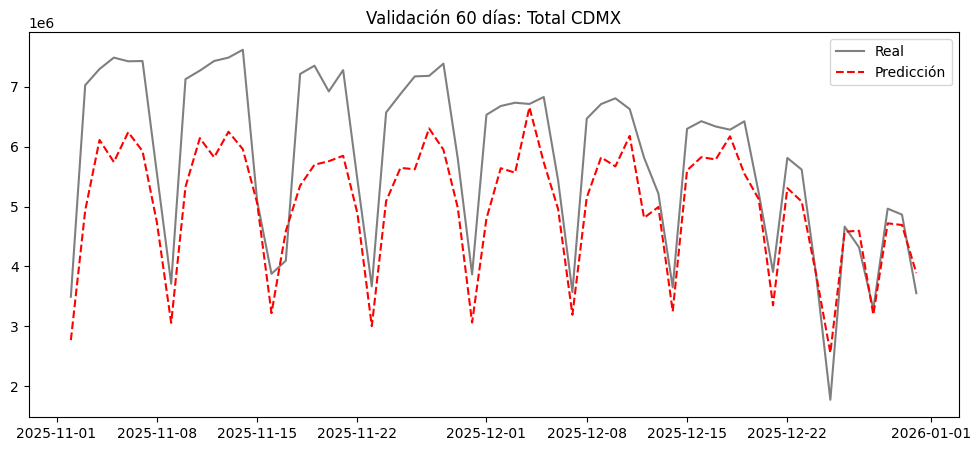

In [421]:
import matplotlib.pyplot as plt

# Filtrar solo el nivel Total para la gráfica
df_total = test[test['Nivel'] == 'Total'].copy()
df_total['y_pred'] = final_pipeline.predict(X_test[test['Nivel'] == 'Total'])

plt.figure(figsize=(12, 5))
plt.plot(df_total['fecha'], df_total['afluencia'], label='Real', color='black', alpha=0.5)
plt.plot(df_total['fecha'], df_total['y_pred'], label='Predicción', color='red', linestyle='--')
plt.title("Validación 60 días: Total CDMX")
plt.legend()
plt.show()

In [422]:
import plotly.express as px
import pandas as pd
import numpy as np

# 1. Definimos la función sMAPE local (robusta para grupos)
def calcular_smape_valor(y_true, y_pred):
    denom = (np.abs(y_true) + np.abs(y_pred) + 1e-10)
    return np.mean(2 * np.abs(y_pred - y_true) / denom) * 100

# 2. Generar predicciones (usando el modelo ganador)
# Asegúrate de que X_train y X_test tengan el mismo orden que train y test
train['y_pred'] = final_pipeline.predict(X_train)
test['y_pred'] = final_pipeline.predict(X_test)

# 3. Función para calcular sMAPE por cada serie individual
def get_diagnostico_smape(df_subset, nombre_dataset):
    res = []
    # Agrupamos por id_serie y Nivel (para no perder la etiqueta)
    for (id_serie, nivel), group in df_subset.groupby(['id_serie', 'Nivel']):
        error = calcular_smape_valor(group['afluencia'], group['y_pred'])
        res.append({
            'id_serie': id_serie,
            'Nivel': nivel,
            'sMAPE': error,
            'Dataset': nombre_dataset
        })
    return pd.DataFrame(res)

# 4. Construir el set de datos para el gráfico
diag_train = get_diagnostico_smape(train, 'Train (Entrenamiento)')
diag_test = get_diagnostico_smape(test, 'Test (Evaluación 60d)')
df_plot = pd.concat([diag_train, diag_test])

# 5. Ordenar la jerarquía para que el eje X sea lógico
orden_jerarquia = ['Total', 'tipo_transporte', 'Linea', 'Alcaldia', 'Estacion']
df_plot['Nivel'] = pd.Categorical(df_plot['Nivel'], categories=orden_jerarquia, ordered=True)

# 6. Crear el BoxPlot Interactivo con Plotly
fig = px.box(
    df_plot,
    x='Nivel',
    y='sMAPE',
    color='Dataset',
    points='outliers', # Muestra puntos individuales solo para los casos extremos
    hover_data=['id_serie'], # Para que al pasar el mouse sepas qué estación es
    title=f'Distribución de sMAPE por Nivel Jerárquico - Modelo: {winner_name}',
    labels={'sMAPE': 'sMAPE (%)', 'Nivel': 'Jerarquía'},
    category_orders={'Nivel': orden_jerarquia},
    color_discrete_map={'Train (Entrenamiento)': '#636EFA', 'Test (Evaluación 60d)': '#EF553B'}
)

# Mejorar el diseño
fig.update_layout(
    template='plotly_white',
    yaxis_range=[0, min(df_plot['sMAPE'].max(), 120)], # Limitamos a 100% para legibilidad
    boxmode='group' # Pone las cajas de Train y Test una al lado de la otra
)

fig.show()

In [423]:
import plotly.express as px
import plotly.graph_objects as go

# Generar predicciones para ambos sets
y_train_pred = final_pipeline.predict(X_train)
y_val_pred = final_pipeline.predict(X_test)

# Crear un dataframe consolidado para visualización
results_train = train[['fecha', 'tipo_transporte', 'alcaldia', 'linea', 'estacion', 'afluencia']].copy()
results_train['prediccion'] = y_train_pred
results_train['set'] = 'Entrenamiento'

results_val = test[['fecha', 'tipo_transporte', 'alcaldia', 'linea', 'estacion', 'afluencia']].copy()
results_val['prediccion'] = y_val_pred
results_val['set'] = 'Validacion'

df_results = pd.concat([results_train, results_val])

In [424]:
import pandas as pd
import plotly.graph_objects as go

def plot_hierarchy_fit(df, level_col, level_value):
    # 1. Asegurar formato de fecha
    df_plot = df.copy()
    df_plot['fecha'] = pd.to_datetime(df_plot['fecha'])

    # 2. Agregación por nivel jerárquico
    df_level = df_plot[df_plot[level_col] == level_value].groupby('fecha')[['afluencia', 'prediccion']].sum().reset_index()

    fig = go.Figure()

    # Línea de Afluencia Real
    fig.add_trace(go.Scatter(
        x=df_level['fecha'], y=df_level['afluencia'],
        name='Real', line=dict(color='#1f77b4', width=2)
    ))

    # Línea de Predicción
    fig.add_trace(go.Scatter(
        x=df_level['fecha'], y=df_level['prediccion'],
        name='Predicción', line=dict(color='#ff7f0e', width=2, dash='dot')
    ))

    # --- SOLUCIÓN AL ERROR DE TIMESTAMPS ---
    cutoff_date = pd.to_datetime("2025-10-31")

    # Agregamos la línea sin parámetros de anotación internos
    fig.add_vline(x=cutoff_date, line_dash="dash", line_color="red")

    # Agregamos el texto manualmente para evitar el error de suma de tipos
    fig.add_annotation(
        x=cutoff_date,
        y=1, # Posición relativa al eje y (top)
        yref="paper",
        text="Inicio Validación",
        showarrow=False,
        xanchor="left",
        font=dict(color="red", size=12),
        bgcolor="white"
    )

    fig.update_layout(
        title=f'Ajuste de Afluencia: {level_col} - {level_value}',
        xaxis_title='Fecha',
        yaxis_title='Pasajeros Totales',
        template='plotly_white',
        hovermode="x unified",
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
    )

    fig.show(renderer="colab")

# Ejecución de prueba
plot_hierarchy_fit(df_results, 'tipo_transporte', 'Metro')

In [425]:
plot_hierarchy_fit(df_results, 'tipo_transporte', 'Metrobús')

In [426]:
plot_hierarchy_fit(df_results, 'tipo_transporte', 'RTP')

In [427]:
plot_hierarchy_fit(df_results, 'tipo_transporte', 'Trolebús')

In [428]:
plot_hierarchy_fit(df_results, 'tipo_transporte', 'Cablebús')

In [429]:
plot_hierarchy_fit(df_results, 'tipo_transporte', 'Tren Ligero')

In [430]:
def plot_station_fit(df, station_name):
    df_station = df[df['estacion'] == station_name].sort_values('fecha')

    fig = px.line(df_station, x='fecha', y=['afluencia', 'prediccion'],
                  title=f'Ajuste Diario: Estación {station_name}',
                  labels={'value': 'Pasajeros', 'variable': 'Tipo'},
                  color_discrete_map={'afluencia': 'blue', 'prediccion': 'orange'})

    fig.add_vline(x="2025-10-31", line_dash="dash", line_color="red")
    fig.show(renderer="colab")

# Visualizar casos clave
plot_station_fit(df_results, 'PANTITLAN') # Caso de alta densidad
plot_station_fit(df_results, 'CIRCUITO')  # Caso de Metrobús

In [431]:
import pandas as pd
import plotly.graph_objects as go

def plot_global_forecast(df_val, df_test):
    # 1. Preparar y agrupar datos de Validación (Nov-Dic 2025)
    val_global = df_val.groupby('fecha')[['afluencia', 'prediccion']].sum().reset_index()

    # 2. Preparar datos de Forecast (Ene-Feb 2026)
    # En el test_df, la columna 'afluencia' ya contiene las predicciones del bucle recursivo
    test_global = df_test.groupby('fecha')['afluencia'].sum().reset_index()
    test_global.rename(columns={'afluencia': 'pronostico_2026'}, inplace=True)

    fig = go.Figure()

    # --- BLOQUE DE VALIDACIÓN ---
    # Afluencia Real (Solo hasta dic 2025)
    fig.add_trace(go.Scatter(
        x=val_global['fecha'], y=val_global['afluencia'],
        name='Real (Validación)', line=dict(color='#1f77b4', width=2)
    ))

    # Predicción del Modelo en Validación
    fig.add_trace(go.Scatter(
        x=val_global['fecha'], y=val_global['prediccion'],
        name='Ajuste (Validación)', line=dict(color='#ff7f0e', width=2, dash='dot')
    ))

    # --- BLOQUE DE PRUEBA / FORECAST 2026 ---
    # Pronóstico para el futuro
    fig.add_trace(go.Scatter(
        x=test_global['fecha'], y=test_global['pronostico_2026'],
        name='Pronóstico 2026', line=dict(color='#2ca02c', width=3)
    ))

    # --- ANOTACIONES Y ESTILO ---
    cutoff_forecast = pd.to_datetime("2025-12-31")

    fig.add_vline(x=cutoff_forecast, line_dash="dash", line_color="black")

    fig.add_annotation(
        x=cutoff_forecast, y=1.05, yref="paper",
        text="INICIO DE PRONÓSTICO 2026",
        showarrow=False, font=dict(color="black", size=12), bgcolor="yellow"
    )

    fig.update_layout(
        title='<b>Jerarquía Global: Validación vs Pronóstico de Movilidad CDMX</b>',
        xaxis_title='Línea de Tiempo',
        yaxis_title='Total Pasajeros Diarios',
        template='plotly_white',
        hovermode="x unified",
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
    )

    fig.show(renderer="colab")

# Ejecución
plot_global_forecast(results_val, test)

# Preservación del modelo

In [432]:
import joblib # Librería estándar para guardar modelos

# 1. Definimos las features finales (las mismas que usamos en el torneo)
features_finales = [
    'day_of_week', 'day_of_month', 'month',
    'es_fin_de_semana', 'es_quincena', 'es_festivo',
    'lag_60', 'lag_67', 'lag_90',
    'rolling_mean_7', 'rolling_mean_30',
    'id_enc', 'nivel_enc'
]

# 2. Usamos el dataframe original "aumentado" y quitamos los nulos iniciales de los lags
# Esto incluye los datos que antes eran de "test"
df_full_train = df_afluencia_h.dropna(subset=['lag_90', 'rolling_mean_30'])

X_full = df_full_train[features_finales]
y_full = df_full_train['afluencia']

print(f"--- Preparando Reentrenamiento Final ---")
print(f"Registros totales para producción: {X_full.shape[0]:,}")

--- Preparando Reentrenamiento Final ---
Registros totales para producción: 793,542


In [433]:
X_full.head(5)

day_of_week  day_of_month  month  es_fin_de_semana  es_quincena  \
828490            4             1      4                 0            1   
828496            5             2      4                 1            0   
828502            6             3      4                 1            0   
828508            0             4      4                 0            0   
828514            1             5      4                 0            0   

        es_festivo       lag_60       lag_67       lag_90  rolling_mean_7  \
828490           0 101954.00000  93609.00000  73120.00000     95454.28571   
828496           0 104742.00000  97659.00000  87359.00000     96466.14286   
828502           0 102730.00000  97165.00000 104001.00000     97261.14286   
828508           0 102497.00000  97219.00000 108199.00000     98015.14286   
828514           0 107220.00000 102012.00000 117619.00000     98759.14286   

        rolling_mean_30  id_enc  nivel_enc  
828490      94649.90000       0          4  
828496      95229.33333       0          4  
828502      95186.96667       0          4  
828508      94996.90000       0          4  
828514      94650.26667       0          4

In [434]:
from sklearn.base import clone

# 1. Clonamos el modelo ganador con sus mejores parámetros
# winner_model es el objeto Pipeline que ya tenías de la fase anterior
pipeline_produccion = clone(final_pipeline)

# 2. Reentrenamiento total
print(f"Entrenando el modelo final ({final_pipeline})... esto puede tardar unos minutos.")
pipeline_produccion.fit(X_full, y_full)

print("✅ Modelo entrenado exitosamente con el 100% de la historia.")
pipeline_produccion

Entrenando el modelo final (Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('winsor', Winsorizer(),
                                                  ['lag_60', 'lag_67', 'lag_90',
                                                   'rolling_mean_7',
                                                   'rolling_mean_30'])])),
                ('regressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=...
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.02208086074248868, max_bin=None,
                       

/usr/local/lib/python3.12/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning:


The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).




Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('winsor', Winsorizer(),
                                                  ['lag_60', 'lag_67', 'lag_90',
                                                   'rolling_mean_7',
                                                   'rolling_mean_30'])])),
                ('regressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=...
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.02208086074248868, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=9, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=450, n_jobs=-1,
                              num_parallel_tree=None, ...))])

In [435]:
# Definir la ruta en tu Drive
ruta_modelo = '/content/drive/MyDrive/Colab Notebooks/Bases_datos_Proy5/modelo_afluencia_2026.pkl'

# Guardamos el pipeline completo (incluye el Winsorizer y el preprocessor)
modelo_dict = {
    'pipeline': pipeline_produccion,
    'features': features_finales,
    'metadata': {
        'modelo_tipo': winner_name,
        'fecha_entrenamiento': pd.Timestamp.now(),
        'horizonte_dias': 60
    }
}

joblib.dump(modelo_dict, ruta_modelo)

print(f"💾 ¡Modelo guardado en Drive! Listo para ser llamado desde Streamlit.")
# model_data = joblib.load('modelo_afluencia_2026.pkl')
# prediccion = model_data['pipeline'].predict(nuevos_datos)

💾 ¡Modelo guardado en Drive! Listo para ser llamado desde Streamlit.


# Pronostico Futuro

In [436]:
# ==========================================
# 7. GENERACIÓN DE CASCARÓN Y PRONÓSTICO (60 DÍAS)
# ==========================================
print("--- Iniciando proceso de pronóstico a futuro ---")

# 1. Parámetros de tiempo
horizonte = 60
max_date = df_afluencia_h['fecha'].max()
future_dates = pd.date_range(start=max_date + pd.Timedelta(days=1), periods=horizonte, freq='D')

# 2. Mapeo de metadatos (para no perder la estructura jerárquica)
# Creamos un diccionario para asignar rápido Nivel, Linea, Alcaldia, etc., a cada id_serie
metadata_map = df_afluencia_h.drop_duplicates('id_serie')[
    ['id_serie', 'tipo_transporte', 'linea', 'alcaldia', 'estacion', 'Nivel']
].set_index('id_serie').to_dict('index')

# 3. Crear el cascarón futuro
future_rows = []
unique_series = df_afluencia_h['id_serie'].unique()

print(f"Generando {len(unique_series) * horizonte} filas futuras...")

for id_s in unique_series:
    meta = metadata_map[id_s]
    for d in future_dates:
        future_rows.append({
            'fecha': d,
            'id_serie': id_s,
            'tipo_transporte': meta['tipo_transporte'],
            'linea': meta['linea'],
            'alcaldia': meta['alcaldia'],
            'estacion': meta['estacion'],
            'Nivel': meta['Nivel'],
            'afluencia': 0.0  # Placeholder
        })

df_future = pd.DataFrame(future_rows)
df_future

--- Iniciando proceso de pronóstico a futuro ---
Generando 30000 filas futuras...


fecha                              id_serie tipo_transporte  \
0     2026-01-01                              Cablebús        Cablebús   
1     2026-01-02                              Cablebús        Cablebús   
2     2026-01-03                              Cablebús        Cablebús   
3     2026-01-04                              Cablebús        Cablebús   
4     2026-01-05                              Cablebús        Cablebús   
...          ...                                   ...             ...   
29995 2026-02-25  Trolebús_LINEA_1_IZTAPALAPA_SIRACUSA        Trolebús   
29996 2026-02-26  Trolebús_LINEA_1_IZTAPALAPA_SIRACUSA        Trolebús   
29997 2026-02-27  Trolebús_LINEA_1_IZTAPALAPA_SIRACUSA        Trolebús   
29998 2026-02-28  Trolebús_LINEA_1_IZTAPALAPA_SIRACUSA        Trolebús   
29999 2026-03-01  Trolebús_LINEA_1_IZTAPALAPA_SIRACUSA        Trolebús   

         linea    alcaldia  estacion            Nivel  afluencia  
0          Agg         Agg       Agg  tipo_transporte    0.00000  
1          Agg         Agg       Agg  tipo_transporte    0.00000  
2          Agg         Agg       Agg  tipo_transporte    0.00000  
3          Agg         Agg       Agg  tipo_transporte    0.00000  
4          Agg         Agg       Agg  tipo_transporte    0.00000  
...        ...         ...       ...              ...        ...  
29995  LINEA_1  IZTAPALAPA  SIRACUSA         Estacion    0.00000  
29996  LINEA_1  IZTAPALAPA  SIRACUSA         Estacion    0.00000  
29997  LINEA_1  IZTAPALAPA  SIRACUSA         Estacion    0.00000  
29998  LINEA_1  IZTAPALAPA  SIRACUSA         Estacion    0.00000  
29999  LINEA_1  IZTAPALAPA  SIRACUSA         Estacion    0.00000  

[30000 rows x 8 columns]

In [437]:
# 4. Unir Histórico + Futuro
# Solo tomamos las columnas necesarias para ahorrar memoria antes de las features
cols_necesarias = ['fecha', 'id_serie', 'tipo_transporte', 'linea', 'alcaldia', 'estacion', 'Nivel', 'afluencia']
df_combined = pd.concat([df_afluencia_h[cols_necesarias], df_future], ignore_index=True)
df_combined

fecha                              id_serie tipo_transporte  \
0      2022-04-01                              Cablebús        Cablebús   
1      2022-04-02                              Cablebús        Cablebús   
2      2022-04-03                              Cablebús        Cablebús   
3      2022-04-04                              Cablebús        Cablebús   
4      2022-04-05                              Cablebús        Cablebús   
...           ...                                   ...             ...   
823537 2026-02-25  Trolebús_LINEA_1_IZTAPALAPA_SIRACUSA        Trolebús   
823538 2026-02-26  Trolebús_LINEA_1_IZTAPALAPA_SIRACUSA        Trolebús   
823539 2026-02-27  Trolebús_LINEA_1_IZTAPALAPA_SIRACUSA        Trolebús   
823540 2026-02-28  Trolebús_LINEA_1_IZTAPALAPA_SIRACUSA        Trolebús   
823541 2026-03-01  Trolebús_LINEA_1_IZTAPALAPA_SIRACUSA        Trolebús   

          linea    alcaldia  estacion            Nivel    afluencia  
0           Agg         Agg       Agg  tipo_transporte 125438.00000  
1           Agg         Agg       Agg  tipo_transporte 112600.00000  
2           Agg         Agg       Agg  tipo_transporte  84063.00000  
3           Agg         Agg       Agg  tipo_transporte 119761.00000  
4           Agg         Agg       Agg  tipo_transporte 120480.00000  
...         ...         ...       ...              ...          ...  
823537  LINEA_1  IZTAPALAPA  SIRACUSA         Estacion      0.00000  
823538  LINEA_1  IZTAPALAPA  SIRACUSA         Estacion      0.00000  
823539  LINEA_1  IZTAPALAPA  SIRACUSA         Estacion      0.00000  
823540  LINEA_1  IZTAPALAPA  SIRACUSA         Estacion      0.00000  
823541  LINEA_1  IZTAPALAPA  SIRACUSA         Estacion      0.00000  

[823542 rows x 8 columns]

In [438]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Index: 793542 entries, 828490 to 650688
Data columns (total 25 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   fecha             793542 non-null  datetime64[ns]
 1   tipo_transporte   793542 non-null  object        
 2   estacion          793542 non-null  object        
 3   afluencia         793542 non-null  float64       
 4   linea             793542 non-null  object        
 5   lat               615599 non-null  float64       
 6   lon               615599 non-null  float64       
 7   alcaldia          793542 non-null  object        
 8   element           615599 non-null  object        
 9   geometry          556420 non-null  object        
 10  id_serie          793542 non-null  object        
 11  Nivel             793542 non-null  object        
 12  day_of_week       793542 non-null  int32         
 13  day_of_month      793542 non-null  int32         
 14  mont

In [439]:
# 5. Calcular Features (Lags de 60, Rolling, Calendario)
# Usamos la función que definimos antes con is_future=True
print("Calculando variables de ingeniería para el futuro...")
df_combined_feat = create_forecasting_features(df_combined, is_future=True)
df_combined_feat

Calculando variables de ingeniería para el futuro...


fecha                              id_serie tipo_transporte  \
0      2022-04-01                              Cablebús        Cablebús   
1      2022-04-02                              Cablebús        Cablebús   
2      2022-04-03                              Cablebús        Cablebús   
3      2022-04-04                              Cablebús        Cablebús   
4      2022-04-05                              Cablebús        Cablebús   
...           ...                                   ...             ...   
823537 2026-02-25  Trolebús_LINEA_1_IZTAPALAPA_SIRACUSA        Trolebús   
823538 2026-02-26  Trolebús_LINEA_1_IZTAPALAPA_SIRACUSA        Trolebús   
823539 2026-02-27  Trolebús_LINEA_1_IZTAPALAPA_SIRACUSA        Trolebús   
823540 2026-02-28  Trolebús_LINEA_1_IZTAPALAPA_SIRACUSA        Trolebús   
823541 2026-03-01  Trolebús_LINEA_1_IZTAPALAPA_SIRACUSA        Trolebús   

          linea    alcaldia  estacion            Nivel    afluencia  \
0           Agg         Agg       Agg  tipo_transporte 125438.00000   
1           Agg         Agg       Agg  tipo_transporte 112600.00000   
2           Agg         Agg       Agg  tipo_transporte  84063.00000   
3           Agg         Agg       Agg  tipo_transporte 119761.00000   
4           Agg         Agg       Agg  tipo_transporte 120480.00000   
...         ...         ...       ...              ...          ...   
823537  LINEA_1  IZTAPALAPA  SIRACUSA         Estacion      0.00000   
823538  LINEA_1  IZTAPALAPA  SIRACUSA         Estacion      0.00000   
823539  LINEA_1  IZTAPALAPA  SIRACUSA         Estacion      0.00000   
823540  LINEA_1  IZTAPALAPA  SIRACUSA         Estacion      0.00000   
823541  LINEA_1  IZTAPALAPA  SIRACUSA         Estacion      0.00000   

        day_of_week  day_of_month  ...  es_fin_de_semana  es_quincena  \
0                 4             1  ...                 0            1   
1                 5             2  ...                 1            0   
2                 6             3  ...                 1            0   
3                 0             4  ...                 0            0   
4                 1             5  ...                 0            0   
...             ...           ...  ...               ...          ...   
823537            2            25  ...                 0            0   
823538            3            26  ...                 0            0   
823539            4            27  ...                 0            0   
823540            5            28  ...                 1            0   
823541            6             1  ...                 1            1   

        es_festivo     lag_60     lag_67     lag_90  rolling_mean_7  \
0                0    0.00000    0.00000    0.00000         0.00000   
1                0    0.00000    0.00000    0.00000         0.00000   
2                0    0.00000    0.00000    0.00000         0.00000   
3                0    0.00000    0.00000    0.00000         0.00000   
4                0    0.00000    0.00000    0.00000         0.00000   
...            ...        ...        ...        ...             ...   
823537           0 2621.41898 3140.38351 4132.92426      2671.84632   
823538           0 2126.54842 2344.29530 4097.76606      2640.73962   
823539           0 3107.06616 3499.24257 3048.13998      2584.71442   
823540           0 3108.74401 3437.24832 2260.31640      2537.78523   
823541           0 2296.00192 2551.47651 4169.21381      2501.28886   

        rolling_mean_30  id_enc  nivel_enc  
0               0.00000       0          4  
1               0.00000       0          4  
2               0.00000       0          4  
3               0.00000       0          4  
4               0.00000       0          4  
...                 ...     ...        ...  
823537       3444.17514     499          1  
823538       3378.46788     499          1  
823539       3380.43209     499          1  
823540       3408.71301     499          1  
823541       3346.27261     499  

In [440]:
df_combined_feat.info()

<class 'pandas.core.frame.DataFrame'>
Index: 823542 entries, 0 to 823541
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   fecha             823542 non-null  datetime64[ns]
 1   id_serie          823542 non-null  object        
 2   tipo_transporte   823542 non-null  object        
 3   linea             823542 non-null  object        
 4   alcaldia          823542 non-null  object        
 5   estacion          823542 non-null  object        
 6   Nivel             823542 non-null  object        
 7   afluencia         823542 non-null  float64       
 8   day_of_week       823542 non-null  int32         
 9   day_of_month      823542 non-null  int32         
 10  month             823542 non-null  int32         
 11  es_fin_de_semana  823542 non-null  int64         
 12  es_quincena       823542 non-null  int64         
 13  es_festivo        823542 non-null  int64         
 14  lag_60   

In [441]:
# 6. Extraer solo las filas que corresponden al futuro para predecir
X_future = df_combined_feat[df_combined_feat['fecha'] > max_date].copy()
X_future

fecha                              id_serie tipo_transporte  \
793542 2026-01-01                              Cablebús        Cablebús   
793543 2026-01-02                              Cablebús        Cablebús   
793544 2026-01-03                              Cablebús        Cablebús   
793545 2026-01-04                              Cablebús        Cablebús   
793546 2026-01-05                              Cablebús        Cablebús   
...           ...                                   ...             ...   
823537 2026-02-25  Trolebús_LINEA_1_IZTAPALAPA_SIRACUSA        Trolebús   
823538 2026-02-26  Trolebús_LINEA_1_IZTAPALAPA_SIRACUSA        Trolebús   
823539 2026-02-27  Trolebús_LINEA_1_IZTAPALAPA_SIRACUSA        Trolebús   
823540 2026-02-28  Trolebús_LINEA_1_IZTAPALAPA_SIRACUSA        Trolebús   
823541 2026-03-01  Trolebús_LINEA_1_IZTAPALAPA_SIRACUSA        Trolebús   

          linea    alcaldia  estacion            Nivel  afluencia  \
793542      Agg         Agg       Agg  tipo_transporte    0.00000   
793543      Agg         Agg       Agg  tipo_transporte    0.00000   
793544      Agg         Agg       Agg  tipo_transporte    0.00000   
793545      Agg         Agg       Agg  tipo_transporte    0.00000   
793546      Agg         Agg       Agg  tipo_transporte    0.00000   
...         ...         ...       ...              ...        ...   
823537  LINEA_1  IZTAPALAPA  SIRACUSA         Estacion    0.00000   
823538  LINEA_1  IZTAPALAPA  SIRACUSA         Estacion    0.00000   
823539  LINEA_1  IZTAPALAPA  SIRACUSA         Estacion    0.00000   
823540  LINEA_1  IZTAPALAPA  SIRACUSA         Estacion    0.00000   
823541  LINEA_1  IZTAPALAPA  SIRACUSA         Estacion    0.00000   

        day_of_week  day_of_month  ...  es_fin_de_semana  es_quincena  \
793542            3             1  ...                 0            1   
793543            4             2  ...                 0            0   
793544            5             3  ...                 1            0   
793545            6             4  ...                 1            0   
793546            0             5  ...                 0            0   
...             ...           ...  ...               ...          ...   
823537            2            25  ...                 0            0   
823538            3            26  ...                 0            0   
823539            4            27  ...                 0            0   
823540            5            28  ...                 1            0   
823541            6             1  ...                 1            1   

        es_festivo       lag_60       lag_67       lag_90  rolling_mean_7  \
793542           1  89123.00000  98194.00000 147426.00000    136913.14286   
793543           0 146213.00000 149766.00000 155435.00000    136405.57143   
793544           0 150295.00000 148157.00000  85780.00000    136711.00000   
793545           0 153463.00000 143224.00000 141985.00000    138173.71429   
793546           0 150765.00000 150862.00000 145038.00000    138159.85714   
...            ...          ...          ...          ...             ...   
823537           0   2621.41898   3140.38351   4132.92426      2671.84632   
823538           0   2126.54842   2344.29530   4097.76606      2640.73962   
823539           0   3107.06616   3499.24257   3048.13998      2584.71442   
823540           0   3108.74401   3437.24832   2260.31640      2537.78523   
823541           0   2296.00192   2551.47651   4169.21381      2501.28886   

        rolling_mean_30  id_enc  nivel_enc  
793542     134866.23333       0          4  
793543     134558.83333       0          4  
793544     136709.33333       0          4  
793545     137091.93333       0          4  
793546     137282.83333       0          4  
...                 ...     ...        ...  
823537       3444.17514     499          1  
823538       3378.46788     499          1  
823539       3380.43209     499          1  
823540       3408.71301     49

In [442]:
# 7. Ejecutar Predicción Final
# Usamos el pipeline_produccion que entrenamos con el 100% de los datos
print(f"Ejecutando predicciones con el modelo final...")
X_future['prediccion_afluencia'] = pipeline_produccion.predict(X_future[features_finales])

# 8. Limpieza: Asegurar que no haya predicciones negativas (a veces pasa en regresión)
X_future['prediccion_afluencia'] = X_future['prediccion_afluencia'].clip(lower=0)

print("✅ ¡Pronóstico para los próximos 60 días completado!")

Ejecutando predicciones con el modelo final...
✅ ¡Pronóstico para los próximos 60 días completado!


In [443]:
X_future

fecha                              id_serie tipo_transporte  \
793542 2026-01-01                              Cablebús        Cablebús   
793543 2026-01-02                              Cablebús        Cablebús   
793544 2026-01-03                              Cablebús        Cablebús   
793545 2026-01-04                              Cablebús        Cablebús   
793546 2026-01-05                              Cablebús        Cablebús   
...           ...                                   ...             ...   
823537 2026-02-25  Trolebús_LINEA_1_IZTAPALAPA_SIRACUSA        Trolebús   
823538 2026-02-26  Trolebús_LINEA_1_IZTAPALAPA_SIRACUSA        Trolebús   
823539 2026-02-27  Trolebús_LINEA_1_IZTAPALAPA_SIRACUSA        Trolebús   
823540 2026-02-28  Trolebús_LINEA_1_IZTAPALAPA_SIRACUSA        Trolebús   
823541 2026-03-01  Trolebús_LINEA_1_IZTAPALAPA_SIRACUSA        Trolebús   

          linea    alcaldia  estacion            Nivel  afluencia  \
793542      Agg         Agg       Agg  tipo_transporte    0.00000   
793543      Agg         Agg       Agg  tipo_transporte    0.00000   
793544      Agg         Agg       Agg  tipo_transporte    0.00000   
793545      Agg         Agg       Agg  tipo_transporte    0.00000   
793546      Agg         Agg       Agg  tipo_transporte    0.00000   
...         ...         ...       ...              ...        ...   
823537  LINEA_1  IZTAPALAPA  SIRACUSA         Estacion    0.00000   
823538  LINEA_1  IZTAPALAPA  SIRACUSA         Estacion    0.00000   
823539  LINEA_1  IZTAPALAPA  SIRACUSA         Estacion    0.00000   
823540  LINEA_1  IZTAPALAPA  SIRACUSA         Estacion    0.00000   
823541  LINEA_1  IZTAPALAPA  SIRACUSA         Estacion    0.00000   

        day_of_week  day_of_month  ...  es_quincena  es_festivo       lag_60  \
793542            3             1  ...            1           1  89123.00000   
793543            4             2  ...            0           0 146213.00000   
793544            5             3  ...            0           0 150295.00000   
793545            6             4  ...            0           0 153463.00000   
793546            0             5  ...            0           0 150765.00000   
...             ...           ...  ...          ...         ...          ...   
823537            2            25  ...            0           0   2621.41898   
823538            3            26  ...            0           0   2126.54842   
823539            4            27  ...            0           0   3107.06616   
823540            5            28  ...            0           0   3108.74401   
823541            6             1  ...            1           0   2296.00192   

             lag_67       lag_90  rolling_mean_7  rolling_mean_30  id_enc  \
793542  98194.00000 147426.00000    136913.14286     134866.23333       0   
793543 149766.00000 155435.00000    136405.57143     134558.83333       0   
793544 148157.00000  85780.00000    136711.00000     136709.33333       0   
793545 143224.00000 141985.00000    138173.71429     137091.93333       0   
793546 150862.00000 145038.00000    138159.85714     137282.83333       0   
...             ...          ...             ...              ...     ...   
823537   3140.38351   4132.92426      2671.84632       3444.17514     499   
823538   2344.29530   4097.76606      2640.73962       3378.46788     499   
823539   3499.24257   3048.13998      2584.71442       3380.43209     499   
823540   3437.24832   2260.31640      2537.78523       3408.71301     499   
823541   2551.47651   4169.21381      2501.28886       3346.27261     499   

        nivel_enc  prediccion_afluencia  
793542          4           56727.94531  
793543          4          119996.95312  
793544          4          112018.75000  
793545          4           80095.64062  
793546          4          117379.27344  
...           ...                   ...  
823537          1            3981.78931  
823538          1            3979.99512  
823539          1 

In [444]:
# ==========================================
# 8. RECONCILIACIÓN (BOTTOM-UP COHERENCE)
# ==========================================
print("--- Iniciando Reconciliación Jerárquica (Bottom-Up) ---")

# 1. Extraemos la "Verdad Atómica": El nivel Estación
# Este es el nivel base sobre el cual construiremos todos los demás.
df_base = X_future[X_future['Nivel'] == 'Estacion'].copy()

# Guardamos la predicción original de la estación como la reconciliada
df_base['afluencia_reconciliada'] = df_base['prediccion_afluencia']

# 2. Reconstruir Nivel: Alcaldía (Suma de sus estaciones)
recon_alcaldia = df_base.groupby(['fecha', 'tipo_transporte', 'linea', 'alcaldia'])['afluencia_reconciliada'].sum().reset_index()
recon_alcaldia['Nivel'] = 'Alcaldia'
recon_alcaldia['id_serie'] = recon_alcaldia['tipo_transporte'] + '_' + recon_alcaldia['linea'] + '_' + recon_alcaldia['alcaldia']
recon_alcaldia['estacion'] = 'Agg'

# 3. Reconstruir Nivel: Línea (Suma de sus alcaldías/estaciones)
recon_linea = recon_alcaldia.groupby(['fecha', 'tipo_transporte', 'linea'])['afluencia_reconciliada'].sum().reset_index()
recon_linea['Nivel'] = 'Linea'
recon_linea['id_serie'] = recon_linea['tipo_transporte'] + '_' + recon_linea['linea']
recon_linea['alcaldia'], recon_linea['estacion'] = 'Agg', 'Agg'

# 4. Reconstruir Nivel: Tipo de Transporte
recon_transporte = recon_linea.groupby(['fecha', 'tipo_transporte'])['afluencia_reconciliada'].sum().reset_index()
recon_transporte['Nivel'] = 'tipo_transporte'
recon_transporte['id_serie'] = recon_transporte['tipo_transporte']
(recon_transporte['linea'], recon_transporte['alcaldia'],
 recon_transporte['estacion']) = 'Agg', 'Agg', 'Agg'

# 5. Reconstruir Nivel: Total CDMX
recon_total = recon_transporte.groupby(['fecha'])['afluencia_reconciliada'].sum().reset_index()
recon_total['Nivel'] = 'Total'
recon_total['id_serie'] = 'Total'
(recon_total['tipo_transporte'], recon_total['linea'],
 recon_total['alcaldia'], recon_total['estacion']) = 'Agg', 'Agg', 'Agg', 'Agg'

# 6. Unir todo en el DataFrame Final de Pronóstico
df_forecast_2026 = pd.concat([
    df_base,
    recon_alcaldia,
    recon_linea,
    recon_transporte,
    recon_total
], ignore_index=True)

# 7. Limpieza final de columnas para el Score de Riesgo
cols_finales = ['fecha', 'id_serie', 'Nivel', 'tipo_transporte', 'linea', 'alcaldia', 'estacion', 'afluencia_reconciliada']
df_forecast_2026 = df_forecast_2026[cols_finales]

print(f" Reconciliación terminada. Registros totales coherentes: {len(df_forecast_2026):,}")

--- Iniciando Reconciliación Jerárquica (Bottom-Up) ---
 Reconciliación terminada. Registros totales coherentes: 30,000


In [445]:
list(df_forecast_2026['id_serie'].value_counts().index)

['Total',
 'Cablebús_LINEA_1_GUSTAVO A MADERO_CAMPOS REVOLUCION',
 'Cablebús_LINEA_1_GUSTAVO A MADERO_CUAUTEPEC',
 'Cablebús_LINEA_1_GUSTAVO A MADERO_INDIOS VERDES',
 'Metrobús_LINEA_1',
 'Metro_LINEA_B',
 'Metro_LINEA_A',
 'Metro_LINEA_9',
 'Metro_LINEA_8',
 'Metro_LINEA_7',
 'Metro_LINEA_6',
 'Metro_LINEA_5',
 'Metro_LINEA_4',
 'Metro_LINEA_3',
 'Metro_LINEA_2',
 'Metro_LINEA_12',
 'Metro_LINEA_1',
 'Cablebús_LINEA_3',
 'Cablebús_LINEA_2',
 'Cablebús_LINEA_1',
 'Metro_LINEA_1_CUAUHTEMOC_ISABEL LA CATOLICA',
 'Metro_LINEA_1_CUAUHTEMOC_INSURGENTES',
 'Metro_LINEA_1_CUAUHTEMOC_CUAUHTEMOC',
 'Metro_LINEA_1_CUAUHTEMOC_BALDERAS',
 'Metro_LINEA_12_VENUSTIANO CARRANZA_ZAPATA',
 'Metro_LINEA_12_VENUSTIANO CARRANZA_MIXCOAC',
 'Metro_LINEA_12_VENUSTIANO CARRANZA_ERMITA',
 'Metro_LINEA_12_VENUSTIANO CARRANZA_ATLALILCO',
 'Metro_LINEA_12_TLAHUAC_ZAPOTITLAN',
 'Metro_LINEA_12_TLAHUAC_TLALTENCO',
 'Metro_LINEA_12_TLAHUAC_TLAHUAC',
 'Metro_LINEA_12_TLAHUAC_OLIVOS',
 'Metro_LINEA_12_TLAHUAC_NOPALERA'

In [446]:
df_forecast_2026

fecha                                           id_serie     Nivel  \
0     2026-01-01  Cablebús_LINEA_1_GUSTAVO A MADERO_CAMPOS REVOL...  Estacion   
1     2026-01-02  Cablebús_LINEA_1_GUSTAVO A MADERO_CAMPOS REVOL...  Estacion   
2     2026-01-03  Cablebús_LINEA_1_GUSTAVO A MADERO_CAMPOS REVOL...  Estacion   
3     2026-01-04  Cablebús_LINEA_1_GUSTAVO A MADERO_CAMPOS REVOL...  Estacion   
4     2026-01-05  Cablebús_LINEA_1_GUSTAVO A MADERO_CAMPOS REVOL...  Estacion   
...          ...                                                ...       ...   
29995 2026-02-25                                              Total     Total   
29996 2026-02-26                                              Total     Total   
29997 2026-02-27                                              Total     Total   
29998 2026-02-28                                              Total     Total   
29999 2026-03-01                                              Total     Total   

      tipo_transporte    linea          alcaldia           estacion  \
0            Cablebús  LINEA_1  GUSTAVO A MADERO  CAMPOS REVOLUCION   
1            Cablebús  LINEA_1  GUSTAVO A MADERO  CAMPOS REVOLUCION   
2            Cablebús  LINEA_1  GUSTAVO A MADERO  CAMPOS REVOLUCION   
3            Cablebús  LINEA_1  GUSTAVO A MADERO  CAMPOS REVOLUCION   
4            Cablebús  LINEA_1  GUSTAVO A MADERO  CAMPOS REVOLUCION   
...               ...      ...               ...                ...   
29995             Agg      Agg               Agg                Agg   
29996             Agg      Agg               Agg                Agg   
29997             Agg      Agg               Agg                Agg   
29998             Agg      Agg               Agg                Agg   
29999             Agg      Agg               Agg                Agg   

       afluencia_reconciliada  
0                  4988.15820  
1                 10130.13770  
2                  7995.46484  
3                  6266.15039  
4                  9327.29980  
...                       ...  
29995           6643361.50000  
29996           6624042.50000  
29997           6279228.00000  
29998           4887840.00000  
29999           3255952.50000  

[30000 rows x 8 columns]

In [447]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# 1. Seleccionar qué series queremos comparar para el "storytelling"
# Puedes cambiarlas por las que más te interesen
series_to_plot = ['Total', 'Metro_LINEA_1_VENUSTIANO CARRANZA_PANTITLAN', 'Metro'] # Ajustar a tus IDs reales

# 2. Crear la estructura de subplots (3 filas, 1 columna)
fig = make_subplots(
    rows=3, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.08,
    subplot_titles=(f"Proyección: {series_to_plot[0]}",
                    f"Proyección: {series_to_plot[1]}",
                    f"Proyección: {series_to_plot[2]}")
)

# 3. Configuración de tiempo
fecha_corte = df_afluencia_h['fecha'].max()
fecha_inicio_vista = fecha_corte - pd.Timedelta(days=1800) # Ver los últimos 30 días

for i, serie in enumerate(series_to_plot, start=1):
    # --- Datos Históricos ---
    hist = df_afluencia_h[(df_afluencia_h['id_serie'] == serie) &
                          (df_afluencia_h['fecha'] >= fecha_inicio_vista)]

    # --- Datos Futuros Reconciliados ---
    fut = df_forecast_2026[df_forecast_2026['id_serie'] == serie]

    # Traza Histórica (Azul)
    fig.add_trace(
        go.Scatter(x=hist['fecha'], y=hist['afluencia'],
                   name='Histórico Real', line=dict(color='royalblue', width=2),
                   mode='lines+markers'),
        row=i, col=1
    )

    # Traza Futura (Naranja/Rojo - como en la imagen)
    fig.add_trace(
        go.Scatter(x=fut['fecha'], y=fut['afluencia_reconciliada'],
                   name='Pronóstico 2026', line=dict(color='firebrick', width=3, dash='dot'),
                   mode='lines+markers'),
        row=i, col=1
    )

    # Línea Vertical de "Hoy"
    fig.add_vline(x=fecha_corte.timestamp() * 1000, line_width=2, line_dash="dash", line_color="green", row=i, col=1)

# 4. Diseño Final (Layout)
fig.update_layout(
    height=900,
    title_text="🚀 Dashboard de Afluencia Proyectada 2026 (Bottom-Up)",
    showlegend=False, # Quitamos leyenda repetitiva, Plotly es interactivo
    template='plotly_white'
)

# Añadir anotación de "Hoy" solo en el primer gráfico
fig.add_annotation(x=fecha_corte, y=1.1, yref="paper", text="Día del Reentrenamiento", showarrow=False, font=dict(color="green"))

fig.show(renderer="colab")

print("\n ¡Visualización Finalizada! El futuro de la movilidad está listo.")


 ¡Visualización Finalizada! El futuro de la movilidad está listo.


In [448]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def visualizar_pronostico_dinamico(df_hist, df_fut, lista_ids, dias_atras=1800):
    """
    Genera un dashboard interactivo para una lista dinámica de series.
    """
    # 1. Asegurar formatos de fecha
    df_hist['fecha'] = pd.to_datetime(df_hist['fecha'])
    df_fut['fecha'] = pd.to_datetime(df_fut['fecha'])

    n_series = len(lista_ids)
    fecha_corte = df_hist['fecha'].max()
    fecha_inicio = fecha_corte - pd.Timedelta(days=dias_atras)

    # 2. Crear subplots dinámicos (una fila por cada ID en la lista)
    fig = make_subplots(
        rows=n_series, cols=1,
        shared_xaxes=True,
        vertical_spacing=0.05,
        subplot_titles=[f"Serie: {id_s}" for id_s in lista_ids]
    )

    # 3. Iterar sobre la lista de IDs solicitados
    for i, id_serie in enumerate(lista_ids, start=1):
        # Filtrar histórico y futuro
        hist_sub = df_hist[(df_hist['id_serie'] == id_serie) & (df_hist['fecha'] >= fecha_inicio)]
        fut_sub = df_fut[df_fut['id_serie'] == id_serie]

        if hist_sub.empty and fut_sub.empty:
            print(f"⚠️ Advertencia: No se encontraron datos para '{id_serie}'")
            continue

        # Traza Histórica
        fig.add_trace(
            go.Scatter(x=hist_sub['fecha'], y=hist_sub['afluencia'],
                       name='Histórico', line=dict(color='#1f77b4', width=2),
                       legendgroup=id_serie),
            row=i, col=1
        )

        # Traza Pronóstico Reconciliado
        fig.add_trace(
            go.Scatter(x=fut_sub['fecha'], y=fut_sub['afluencia_reconciliada'],
                       name='Pronóstico 2026', line=dict(color='#d62728', width=3, dash='dot'),
                       legendgroup=id_serie),
            row=i, col=1
        )

        # Línea de "Hoy"
        fig.add_vline(x=fecha_corte.timestamp() * 1000, line_width=1.5, line_dash="dash", line_color="green", row=i, col=1)

    # 4. Ajustes estéticos finales
    # El alto de la imagen escala con el número de series (300px por serie)
    fig.update_layout(
        height=300 * n_series,
        title_text=f"📊 Comparativa de Movilidad CDMX 2026",
        template='plotly_white',
        showlegend=False
    )

    return fig

# --- CÓMO USAR LA FUNCIÓN ---

# Ejemplo 1: Tu lista de transportes
lista_transportes = ['Total', 'Trolebús', 'Tren Ligero', 'RTP', 'Metrobús', 'Metro', 'Cablebús']
fig_transporte = visualizar_pronostico_dinamico(df_afluencia_h, df_forecast_2026, lista_transportes)
fig_transporte.show(renderer="colab")

In [449]:
df_afluencia_h

fecha tipo_transporte  estacion    afluencia    linea      lat  \
828490 2022-04-01        Cablebús       Agg 125438.00000      Agg      NaN   
828496 2022-04-02        Cablebús       Agg 112600.00000      Agg      NaN   
828502 2022-04-03        Cablebús       Agg  84063.00000      Agg      NaN   
828508 2022-04-04        Cablebús       Agg 119761.00000      Agg      NaN   
828514 2022-04-05        Cablebús       Agg 120480.00000      Agg      NaN   
...           ...             ...       ...          ...      ...      ...   
649128 2025-12-27        Trolebús  SIRACUSA   2621.41898  LINEA_1 19.32159   
649518 2025-12-28        Trolebús  SIRACUSA   2126.54842  LINEA_1 19.32159   
649908 2025-12-29        Trolebús  SIRACUSA   3107.06616  LINEA_1 19.32159   
650298 2025-12-30        Trolebús  SIRACUSA   3108.74401  LINEA_1 19.32159   
650688 2025-12-31        Trolebús  SIRACUSA   2296.00192  LINEA_1 19.32159   

             lon    alcaldia element                        geometry  ...  \
828490       NaN         Agg     NaN                             NaN  ...   
828496       NaN         Agg     NaN                             NaN  ...   
828502       NaN         Agg     NaN                             NaN  ...   
828508       NaN         Agg     NaN                             NaN  ...   
828514       NaN         Agg     NaN                             NaN  ...   
...          ...         ...     ...                             ...  ...   
649128 -99.09285  IZTAPALAPA    node  POINT (-99.0928514 19.3215887)  ...   
649518 -99.09285  IZTAPALAPA    node  POINT (-99.0928514 19.3215887)  ...   
649908 -99.09285  IZTAPALAPA    node  POINT (-99.0928514 19.3215887)  ...   
650298 -99.09285  IZTAPALAPA    node  POINT (-99.0928514 19.3215887)  ...   
650688 -99.09285  IZTAPALAPA    node  POINT (-99.0928514 19.3215887)  ...   

       es_fin_de_semana es_quincena  es_festivo       lag_60       lag_67  \
828490                0           1           0 101954.00000  93609.00000   
828496                1           0           0 104742.00000  97659.00000   
828502                1           0           0 102730.00000  97165.00000   
828508                0           0           0 102497.00000  97219.00000   
828514                0           0           0 107220.00000 102012.00000   
...                 ...         ...         ...          ...          ...   
649128                1           0           0   4501.24640   4433.79674   
649518                1           0           0   4229.14669   4370.63279   
649908                0           0           0   4459.30010   4414.51582   
650298                0           1           0   4332.90508   4409.25216   
650688                0           1           0   2800.45062   3182.43528   

             lag_90  rolling_mean_7  rolling_mean_30  id_enc  nivel_enc  
828490  73120.00000     95454.28571      94649.90000       0          4  
828496  87359.00000     96466.14286      95229.33333       0          4  
828502 104001.00000     97261.14286      95186.96667       0          4  
828508 108199.00000     98015.14286      94996.90000       0          4  
828514 117619.00000     98759.14286      94650.26667       0          4  
...             ...             ...              ...     ...        ...  
649128   2030.03835      3951.32995       3734.67114     499          1  
649518   3945.54171      3931.11766       3744.12464     499          1  
649908   4072.78044      3937.51541       3757.00863     499          1  
650298   4101.61074      3926.60868       3764.71844     499          1  
650688   3732.16683      3872.03945       3733.66123     499          1  

[793542 rows x 25 columns]

In [450]:
print(f"¿'id_serie' está en el histórico?: {'id_serie' in df_afluencia_h.columns or 'id_serie' in df_afluencia_h.index.names}")
print(f"¿'id_serie' está en el pronóstico?: {'id_serie' in df_forecast_2026.columns or 'id_serie' in df_forecast_2026.index.names}")

¿'id_serie' está en el histórico?: True
¿'id_serie' está en el pronóstico?: True


In [451]:
import pandas as pd
import numpy as np
from shapely.geometry import Point
import pandas as pd

def generar_tablon_estaciones_2026(df_hist, df_fut):
    """
    Une histórico y futuro solo a nivel Estación, recuperando geometría
    y eliminando registros agregados (Agg).
    """
    # 1. Filtrar solo nivel Estación (esto elimina automáticamente los 'Agg')
    hist_est = df_hist[df_hist['Nivel'] == 'Estacion'].copy()
    fut_est = df_fut[df_fut['Nivel'] == 'Estacion'].copy()

    # 2. Renombrar columnas para consistencia
    # En el futuro la afluencia es la 'afluencia_reconciliada'
    fut_est = fut_est.rename(columns={'afluencia_reconciliada': 'afluencia_predicha'})

    # En el histórico, la predicción es NaN (o el valor real si quieres comparar)
    hist_est['afluencia_predicha'] = np.nan

    # 3. Crear Diccionario de Geometría (Mapping)
    # Extraemos lat, lon y geometry única por id_serie del histórico
    geo_map = hist_est[['id_serie', 'lat', 'lon', 'geometry']].drop_duplicates('id_serie')

    # 4. Pegar Geometría al futuro
    # El dataframe de futuro no tenía lat/lon/geometry, ahora los recuperamos
    fut_est = fut_est.drop(columns=['lat', 'lon', 'geometry'], errors='ignore') # Por si acaso
    fut_est = fut_est.merge(geo_map, on='id_serie', how='left')

    # 5. Unificar ambos mundos
    tablon_final = pd.concat([hist_est, fut_est], ignore_index=True)

    # 6. Seleccionar y ordenar solo las columnas solicitadas
    columnas_finales = [
        'fecha', 'tipo_transporte', 'linea', 'estacion',
        'alcaldia', 'lat', 'lon', 'geometry',
        'afluencia', 'afluencia_predicha'
    ]

    tablon_final = tablon_final[columnas_finales].sort_values(['estacion', 'fecha'])

    return tablon_final

# --- EJECUCIÓN ---
df_movilidad_unificado = generar_tablon_estaciones_2026(df_afluencia_h, df_forecast_2026)

print(f" Tablón unificado generado con {len(df_movilidad_unificado):,} registros.")
print(f"Columnas resultantes: {df_movilidad_unificado.columns.tolist()}")

/tmp/ipython-input-330226876.py:32: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



 Tablón unificado generado con 638,999 registros.
Columnas resultantes: ['fecha', 'tipo_transporte', 'linea', 'estacion', 'alcaldia', 'lat', 'lon', 'geometry', 'afluencia', 'afluencia_predicha']


In [452]:
df_movilidad_unificado

fecha tipo_transporte    linea                  estacion  \
374588 2021-04-01        Metrobús  LINEA_5  314 MEMORIAL NEWS DIVINE   
374589 2021-04-02        Metrobús  LINEA_5  314 MEMORIAL NEWS DIVINE   
374590 2021-04-03        Metrobús  LINEA_5  314 MEMORIAL NEWS DIVINE   
374591 2021-04-04        Metrobús  LINEA_5  314 MEMORIAL NEWS DIVINE   
374592 2021-04-05        Metrobús  LINEA_5  314 MEMORIAL NEWS DIVINE   
...           ...             ...      ...                       ...   
620034 2026-02-25           Metro  LINEA_2       ZOCALO/TENOCHTITLAN   
620035 2026-02-26           Metro  LINEA_2       ZOCALO/TENOCHTITLAN   
620036 2026-02-27           Metro  LINEA_2       ZOCALO/TENOCHTITLAN   
620037 2026-02-28           Metro  LINEA_2       ZOCALO/TENOCHTITLAN   
620038 2026-03-01           Metro  LINEA_2       ZOCALO/TENOCHTITLAN   

                   alcaldia      lat       lon                       geometry  \
374588     GUSTAVO A MADERO 19.50046 -99.08904  POINT (-99.089042 19.5004555)   
374589     GUSTAVO A MADERO 19.50046 -99.08904  POINT (-99.089042 19.5004555)   
374590     GUSTAVO A MADERO 19.50046 -99.08904  POINT (-99.089042 19.5004555)   
374591     GUSTAVO A MADERO 19.50046 -99.08904  POINT (-99.089042 19.5004555)   
374592     GUSTAVO A MADERO 19.50046 -99.08904  POINT (-99.089042 19.5004555)   
...                     ...      ...       ...                            ...   
620034  VENUSTIANO CARRANZA 19.42178 -99.12128                           None   
620035  VENUSTIANO CARRANZA 19.42178 -99.12128                           None   
620036  VENUSTIANO CARRANZA 19.42178 -99.12128                           None   
620037  VENUSTIANO CARRANZA 19.42178 -99.12128                           None   
620038  VENUSTIANO CARRANZA 19.42178 -99.12128                           None   

         afluencia  afluencia_predicha  
374588 15177.41935                 NaN  
374589 10394.67742                 NaN  
374590 11843.54839                 NaN  
374591 10602.90323                 NaN  
374592 18542.09677                 NaN  
...            ...                 ...  
620034         NaN         43107.89844  
620035         NaN         43896.47266  
620036         NaN         46478.92188  
620037         NaN         44041.32422  
620038         NaN         27773.74219  

[638999 rows x 10 columns]

In [453]:
df_movilidad_unificado[(df_movilidad_unificado["tipo_transporte"]=="Metro") & (df_movilidad_unificado["linea"]=="LINEA_2")
                        & (df_movilidad_unificado["estacion"]=="ZOCALO/TENOCHTITLAN") & (df_movilidad_unificado["alcaldia"]=="VENUSTIANO CARRANZA")]

fecha tipo_transporte    linea             estacion  \
121132 2021-04-01           Metro  LINEA_2  ZOCALO/TENOCHTITLAN   
121133 2021-04-02           Metro  LINEA_2  ZOCALO/TENOCHTITLAN   
121134 2021-04-03           Metro  LINEA_2  ZOCALO/TENOCHTITLAN   
121135 2021-04-04           Metro  LINEA_2  ZOCALO/TENOCHTITLAN   
121136 2021-04-05           Metro  LINEA_2  ZOCALO/TENOCHTITLAN   
...           ...             ...      ...                  ...   
620034 2026-02-25           Metro  LINEA_2  ZOCALO/TENOCHTITLAN   
620035 2026-02-26           Metro  LINEA_2  ZOCALO/TENOCHTITLAN   
620036 2026-02-27           Metro  LINEA_2  ZOCALO/TENOCHTITLAN   
620037 2026-02-28           Metro  LINEA_2  ZOCALO/TENOCHTITLAN   
620038 2026-03-01           Metro  LINEA_2  ZOCALO/TENOCHTITLAN   

                   alcaldia      lat       lon geometry   afluencia  \
121132  VENUSTIANO CARRANZA 19.42178 -99.12128     None 19097.00000   
121133  VENUSTIANO CARRANZA 19.42178 -99.12128     None  6328.00000   
121134  VENUSTIANO CARRANZA 19.42178 -99.12128     None 12741.00000   
121135  VENUSTIANO CARRANZA 19.42178 -99.12128     None  9922.00000   
121136  VENUSTIANO CARRANZA 19.42178 -99.12128     None 20861.00000   
...                     ...      ...       ...      ...         ...   
620034  VENUSTIANO CARRANZA 19.42178 -99.12128     None         NaN   
620035  VENUSTIANO CARRANZA 19.42178 -99.12128     None         NaN   
620036  VENUSTIANO CARRANZA 19.42178 -99.12128     None         NaN   
620037  VENUSTIANO CARRANZA 19.42178 -99.12128     None         NaN   
620038  VENUSTIANO CARRANZA 19.42178 -99.12128     None         NaN   

        afluencia_predicha  
121132                 NaN  
121133                 NaN  
121134                 NaN  
121135                 NaN  
121136                 NaN  
...                    ...  
620034         43107.89844  
620035         43896.47266  
620036         46478.92188  
620037         44041.32422  
620038         27773.74219  

[1796 rows x 10 columns]

In [454]:
df_movilidad_unificado.info()

<class 'pandas.core.frame.DataFrame'>
Index: 638999 entries, 374588 to 620038
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   fecha               638999 non-null  datetime64[ns]
 1   tipo_transporte     638999 non-null  object        
 2   linea               638999 non-null  object        
 3   estacion            638999 non-null  object        
 4   alcaldia            638999 non-null  object        
 5   lat                 638999 non-null  float64       
 6   lon                 638999 non-null  float64       
 7   geometry            577720 non-null  object        
 8   afluencia           615599 non-null  float64       
 9   afluencia_predicha  23400 non-null   float32       
dtypes: datetime64[ns](1), float32(1), float64(3), object(5)
memory usage: 51.2+ MB


In [455]:
resumen_fechas = df_movilidad_unificado.groupby(['tipo_transporte', 'estacion'])['fecha'].agg(['nunique', 'min', 'max']).reset_index()
print(resumen_fechas)

    tipo_transporte              estacion  nunique        min        max
0          Cablebús     CAMPOS REVOLUCION     1431 2022-04-01 2026-03-01
1          Cablebús  CONSTITUCION DE 1917     1431 2022-04-01 2026-03-01
2          Cablebús             CUAUTEPEC     1431 2022-04-01 2026-03-01
3          Cablebús  ESTACION_DESCONOCIDA      215 2025-07-30 2026-03-01
4          Cablebús         INDIOS VERDES     1431 2022-04-01 2026-03-01
..              ...                   ...      ...        ...        ...
385        Trolebús            TLATELOLCO     1431 2022-04-01 2026-03-01
386        Trolebús       VALERIO TRUJANO     1431 2022-04-01 2026-03-01
387        Trolebús              VICTORIA     1431 2022-04-01 2026-03-01
388        Trolebús        VILLA DE AYALA     1431 2022-04-01 2026-03-01
389        Trolebús              ZARAGOZA     1431 2022-04-01 2026-03-01

[390 rows x 5 columns]


In [456]:
resumen_fechas[resumen_fechas["nunique"]>1431]

tipo_transporte           estacion  nunique        min        max
12            Metro           ACATITLA     1796 2021-04-01 2026-03-01
13            Metro             ACULCO     1796 2021-04-01 2026-03-01
14            Metro  AGRICOLA ORIENTAL     1796 2021-04-01 2026-03-01
15            Metro            ALLENDE     1796 2021-04-01 2026-03-01
16            Metro           APATLACO     1796 2021-04-01 2026-03-01
..              ...                ...      ...        ...        ...
232        Metrobús         SAN LAZARO     1796 2021-04-01 2026-03-01
233        Metrobús          SAN SIMON     1796 2021-04-01 2026-03-01
234        Metrobús             SONORA     1796 2021-04-01 2026-03-01
235        Metrobús           TENAYUCA     1796 2021-04-01 2026-03-01
236        Metrobús        TRES ANEGAS     1796 2021-04-01 2026-03-01

[225 rows x 5 columns]

In [457]:
resumen_fechas["nunique"].value_counts()

nunique
1796    225
1431    164
215       1
Name: count, dtype: int64

In [458]:
df_movilidad_unificado.info()

<class 'pandas.core.frame.DataFrame'>
Index: 638999 entries, 374588 to 620038
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   fecha               638999 non-null  datetime64[ns]
 1   tipo_transporte     638999 non-null  object        
 2   linea               638999 non-null  object        
 3   estacion            638999 non-null  object        
 4   alcaldia            638999 non-null  object        
 5   lat                 638999 non-null  float64       
 6   lon                 638999 non-null  float64       
 7   geometry            577720 non-null  object        
 8   afluencia           615599 non-null  float64       
 9   afluencia_predicha  23400 non-null   float32       
dtypes: datetime64[ns](1), float32(1), float64(3), object(5)
memory usage: 51.2+ MB


In [459]:
df_estaciones_geo = df_movilidad_unificado[
    df_movilidad_unificado['geometry'].notnull()
][['tipo_transporte', 'linea', 'estacion', 'alcaldia', 'geometry']].drop_duplicates().reset_index(drop=True)

# Visualización rápida
print(f" Catálogo de estaciones listo. Total de estaciones únicas: {len(df_estaciones_geo)}")
df_estaciones_geo

 Catálogo de estaciones listo. Total de estaciones únicas: 355


tipo_transporte     linea                  estacion             alcaldia  \
0          Metrobús   LINEA_5  314 MEMORIAL NEWS DIVINE     GUSTAVO A MADERO   
1          Trolebús   LINEA_1              5 DE FEBRERO     GUSTAVO A MADERO   
2             Metro   LINEA_A                  ACATITLA           IZTAPALAPA   
3             Metro   LINEA_8                    ACULCO           IZTAPALAPA   
4             Metro   LINEA_A         AGRICOLA ORIENTAL            IZTACALCO   
..              ...       ...                       ...                  ...   
350     Tren Ligero   LINEA_1                 XOTEPINGO             COYOACAN   
351           Metro  LINEA_12                    ZAPATA  VENUSTIANO CARRANZA   
352           Metro  LINEA_12                ZAPOTITLAN              TLAHUAC   
353           Metro   LINEA_1                  ZARAGOZA  VENUSTIANO CARRANZA   
354        Trolebús   LINEA_1                  ZARAGOZA     GUSTAVO A MADERO   

                           geometry  
0     POINT (-99.089042 19.5004555)  
1      POINT (-99.113387 19.484267)  
2     POINT (-99.005643 19.3646704)  
3    POINT (-99.1076646 19.3733127)  
4    POINT (-99.0695045 19.4045642)  
..                              ...  
350  POINT (-99.1392952 19.3274803)  
351  POINT (-99.1648064 19.3706696)  
352  POINT (-99.0342124 19.2966699)  
353  POINT (-99.0827131 19.4120659)  
354  POINT (-99.1177198 19.4882536)  

[355 rows x 5 columns]

In [460]:
from shapely.geometry import Point
import pandas as pd

# 1. Bajamos 'id_serie' a columna si es que está en el índice (evita el KeyError)
for df in [df_movilidad_unificado, df_estaciones_geo]:
    if 'id_serie' not in df.columns and 'id_serie' in df.index.names:
        df.reset_index(inplace=True)

# 2. Intentamos el cruce de nuevo pero con un plan de respaldo
# Traemos la geometría del catálogo a una columna temporal
df_movilidad_unificado = df_movilidad_unificado.merge(
    df_estaciones_geo[['estacion', 'geometry']].drop_duplicates(),
    on='estacion',
    how='left'
)

# 3. RENOMBRE Y CONSTRUCCIÓN FORZADA (Aquí está la magia)
# Si 'geometry' llegó como None del merge, la construimos desde lat/lon
def construir_punto_si_falta(row):
    # Si ya tiene geometría, la dejamos
    if pd.notnull(row.get('geometry')):
        return row['geometry']
    # Si no tiene pero hay coordenadas, fabricamos el POINT
    if pd.notnull(row.get('lat')) and pd.notnull(row.get('lon')):
        return Point(row['lon'], row['lat'])
    return None

df_movilidad_unificado['Geometry'] = df_movilidad_unificado.apply(construir_punto_si_falta, axis=1)

# 4. Limpieza: Quitamos la columna 'geometry' vieja si quedó duplicada
if 'geometry' in df_movilidad_unificado.columns:
    df_movilidad_unificado.drop(columns=['geometry'], inplace=True)

print(f"¡Logrado! Geometrías recuperadas.")
print(f"Nulos finales en Geometry: {df_movilidad_unificado['Geometry'].isna().sum()}")

✅ ¡Logrado! Geometrías recuperadas.
Nulos finales en Geometry: 0


In [461]:
df_movilidad_unificado

fecha tipo_transporte    linea                  estacion  \
0      2021-04-01        Metrobús  LINEA_5  314 MEMORIAL NEWS DIVINE   
1      2021-04-02        Metrobús  LINEA_5  314 MEMORIAL NEWS DIVINE   
2      2021-04-03        Metrobús  LINEA_5  314 MEMORIAL NEWS DIVINE   
3      2021-04-04        Metrobús  LINEA_5  314 MEMORIAL NEWS DIVINE   
4      2021-04-05        Metrobús  LINEA_5  314 MEMORIAL NEWS DIVINE   
...           ...             ...      ...                       ...   
737351 2026-02-25           Metro  LINEA_2       ZOCALO/TENOCHTITLAN   
737352 2026-02-26           Metro  LINEA_2       ZOCALO/TENOCHTITLAN   
737353 2026-02-27           Metro  LINEA_2       ZOCALO/TENOCHTITLAN   
737354 2026-02-28           Metro  LINEA_2       ZOCALO/TENOCHTITLAN   
737355 2026-03-01           Metro  LINEA_2       ZOCALO/TENOCHTITLAN   

                   alcaldia      lat       lon                     geometry_x  \
0          GUSTAVO A MADERO 19.50046 -99.08904  POINT (-99.089042 19.5004555)   
1          GUSTAVO A MADERO 19.50046 -99.08904  POINT (-99.089042 19.5004555)   
2          GUSTAVO A MADERO 19.50046 -99.08904  POINT (-99.089042 19.5004555)   
3          GUSTAVO A MADERO 19.50046 -99.08904  POINT (-99.089042 19.5004555)   
4          GUSTAVO A MADERO 19.50046 -99.08904  POINT (-99.089042 19.5004555)   
...                     ...      ...       ...                            ...   
737351  VENUSTIANO CARRANZA 19.42178 -99.12128                           None   
737352  VENUSTIANO CARRANZA 19.42178 -99.12128                           None   
737353  VENUSTIANO CARRANZA 19.42178 -99.12128                           None   
737354  VENUSTIANO CARRANZA 19.42178 -99.12128                           None   
737355  VENUSTIANO CARRANZA 19.42178 -99.12128                           None   

         afluencia  afluencia_predicha                     geometry_y  \
0      15177.41935                 NaN  POINT (-99.089042 19.5004555)   
1      10394.67742                 NaN  POINT (-99.089042 19.5004555)   
2      11843.54839                 NaN  POINT (-99.089042 19.5004555)   
3      10602.90323                 NaN  POINT (-99.089042 19.5004555)   
4      18542.09677                 NaN  POINT (-99.089042 19.5004555)   
...            ...                 ...                            ...   
737351         NaN         43107.89844                            NaN   
737352         NaN         43896.47266                            NaN   
737353         NaN         46478.92188                            NaN   
737354         NaN         44041.32422                            NaN   
737355         NaN         27773.74219                            NaN   

                                            Geometry  
0                      POINT (-99.089042 19.5004555)  
1                      POINT (-99.089042 19.5004555)  
2                      POINT (-99.089042 19.5004555)  
3                      POINT (-99.089042 19.5004555)  
4                      POINT (-99.089042 19.5004555)  
...                                              ...  
737351  POINT (-99.12128223366425 19.42177664269396)  
737352  POINT (-99.12128223366425 19.42177664269396)  
737353  POINT (-99.12128223366425 19.42177664269396)  
737354  POINT (-99.12128223366425 19.42177664269396)  
737355  POINT (-99.12128223366425 19.42177664269396)  

[737356 rows x 12 columns]

In [462]:
df_movilidad_unificado[(df_movilidad_unificado["tipo_transporte"]=="Metro") & (df_movilidad_unificado["linea"]=="LINEA_2")
                        & (df_movilidad_unificado["estacion"]=="ZOCALO/TENOCHTITLAN") & (df_movilidad_unificado["alcaldia"]=="VENUSTIANO CARRANZA")]

fecha tipo_transporte    linea             estacion  \
735560 2021-04-01           Metro  LINEA_2  ZOCALO/TENOCHTITLAN   
735561 2021-04-02           Metro  LINEA_2  ZOCALO/TENOCHTITLAN   
735562 2021-04-03           Metro  LINEA_2  ZOCALO/TENOCHTITLAN   
735563 2021-04-04           Metro  LINEA_2  ZOCALO/TENOCHTITLAN   
735564 2021-04-05           Metro  LINEA_2  ZOCALO/TENOCHTITLAN   
...           ...             ...      ...                  ...   
737351 2026-02-25           Metro  LINEA_2  ZOCALO/TENOCHTITLAN   
737352 2026-02-26           Metro  LINEA_2  ZOCALO/TENOCHTITLAN   
737353 2026-02-27           Metro  LINEA_2  ZOCALO/TENOCHTITLAN   
737354 2026-02-28           Metro  LINEA_2  ZOCALO/TENOCHTITLAN   
737355 2026-03-01           Metro  LINEA_2  ZOCALO/TENOCHTITLAN   

                   alcaldia      lat       lon geometry_x   afluencia  \
735560  VENUSTIANO CARRANZA 19.42178 -99.12128       None 19097.00000   
735561  VENUSTIANO CARRANZA 19.42178 -99.12128       None  6328.00000   
735562  VENUSTIANO CARRANZA 19.42178 -99.12128       None 12741.00000   
735563  VENUSTIANO CARRANZA 19.42178 -99.12128       None  9922.00000   
735564  VENUSTIANO CARRANZA 19.42178 -99.12128       None 20861.00000   
...                     ...      ...       ...        ...         ...   
737351  VENUSTIANO CARRANZA 19.42178 -99.12128       None         NaN   
737352  VENUSTIANO CARRANZA 19.42178 -99.12128       None         NaN   
737353  VENUSTIANO CARRANZA 19.42178 -99.12128       None         NaN   
737354  VENUSTIANO CARRANZA 19.42178 -99.12128       None         NaN   
737355  VENUSTIANO CARRANZA 19.42178 -99.12128       None         NaN   

        afluencia_predicha geometry_y  \
735560                 NaN        NaN   
735561                 NaN        NaN   
735562                 NaN        NaN   
735563                 NaN        NaN   
735564                 NaN        NaN   
...                    ...        ...   
737351         43107.89844        NaN   
737352         43896.47266        NaN   
737353         46478.92188        NaN   
737354         44041.32422        NaN   
737355         27773.74219        NaN   

                                            Geometry  
735560  POINT (-99.12128223366425 19.42177664269396)  
735561  POINT (-99.12128223366425 19.42177664269396)  
735562  POINT (-99.12128223366425 19.42177664269396)  
735563  POINT (-99.12128223366425 19.42177664269396)  
735564  POINT (-99.12128223366425 19.42177664269396)  
...                                              ...  
737351  POINT (-99.12128223366425 19.42177664269396)  
737352  POINT (-99.12128223366425 19.42177664269396)  
737353  POINT (-99.12128223366425 19.42177664269396)  
737354  POINT (-99.12128223366425 19.42177664269396)  
737355  POINT (-99.12128223366425 19.42177664269396)  

[1796 rows x 12 columns]

In [463]:
df_movilidad_unificado.columns

Index(['fecha', 'tipo_transporte', 'linea', 'estacion', 'alcaldia', 'lat',
       'lon', 'geometry_x', 'afluencia', 'afluencia_predicha', 'geometry_y',
       'Geometry'],
      dtype='object')

In [464]:
df_movilidad_unificado=df_movilidad_unificado[['fecha', 'tipo_transporte', 'linea', 'estacion', 'alcaldia', 'lat',
       'lon', 'Geometry', 'geometry_x', 'afluencia', 'afluencia_predicha']]
# df.rename(columns={'nombre_viejo': 'nombre_nuevo'})
df_movilidad_unificado = df_movilidad_unificado.rename(columns={
    'Geometry': 'Geometry',
    'geometry_x': 'geometry'
})

df_movilidad_unificado

fecha tipo_transporte    linea                  estacion  \
0      2021-04-01        Metrobús  LINEA_5  314 MEMORIAL NEWS DIVINE   
1      2021-04-02        Metrobús  LINEA_5  314 MEMORIAL NEWS DIVINE   
2      2021-04-03        Metrobús  LINEA_5  314 MEMORIAL NEWS DIVINE   
3      2021-04-04        Metrobús  LINEA_5  314 MEMORIAL NEWS DIVINE   
4      2021-04-05        Metrobús  LINEA_5  314 MEMORIAL NEWS DIVINE   
...           ...             ...      ...                       ...   
737351 2026-02-25           Metro  LINEA_2       ZOCALO/TENOCHTITLAN   
737352 2026-02-26           Metro  LINEA_2       ZOCALO/TENOCHTITLAN   
737353 2026-02-27           Metro  LINEA_2       ZOCALO/TENOCHTITLAN   
737354 2026-02-28           Metro  LINEA_2       ZOCALO/TENOCHTITLAN   
737355 2026-03-01           Metro  LINEA_2       ZOCALO/TENOCHTITLAN   

                   alcaldia      lat       lon  \
0          GUSTAVO A MADERO 19.50046 -99.08904   
1          GUSTAVO A MADERO 19.50046 -99.08904   
2          GUSTAVO A MADERO 19.50046 -99.08904   
3          GUSTAVO A MADERO 19.50046 -99.08904   
4          GUSTAVO A MADERO 19.50046 -99.08904   
...                     ...      ...       ...   
737351  VENUSTIANO CARRANZA 19.42178 -99.12128   
737352  VENUSTIANO CARRANZA 19.42178 -99.12128   
737353  VENUSTIANO CARRANZA 19.42178 -99.12128   
737354  VENUSTIANO CARRANZA 19.42178 -99.12128   
737355  VENUSTIANO CARRANZA 19.42178 -99.12128   

                                            Geometry  \
0                      POINT (-99.089042 19.5004555)   
1                      POINT (-99.089042 19.5004555)   
2                      POINT (-99.089042 19.5004555)   
3                      POINT (-99.089042 19.5004555)   
4                      POINT (-99.089042 19.5004555)   
...                                              ...   
737351  POINT (-99.12128223366425 19.42177664269396)   
737352  POINT (-99.12128223366425 19.42177664269396)   
737353  POINT (-99.12128223366425 19.42177664269396)   
737354  POINT (-99.12128223366425 19.42177664269396)   
737355  POINT (-99.12128223366425 19.42177664269396)   

                             geometry   afluencia  afluencia_predicha  
0       POINT (-99.089042 19.5004555) 15177.41935                 NaN  
1       POINT (-99.089042 19.5004555) 10394.67742                 NaN  
2       POINT (-99.089042 19.5004555) 11843.54839                 NaN  
3       POINT (-99.089042 19.5004555) 10602.90323                 NaN  
4       POINT (-99.089042 19.5004555) 18542.09677                 NaN  
...                               ...         ...                 ...  
737351                           None         NaN         43107.89844  
737352                           None         NaN         43896.47266  
737353                           None         NaN         46478.92188  
737354                           None         NaN         44041.32422  
737355                           None         NaN         27773.74219  

[737356 rows x 11 columns]

In [465]:
df_movilidad_unificado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 737356 entries, 0 to 737355
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   fecha               737356 non-null  datetime64[ns]
 1   tipo_transporte     737356 non-null  object        
 2   linea               737356 non-null  object        
 3   estacion            737356 non-null  object        
 4   alcaldia            737356 non-null  object        
 5   lat                 737356 non-null  float64       
 6   lon                 737356 non-null  float64       
 7   Geometry            737356 non-null  object        
 8   geometry            674281 non-null  object        
 9   afluencia           710536 non-null  float64       
 10  afluencia_predicha  26820 non-null   float32       
dtypes: datetime64[ns](1), float32(1), float64(3), object(6)
memory usage: 59.1+ MB


In [466]:
# import geopandas as gpd
# import pandas as pd
# import os

# folder_path = '/content/drive/MyDrive/Colab Notebooks/Bases_datos_Proy5/Resultados'
# file_name = 'DB_afluencia.parquet'
# full_path_geoparquet = os.path.join(folder_path, file_name)

# # 1. Asegurar que las coordenadas sean numéricas (por si acaso)
# df_movilidad_unificado['lat'] = pd.to_numeric(df_movilidad_unificado['lat'], errors='coerce')
# df_movilidad_unificado['lon'] = pd.to_numeric(df_movilidad_unificado['lon'], errors='coerce')

# # 2. Convertir a GeoDataFrame usando points_from_xy
# # Esto es mucho más robusto que pasarle la columna 'geometry' que trae el error
# if not isinstance(df_movilidad_unificado, gpd.GeoDataFrame):
#     df_movilidad_unificado = gpd.GeoDataFrame(
#         df_movilidad_unificado,
#         geometry=gpd.points_from_xy(df_movilidad_unificado['lon'], df_movilidad_unificado['lat']),
#         crs="EPSG:4326" # Es vital definir el sistema de coordenadas para GeoParquet
#     )

# # 3. Guardar como GeoParquet
# # Nota: GeoParquet requiere que la columna de geometría sea 'geometry' (en minúsculas)
# # Si tu columna se llama 'Geometry', GeoPandas la renombrará automáticamente o fallará.
# df_movilidad_unificado.to_parquet(full_path_geoparquet)

# print(f" Guardado con éxito como GeoParquet en: {full_path_geoparquet}")


import geopandas as gpd
import pandas as pd
import os
from shapely.geometry import Point

# 1. Definir rutas
folder_path = '/content/drive/MyDrive/Colab Notebooks/Bases_datos_Proy5/Resultados'
file_name = 'DB_afluencia.parquet'
full_path_geoparquet = os.path.join(folder_path, file_name)

# 2. LIMPIEZA PROFUNDA: Convertimos a DataFrame normal y borramos columnas de geometría viejas
# Esto elimina cualquier objeto que esté confundiendo a PyArrow
df_temp = pd.DataFrame(df_movilidad_unificado).copy()
cols_to_drop = [c for c in df_temp.columns if c.lower() == 'geometry']
df_temp = df_temp.drop(columns=cols_to_drop)

# 3. RECONSTRUCCIÓN OFICIAL
# Creamos el GeoDataFrame desde cero usando las coordenadas numéricas
gdf_final = gpd.GeoDataFrame(
    df_temp,
    geometry=gpd.points_from_xy(df_temp['lon'], df_temp['lat']),
    crs="EPSG:4326"
)

# 4. ASEGURAR NOMBRES (GeoParquet es estricto con esto)
# Nos aseguramos de que la columna se llame 'geometry'
if gdf_final.geometry.name != 'geometry':
    gdf_final = gdf_final.rename_geometry('geometry')

# 5. GUARDADO FORZADO
try:
    # Intentamos guardar. Si falla, usamos el motor 'pyarrow' explícitamente
    gdf_final.to_parquet(full_path_geoparquet, engine='pyarrow', index=False)
    print(f" ¡POR FIN! Guardado exitoso en: {full_path_geoparquet}")
except Exception as e:
    print(f" Error persistente: {e}")
    # Plan C: Si todo falla, guardamos como CSV para no perder el trabajo (pero perdemos la geometría nativa)
    # gdf_final.to_csv(full_path_geoparquet.replace('.parquet', '.csv'), index=False)

✅ ¡POR FIN! Guardado exitoso en: /content/drive/MyDrive/Colab Notebooks/Bases_datos_Proy5/Resultados/DB_afluencia.parquet
